In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import pandas as pd
import xarray as xr
import iris
import iris.analysis.cartography
import iris.plot as iplt
import iris.coord_categorisation
import iris.analysis.stats
from pathos.threading import ThreadPool as Pool

from scipy.optimize import leastsq
import scipy.stats as spst
from scipy.stats import gaussian_kde
from matplotlib import cm
from matplotlib.colors import ListedColormap
import sys
import matplotlib.dates as mdates
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)

import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib 


In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
from f_statistics import *
from f_preprocessing import *
# from f_figures import *
# from f_run_evaluation import *
# from f_effective_cover import *
from f_significance_calculation import *


In [4]:
fol='/home/vanoorschot/work/fransje'

In [5]:
#select index of lat lon points
def select_point(fc,lat_min,lat_max,lon_min,lon_max):
    lat = fc.lat.values
    lon = fc.lon.values
    lat_ix = np.where((lat>lat_min) & (lat<lat_max))[0][0]
    lon_ix = np.where((lon>lon_min) & (lon<lon_max))[0][0]
    latstr = str(np.round(fc.lat[lat_ix].values,3))
    lonstr = str(np.round(fc.lon[lon_ix].values,3)) 
    return lat_ix,lon_ix,latstr,lonstr

In [7]:
from matplotlib.colors import LinearSegmentedColormap
colors =['gainsboro','gainsboro','gainsboro']
cmap_grey = LinearSegmentedColormap.from_list('cm',colors, N=3)
colors2 =['white','white','white']
cmap_white = LinearSegmentedColormap.from_list('cm',colors2, N=3)

In [8]:
def cmap_map(function, cmap):
    """ Applies function (which should operate on vectors of shape 3: [r, g, b]), on colormap cmap.
    This routine will break any discontinuous points in a colormap.
    """
    cdict = cmap._segmentdata
    step_dict = {}
    # Firt get the list of points where the segments start or end
    for key in ('red', 'green', 'blue'):
        step_dict[key] = list(map(lambda x: x[0], cdict[key]))
    step_list = sum(step_dict.values(), [])
    step_list = np.array(list(set(step_list)))
    # Then compute the LUT, and apply the function to the LUT
    reduced_cmap = lambda step : np.array(cmap(step)[0:3])
    old_LUT = np.array(list(map(reduced_cmap, step_list)))
    new_LUT = np.array(list(map(function, old_LUT)))
    # Now try to make a minimal segment definition of the new LUT
    cdict = {}
    for i, key in enumerate(['red','green','blue']):
        this_cdict = {}
        for j, step in enumerate(step_list):
            if step in step_dict[key]:
                this_cdict[step] = new_LUT[j, i]
            elif new_LUT[j,i] != old_LUT[j, i]:
                this_cdict[step] = new_LUT[j, i]
        colorvector = list(map(lambda x: x + (x[1], ), this_cdict.items()))
        colorvector.sort()
        cdict[key] = colorvector

    return matplotlib.colors.LinearSegmentedColormap('colormap',cdict,1024)

## ANOMALY CORRELATION

In [28]:
exp_name1='exp3'
exp_name2='exp6'
start_year=1999
end_year=2018
name1='CTR'
name2='IAKV'

### EVAPORATION - all months

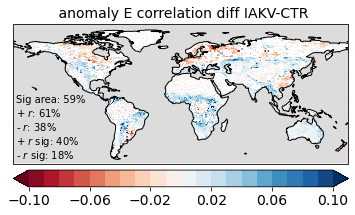

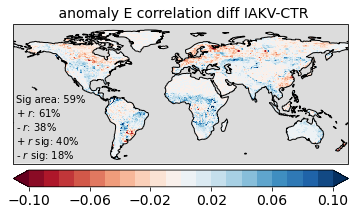

In [29]:
for sig in ['sig_yes','sig_no']:
    ref_data = 'DOLCE_v3'
    start_year = '1999'
    end_year = '2018'
    var = 'hfls'
    reps = 1000
    tp = 'ia anomalies'
    dt = 'dt_yes'
    #load quantiles
    tp2 = tp.replace(" ", "_")
    q = xr.open_dataset(f'{fol}/scripts/HTESSEL/sig_files/q_levels/quantiles_reps{reps}_{exp_name1}_{exp_name2}_{tp2}_{ref_data}_{start_year}_{end_year}_corr_{dt}.nc')

    # calculate correlation
    rd=calculate_correlation(fol,ref_data,tp,start_year, end_year,var,exp_name1,exp_name2,dt)
    r=rd[0]
    r1=rd[1]
    r2=rd[2]

    # calculate area percentages of results
    cube = r.to_iris()
    cube.coord('latitude').guess_bounds()
    cube.coord('longitude').guess_bounds()
    grid_areas = iris.analysis.cartography.area_weights(cube)

    # without significance
    r = r.where(r.lat>-60) # exclude antarctica
    areas = xr.DataArray(grid_areas, dims=['lat','lon']) # convert iris cube to xarray
    areas = areas.where(areas.lat>-60) # exclude antarctica
    a = areas.where(r.notnull()) # all land points areas with data
    asum = a.sum().values # total land area with data

    ap = areas.where(r>0) # positive correlation diff - improvement
    an = areas.where(r<0) # negative correlation diff - deterioration
    ap_p = ap.sum().values/a.sum().values # percentage of +
    an_p = an.sum().values/a.sum().values # percentage of -

    # with significance
    rs = r.where((r<q.q_value[4]) & (r>q.q_value[1])) #non sig points
    rs2 = r.where((r>q.q_value[4]) | (r<q.q_value[1])) #5% and 95% sig points

    rs2 = rs2.where(rs2.lat>-60) # exclude antarctica
    areas = xr.DataArray(grid_areas, dims=['lat','lon']) # convert iris cube to xarray
    areas = areas.where(areas.lat>-60) # exclude antarctica
    a = areas.where(r.notnull()) # all land points areas with data
    asum = a.sum().values # total land area with data

    asig = areas.where(rs2.notnull()) # all land points areas with data
    asigsum = asig.sum().values # total land area with data
    asigp = asigsum/asum
    aps = areas.where(rs2>0) # positive correlation diff - improvement
    ans = areas.where(rs2<0) # negative correlation diff - deterioration
    aps_p = aps.sum().values/a.sum().values # percentage of +
    ans_p = ans.sum().values/a.sum().values # percentage of -

    # mean + or - delta correlation
    rp = r.where(r>0).mean().values
    rn = r.where(r<0).mean().values

    rps = rs2.where(rs2>0).mean().values
    rns = rs2.where(rs2<0).mean().values

    rnull = r.isnull()

    lvls = np.linspace(-0.1,0.1,21)
    lvls3 = np.linspace(-0.1,0.1,6)
    lvls2 = np.linspace(-0.1,0.1,2)
    cm = plt.cm.get_cmap('RdBu')  
    cm2 = plt.cm.get_cmap('Pastel2_r')

    fig = plt.figure(figsize=(6,6))
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.coastlines()
    cf3 = rnull.plot(ax=ax,cmap=cmap_grey,add_colorbar=False,levels=lvls2)#plot in grey all nan points
    cf = r.plot(ax=ax, cmap=cm, add_colorbar=False, vmin=0, vmax=5, levels=lvls)#plot all points
    if (sig=='sig_yes'):
        cf2 = rs.plot(ax=ax,cmap=cmap_white,add_colorbar=False,levels=lvls2)#plot in grey all non-significant points
    cbar = plt.colorbar(cf, orientation='horizontal',extend='both',label=f'', pad=0.02, ticks=lvls3)
    cbar.ax.tick_params(labelsize=14)
    ax.set_title(f' anomaly E correlation diff {name2}-{name1}',size=14)
    ax.set_ylim(-60,90)
    ax.set_xlim(-180,180)
    ax.annotate(f'Sig area: {np.int(asigp*100)}%',(-177,5), size=10)
    ax.annotate(f'+ $r$: {np.int(ap_p*100)}%',(-177,-10), size=10)
    ax.annotate(f'- $r$: {np.int(an_p*100)}%',(-177,-25),size=10)
    ax.annotate(f'+ $r$ sig: {np.int(aps_p*100)}%',(-177,-40), size=10)
    ax.annotate(f'- $r$ sig: {np.int(ans_p*100)}%',(-177,-55),size=10)
    fig.savefig(f'{fol}/scripts/HTESSEL/figures/paper_figures/{exp_name1}_{exp_name2}/global_maps/correlation/corrdiff_E_{exp_name1}_{exp_name2}_{reps}_ia_anomalies_allmonths_{start_year}_{end_year}_dolce_{dt}_{sig}.jpg',dpi=300,bbox_inches='tight')
    # ax.annotate(f'Sig area: {np.int(asigp*100)}%',(-177,5), size=15)
    # ax.annotate(f'+ $r$: {np.int(ap_p*100)}%, m: {np.round(rp,2)}',(-177,-10), size=15)
    # ax.annotate(f'- $r$: {np.int(an_p*100)}%, m: {np.round(rn,2)}',(-177,-25),size=15)
    # ax.annotate(f'+ $r$ sig: {np.int(aps_p*100)}%, m: {np.round(rps,2)}',(-177,-40), size=15)
    # ax.annotate(f'- $r$ sig: {np.int(ans_p*100)}%, m: {np.round(rns,2)}',(-177,-55),size=15)
    # fig.savefig(f'/home/vanoorschot/work/fransje/scripts/HTESSEL/figures/paper_figures/correlation_maps/evaporation/corrdiff_E_{exp_name1}_{exp_name2}_{reps}_ia_anomalies_allmonths_{start_year}_{end_year}_dolce_{dt}_{sig}.jpg',dpi=300,bbox_inches='tight')


### EVAPORATION - seasons

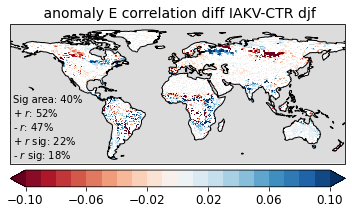

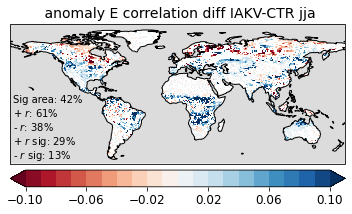

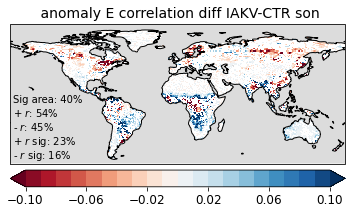

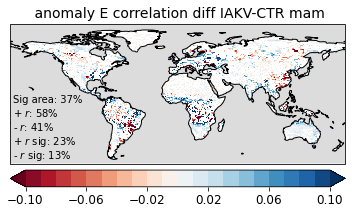

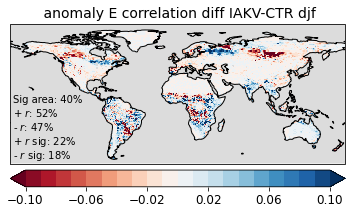

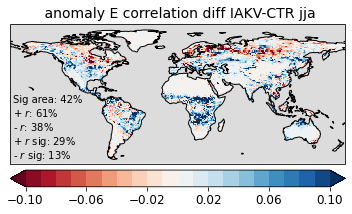

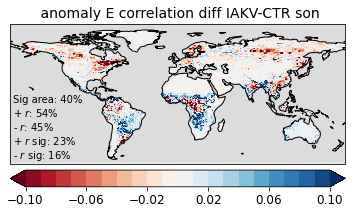

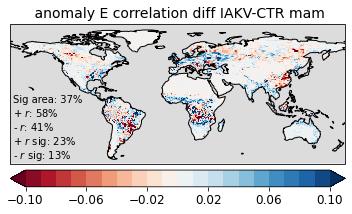

In [30]:
for sig in ['sig_yes','sig_no']:
    for season in ['djf','jja','son','mam']: 
        ref_data = 'DOLCE_v3'
        start_year = '1999'
        end_year = '2018'
        var = 'hfls'
        reps=1000
        tp = f'ia anomalies {season}'

        #load quantiles
        tp2 = tp.replace(" ", "_")
        q = xr.open_dataset(f'{fol}/scripts/HTESSEL/sig_files/q_levels/quantiles_reps{reps}_{exp_name1}_{exp_name2}_{tp2}_{season}_{ref_data}_{start_year}_{end_year}_corr_{dt}.nc')

        # calculate correlation
        rd=calculate_correlation_seasons(fol,ref_data,tp,start_year, end_year,var,exp_name1,exp_name2,season,dt)
        r=rd[0]
        r1=rd[1]
        r2=rd[2]

        # calculate area percentages of results
        cube = r.to_iris()
        cube.coord('latitude').guess_bounds()
        cube.coord('longitude').guess_bounds()
        grid_areas = iris.analysis.cartography.area_weights(cube)

        # without significance
        r = r.where(r.lat>-60) # exclude antarctica
        areas = xr.DataArray(grid_areas, dims=['lat','lon']) # convert iris cube to xarray
        areas = areas.where(areas.lat>-60) # exclude antarctica
        a = areas.where(r.notnull()) # all land points areas with data
        asum = a.sum().values # total land area with data

        ap = areas.where(r>0) # positive correlation diff - improvement
        an = areas.where(r<0) # negative correlation diff - deterioration
        ap_p = ap.sum().values/a.sum().values # percentage of +
        an_p = an.sum().values/a.sum().values # percentage of -

        # with significance
        rs = r.where((r<q.q_value[4]) & (r>q.q_value[1])) #non sig points
        rs2 = r.where((r>q.q_value[4]) | (r<q.q_value[1])) #5% and 95% sig points

        rs2 = rs2.where(rs2.lat>-60) # exclude antarctica
        areas = xr.DataArray(grid_areas, dims=['lat','lon']) # convert iris cube to xarray
        areas = areas.where(areas.lat>-60) # exclude antarctica
        a = areas.where(r.notnull()) # all land points areas with data
        asum = a.sum().values # total land area with data

        asig = areas.where(rs2.notnull()) # all land points areas with data
        asigsum = asig.sum().values # total land area with data
        asigp = asigsum/asum
        aps = areas.where(rs2>0) # positive correlation diff - improvement
        ans = areas.where(rs2<0) # negative correlation diff - deterioration
        aps_p = aps.sum().values/a.sum().values # percentage of +
        ans_p = ans.sum().values/a.sum().values # percentage of -

        # mean + or - delta correlation
        rp = r.where(r>0).mean().values
        rn = r.where(r<0).mean().values

        rps = rs2.where(rs2>0).mean().values
        rns = rs2.where(rs2<0).mean().values

        rnull = r.isnull()

        lvls = np.linspace(-0.1,0.1,21)
        lvls3 = np.linspace(-0.1,0.1,6)
        lvls2 = np.linspace(-0.1,0.1,2)
        cm = plt.cm.get_cmap('RdBu')  
        cm2 = plt.cm.get_cmap('Pastel2_r')

        fig = plt.figure(figsize=(6,6))
        ax = plt.axes(projection=ccrs.PlateCarree())
        ax.coastlines()
        cf3 = rnull.plot(ax=ax,cmap=cmap_grey,add_colorbar=False,levels=lvls2)#plot in grey all nan points
        cf = r.plot(ax=ax, cmap=cm, add_colorbar=False, vmin=0, vmax=5, levels=lvls)#plot all points
        if (sig=='sig_yes'):
            cf2 = rs.plot(ax=ax,cmap=cmap_white,add_colorbar=False,levels=lvls2)#plot in grey all non-significant points
        cbar = plt.colorbar(cf, orientation='horizontal',extend='both',label=f'', pad=0.02, ticks=lvls3)
        cbar.ax.tick_params(labelsize=12)
        ax.set_title(f' anomaly E correlation diff {name2}-{name1} {season}',size=14)
        ax.set_ylim(-60,90)
        ax.set_xlim(-180,180)
        ax.annotate(f'Sig area: {np.int(asigp*100)}%',(-177,5), size=10)
        ax.annotate(f'+ $r$: {np.int(ap_p*100)}%',(-177,-10), size=10)
        ax.annotate(f'- $r$: {np.int(an_p*100)}%',(-177,-25),size=10)
        ax.annotate(f'+ $r$ sig: {np.int(aps_p*100)}%',(-177,-40), size=10)
        ax.annotate(f'- $r$ sig: {np.int(ans_p*100)}%',(-177,-55),size=10)

        # ax.annotate(f'Sig area: {np.int(asigp*100)}%',(-177,5), size=15)
        # ax.annotate(f'+ $r$: {np.int(ap_p*100)}%, m: {np.round(rp,2)}',(-177,-10), size=15)
        # ax.annotate(f'- $r$: {np.int(an_p*100)}%, m: {np.round(rn,2)}',(-177,-25),size=15)
        # ax.annotate(f'+ $r$ sig: {np.int(aps_p*100)}%, m: {np.round(rps,2)}',(-177,-40), size=15)
        # ax.annotate(f'- $r$ sig: {np.int(ans_p*100)}%, m: {np.round(rns,2)}',(-177,-55),size=15)
        fig.savefig(f'{fol}/scripts/HTESSEL/figures/paper_figures/{exp_name1}_{exp_name2}/global_maps/correlation/seasons/corrdiff_E_{exp_name1}_{exp_name2}_{reps}_ia_anomalies_allmonths_{start_year}_{end_year}_dolce_{dt}_{sig}_{season}.jpg',dpi=300,bbox_inches='tight')



### SOIL MOISTURE - all months

/home/vanoorschot/miniconda3/envs/ewatercycle/lib/python3.9/site-packages/xarray/core/nputils.py:169: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/home/vanoorschot/miniconda3/envs/ewatercycle/lib/python3.9/site-packages/xarray/core/nputils.py:169: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/home/vanoorschot/miniconda3/envs/ewatercycle/lib/python3.9/site-packages/xarray/core/nputils.py:169: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/home/vanoorschot/miniconda3/envs/ewatercycle/lib/python3.9/site-packages/xarray/core/nputils.py:169: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/home/vanoorschot/miniconda3/envs/ewatercycle/lib/python3.9/site-packages/xarray/core/nputils.py:169: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/home/vanoorschot/miniconda3/envs/ewater

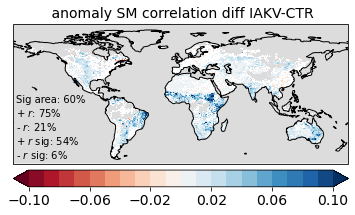

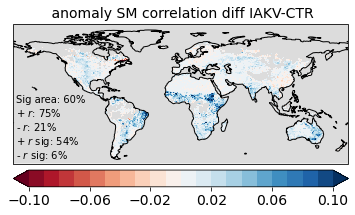

In [31]:
for sig in ['sig_yes','sig_no']: 
    start_year = '1999'
    end_year = '2019'
    reps=1000
    tp = f'ia anomalies'
    layer='layer1'
    th='60'
    #load quantiles
    tp2 = tp.replace(" ", "_")
    q = xr.open_dataset(f'{fol}/scripts/HTESSEL/sig_files/q_levels/quantiles_reps{reps}_{exp_name1}_{exp_name2}_ia_anomalies_esacci_{start_year}_{end_year}_corr_{dt}_{th}.nc')
    
    # calculate correlation
    rd=calculate_correlation_SM_esa(fol,tp,start_year, end_year,exp_name1,exp_name2,layer,dt,th)    
    r=rd[0]
    r1=rd[1]
    r2=rd[2]

    # calculate area percentages of results
    cube = r.to_iris()
    cube.coord('latitude').guess_bounds()
    cube.coord('longitude').guess_bounds()
    grid_areas = iris.analysis.cartography.area_weights(cube)

    # without significance
    r = r.where(r.lat>-60) # exclude antarctica
    areas = xr.DataArray(grid_areas, dims=['lat','lon']) # convert iris cube to xarray
    areas = areas.where(areas.lat>-60) # exclude antarctica
    a = areas.where(r.notnull()) # all land points areas with data
    asum = a.sum().values # total land area with data

    ap = areas.where(r>0) # positive correlation diff - improvement
    an = areas.where(r<0) # negative correlation diff - deterioration
    ap_p = ap.sum().values/a.sum().values # percentage of +
    an_p = an.sum().values/a.sum().values # percentage of -

    # with significance
    rs = r.where((r<q.q_value[4]) & (r>q.q_value[1])) #non sig points
    rs2 = r.where((r>q.q_value[4]) | (r<q.q_value[1])) #5% and 95% sig points

    rs2 = rs2.where(rs2.lat>-60) # exclude antarctica
    areas = xr.DataArray(grid_areas, dims=['lat','lon']) # convert iris cube to xarray
    areas = areas.where(areas.lat>-60) # exclude antarctica
    a = areas.where(r.notnull()) # all land points areas with data
    asum = a.sum().values # total land area with data

    asig = areas.where(rs2.notnull()) # all land points areas with data
    asigsum = asig.sum().values # total land area with data
    asigp = asigsum/asum
    aps = areas.where(rs2>0) # positive correlation diff - improvement
    ans = areas.where(rs2<0) # negative correlation diff - deterioration
    aps_p = aps.sum().values/a.sum().values # percentage of +
    ans_p = ans.sum().values/a.sum().values # percentage of -
    
    # mean + or - delta correlation
    rp = r.where(r>0).mean().values
    rn = r.where(r<0).mean().values

    rps = rs2.where(rs2>0).mean().values
    rns = rs2.where(rs2<0).mean().values

    rnull = r.isnull()

    lvls = np.linspace(-0.1,0.1,21)
    lvls3 = np.linspace(-0.1,0.1,6)
    lvls2 = np.linspace(-0.1,0.1,2)
    cm = plt.cm.get_cmap('RdBu')  
    cm2 = plt.cm.get_cmap('Pastel2_r')

    fig = plt.figure(figsize=(6,6))
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.coastlines()
    cf3 = rnull.plot(ax=ax,cmap=cmap_grey,add_colorbar=False,levels=lvls2)#plot in grey all nan points
    cf = r.plot(ax=ax, cmap=cm, add_colorbar=False, vmin=0, vmax=5, levels=lvls)#plot all points
    if (sig=='sig_yes'):
        cf2 = rs.plot(ax=ax,cmap=cmap_white,add_colorbar=False,levels=lvls2)#plot in grey all non-significant points
    cbar = plt.colorbar(cf, orientation='horizontal',extend='both',label=f'', pad=0.02, ticks=lvls3)
    cbar.ax.tick_params(labelsize=14)
    ax.set_title(f' anomaly SM correlation diff {name2}-{name1}',size=14)
    ax.set_ylim(-60,90)
    ax.set_xlim(-180,180)
    ax.annotate(f'Sig area: {np.int(asigp*100)}%',(-177,5), size=10)
    ax.annotate(f'+ $r$: {np.int(ap_p*100)}%',(-177,-10), size=10)
    ax.annotate(f'- $r$: {np.int(an_p*100)}%',(-177,-25),size=10)
    ax.annotate(f'+ $r$ sig: {np.int(aps_p*100)}%',(-177,-40), size=10)
    ax.annotate(f'- $r$ sig: {np.int(ans_p*100)}%',(-177,-55),size=10)
    fig.savefig(f'{fol}/scripts/HTESSEL/figures/paper_figures/{exp_name1}_{exp_name2}/global_maps/correlation/corrdiff_SM_{exp_name1}_{exp_name2}_{reps}_ia_anomalies_allmonths_{start_year}_{end_year}_esa-cci_{dt}_{sig}.jpg',dpi=300,bbox_inches='tight')

    # ax.annotate(f'Sig area: {np.int(asigp*100)}%',(-177,5), size=15)
    # ax.annotate(f'+ $r$: {np.int(ap_p*100)}%, m: {np.round(rp,2)}',(-177,-10), size=15)
    # ax.annotate(f'- $r$: {np.int(an_p*100)}%, m: {np.round(rn,2)}',(-177,-25),size=15)
    # ax.annotate(f'+ $r$ sig: {np.int(aps_p*100)}%, m: {np.round(rps,2)}',(-177,-40), size=15)
    # ax.annotate(f'- $r$ sig: {np.int(ans_p*100)}%, m: {np.round(rns,2)}',(-177,-55),size=15)
    # fig.savefig(f'/home/vanoorschot/work/fransje/scripts/HTESSEL/figures/paper_figures/correlation_maps/soilmoisture/corrdiff_SM_{exp_name1}_{exp_name2}_{reps}_ia_anomalies_allmonths_{start_year}_{end_year}_esacci_{dt}_{sig}.jpg',dpi=300,bbox_inches='tight')

    

### SOIL MOISTURE - seasons

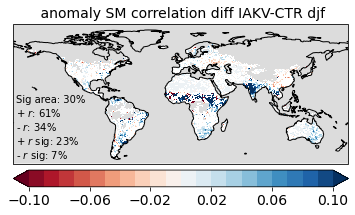

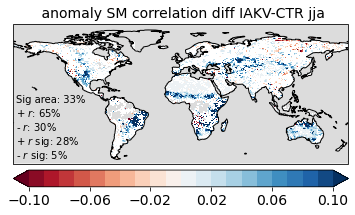

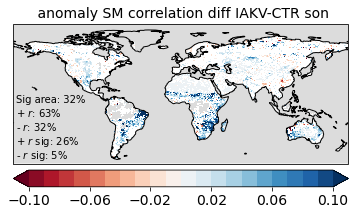

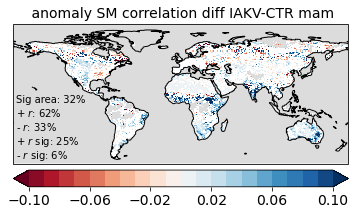

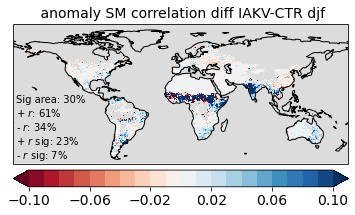

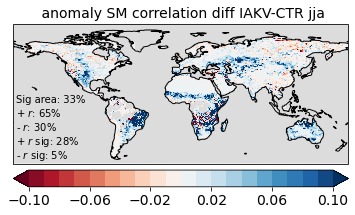

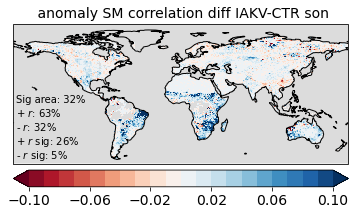

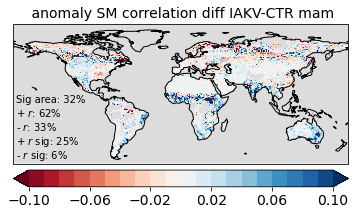

In [32]:
for sig in ['sig_yes','sig_no']:
    for season in ['djf','jja','son','mam']: 
        start_year = '1999'
        reps=1000
        tp = f'ia anomalies {season}'
        layer='layer1'
        th='60'
        #load quantiles
        tp2 = tp.replace(" ", "_")
        q = xr.open_dataset(f'{fol}/scripts/HTESSEL/sig_files/q_levels/quantiles_reps{reps}_{exp_name1}_{exp_name2}_ia_anomalies_esacci_{season}_{start_year}_{end_year}_corr_{dt}_{th}.nc')
        # plot correlation
        rd=calculate_correlation_SM_esa_seasons(fol,tp,start_year, end_year,exp_name1,exp_name2,layer,season,dt,th)
        r=rd[0]
        r1=rd[1]
        r2=rd[2]

        # calculate area percentages of results
        cube = r.to_iris()
        cube.coord('latitude').guess_bounds()
        cube.coord('longitude').guess_bounds()
        grid_areas = iris.analysis.cartography.area_weights(cube)

        # without significance
        r = r.where(r.lat>-60) # exclude antarctica
        areas = xr.DataArray(grid_areas, dims=['lat','lon']) # convert iris cube to xarray
        areas = areas.where(areas.lat>-60) # exclude antarctica
        a = areas.where(r.notnull()) # all land points areas with data
        asum = a.sum().values # total land area with data

        ap = areas.where(r>0) # positive correlation diff - improvement
        an = areas.where(r<0) # negative correlation diff - deterioration
        ap_p = ap.sum().values/a.sum().values # percentage of +
        an_p = an.sum().values/a.sum().values # percentage of -

        # with significance
        rs = r.where((r<q.q_value[4]) & (r>q.q_value[1])) #non sig points
        rs2 = r.where((r>q.q_value[4]) | (r<q.q_value[1])) #5% and 95% sig points

        rs2 = rs2.where(rs2.lat>-60) # exclude antarctica
        areas = xr.DataArray(grid_areas, dims=['lat','lon']) # convert iris cube to xarray
        areas = areas.where(areas.lat>-60) # exclude antarctica
        a = areas.where(r.notnull()) # all land points areas with data
        asum = a.sum().values # total land area with data

        asig = areas.where(rs2.notnull()) # all land points areas with data
        asigsum = asig.sum().values # total land area with data
        asigp = asigsum/asum
        aps = areas.where(rs2>0) # positive correlation diff - improvement
        ans = areas.where(rs2<0) # negative correlation diff - deterioration
        aps_p = aps.sum().values/a.sum().values # percentage of +
        ans_p = ans.sum().values/a.sum().values # percentage of -

        # mean + or - delta correlation
        rp = r.where(r>0).mean().values
        rn = r.where(r<0).mean().values

        rps = rs2.where(rs2>0).mean().values
        rns = rs2.where(rs2<0).mean().values

        rnull = r.isnull()

        lvls = np.linspace(-0.1,0.1,21)
        lvls3 = np.linspace(-0.1,0.1,6)
        lvls2 = np.linspace(-0.1,0.1,2)
        cm = plt.cm.get_cmap('RdBu')  
        cm2 = plt.cm.get_cmap('Pastel2_r')

        fig = plt.figure(figsize=(6,6))
        ax = plt.axes(projection=ccrs.PlateCarree())
        ax.coastlines()
        cf3 = rnull.plot(ax=ax,cmap=cmap_grey,add_colorbar=False,levels=lvls2)#plot in grey all nan points
        cf = r.plot(ax=ax, cmap=cm, add_colorbar=False, vmin=0, vmax=5, levels=lvls)#plot all points
        if (sig=='sig_yes'):
            cf2 = rs.plot(ax=ax,cmap=cmap_white,add_colorbar=False,levels=lvls2)#plot in grey all non-significant points
        cbar = plt.colorbar(cf, orientation='horizontal',extend='both',label=f'', pad=0.02, ticks=lvls3)
        cbar.ax.tick_params(labelsize=14)
        ax.set_title(f' anomaly SM correlation diff {name2}-{name1} {season}',size=14)
        ax.set_ylim(-60,90)
        ax.set_xlim(-180,180)
        ax.annotate(f'Sig area: {np.int(asigp*100)}%',(-177,5), size=10)
        ax.annotate(f'+ $r$: {np.int(ap_p*100)}%',(-177,-10), size=10)
        ax.annotate(f'- $r$: {np.int(an_p*100)}%',(-177,-25),size=10)
        ax.annotate(f'+ $r$ sig: {np.int(aps_p*100)}%',(-177,-40), size=10)
        ax.annotate(f'- $r$ sig: {np.int(ans_p*100)}%',(-177,-55),size=10)
        fig.savefig(f'{fol}/scripts/HTESSEL/figures/paper_figures/{exp_name1}_{exp_name2}/global_maps/correlation/seasons/corrdiff_SM_{exp_name1}_{exp_name2}_{reps}_ia_anomalies_allmonths_{start_year}_{end_year}_esacci_{dt}_{sig}_{season}.jpg',dpi=300,bbox_inches='tight')


        # ax.annotate(f'Sig area: {np.int(asigp*100)}%',(-177,5), size=15)
        # ax.annotate(f'+ $r$: {np.int(ap_p*100)}%, m: {np.round(rp,2)}',(-177,-10), size=15)
        # ax.annotate(f'- $r$: {np.int(an_p*100)}%, m: {np.round(rn,2)}',(-177,-25),size=15)
        # ax.annotate(f'+ $r$ sig: {np.int(aps_p*100)}%, m: {np.round(rps,2)}',(-177,-40), size=15)
        # ax.annotate(f'- $r$ sig: {np.int(ans_p*100)}%, m: {np.round(rns,2)}',(-177,-55),size=15)
        # fig.savefig(f'/home/vanoorschot/work/fransje/scripts/HTESSEL/figures/paper_figures/correlation_maps/soilmoisture/corrdiff_SM_{exp_name1}_{exp_name2}_{reps}_ia_anomalies_{season}_{start_year}_{end_year}_esacci_{dt}_{sig}.jpg',dpi=300,bbox_inches='tight')


In [ ]:
ls

In [19]:
def plot_ts_rmse(exp_name1,exp_name2,rmse1,rmse2,rmse1_djf,rmse2_djf,rmse1_jja,rmse2_jja,fc,cv1,cv2,cvl1,cvh1,cvl2,cvh2,lat_min,lat_max,lon_min,lon_max,tvl,tvh,al,ah,ymin,ymax):
    lat_ix1,lon_ix1,latstr1,lonstr1 = select_point(fc,lat_min,lat_max,lon_min,lon_max)
    
    # select timeseries from data
    fcp = fc[:,lat_ix1,lon_ix1]
    cp1 = cv1[:,lat_ix1,lon_ix1]
    cp2 = cv2[:,lat_ix1,lon_ix1]
    cl1 = cvl1[:,lat_ix1,lon_ix1]
    cl2 = cvl2[:,lat_ix1,lon_ix1]
    ch1 = cvh1[:,lat_ix1,lon_ix1]
    ch2 = cvh2[:,lat_ix1,lon_ix1]
    tvl = tvl[lat_ix1,lon_ix1]
    tvh = tvh[lat_ix1,lon_ix1]
    al1 = al[:,lat_ix1,lon_ix1]
    ah1 = ah[:,lat_ix1,lon_ix1]
    alc = al[4,lat_ix1,lon_ix1]
    ahc = ah[4,lat_ix1,lon_ix1]
    
    fcpm = fcp.groupby('time.month').mean('time')
    cp1m = cp1.groupby('time.month').mean('time')
    cp2m = cp2.groupby('time.month').mean('time')

    # string of statistics
    rmse1_jja_str = str(np.round(rmse1_jja[lat_ix1,lon_ix1].values,3))
    rmse2_jja_str = str(np.round(rmse2_jja[lat_ix1,lon_ix1].values,3))
    rmse1_djf_str = str(np.round(rmse1_djf[lat_ix1,lon_ix1].values,3))
    rmse2_djf_str = str(np.round(rmse2_djf[lat_ix1,lon_ix1].values,3))
    rrmse1 = rmse1[lat_ix1,lon_ix1].values
    rrmse2 = rmse2[lat_ix1,lon_ix1].values
    tvh_str = str(int(tvh.values))
    tvl_str = str(int(tvl.values))
    al_str = str(np.round((alc.values),2))
    ah_str = str(np.round((ahc.values),2))

    # plot timeseries
    fig = plt.figure(figsize=(12,3))
    ax = fig.add_subplot(111)
    ax.plot(fcp.time,fcp, label='FCOVER',color='tab:blue',linewidth=2)
    ax.plot(cp1.time,cp1, label='IAK5',color='peru',linewidth=2)
    ax.plot(cp2.time,cp2, label='IAKV',color='darkgreen',linewidth=2)
    # ax.annotate(f'RMSE JJA IAK5: {rmse1_jja_str}', ('2005-01-25',ymax-0.04),size=12)
    # ax.annotate(f'RMSE JJA IAKV: {rmse2_jja_str}', ('2005-01-25',ymax-0.1),size=12)
    # ax.annotate(f'RMSE DJF IAK5: {rmse1_djf_str}', ('2005-08-15',ymax-0.04),size=12)
    # ax.annotate(f'RMSE DJF IAKV: {rmse2_djf_str}', ('2005-08-15',ymax-0.1),size=12)
    # ax.plot(al1.time,al1, label=f'AL')
    # ax.plot(ah1.time,ah1, label=f'AH')
    # ax.plot(cl1.time,cl1, label=f'{exp_name1} CVL')
    # ax.plot(cl2.time,cl2, label=f'{exp_name2} CVL')
    # ax.plot(ch1.time,ch1, label=f'{exp_name1} CVH')
    # ax.plot(ch2.time,ch2, label=f'{exp_name2} CVH')    
    # ax.set_title(f'LAT = {latstr1}, LON = {lonstr1}, TVH{tvh_str}, TVL{tvl_str}, AL={al_str}, AH={ah_str}')
    ax.set_xlim('2008-01-15','2010-12-15')
    ax.set_ylim(ymin,ymax)
    # ax.set_xticks(['2005-01-15','2005-07-15','2006-01-15','2006-07-15','2007-01-15','2007-07-15'])
    # ax.set_xticklabels(['2005-01','2005-07','2006-01','2006-07','2007-01','2007-07'])
    ax.set_xticks(['2008-01-15','2008-07-15','2009-01-15','2009-07-15','2010-01-15','2010-07-15'])
    ax.set_xticklabels(['2008-01','2008-07','2009-01','2009-07','2010-01','2010-07'])
        # ax.set_xticks(['2005-01-15','2005-04-15','2005-07-15','2005-10-15','2006-01-15','2006-04-15','2006-07-15','2006-10-15','2007-01-15','2007-04-15','2007-07-15','2007-10-15'])
    # ax.set_xticklabels(['2005-01','2005-04','2005-07','2005-10','2006-01','2006-04','2006-07','2006-10','2007-01','2007-04','2007-07','2007-10'])
    ax.xaxis.set_minor_locator(mdates.DayLocator(bymonthday=15))
    ax.tick_params(axis='x', which='major',length=5, labelsize=15)
    ax.tick_params(axis='x', which='minor',length=3, labelsize=15)
    ax.tick_params(axis='y', which='major',length=5, labelsize=15)
    ax.set_ylabel('Effective veg cover (-)',size=15)
    # ax.legend(ncol=3,fontsize=17)
    fig.savefig(f'/home/vanoorschot/work/fransje/scripts/HTESSEL/figures/paper_figures/cvh_cvl/exp5_exp6/lat{latstr1}_lon{lonstr1}_FCOVER_CVHCVL_rmse_{exp_name1}_{exp_name2}.jpg',dpi=300,bbox_inches='tight')
    
    # plot climatology
    fig = plt.figure(figsize=(4,3))
    ax = fig.add_subplot(111)
    ax.plot(cp1m.month,cp1m, label='IAK5',color='peru',linewidth=2)
    ax.plot(cp2m.month,cp2m, label='IAKV',color='darkgreen',linewidth=2)
    ax.plot(fcpm.month,fcpm, label='CGLS',color='tab:blue',linewidth=2)
    ax.set_xlim(1,12)
    ax.set_ylim(ymin,ymax)
    ax.set_xticks([1,2,3,4,5,6,7,8,9,10,11,12])
    # ax.set_xticklabels(['1','2','3','4','5','6','7','8','9','10','11','12'])
    ax.set_xticklabels(['J','F','M','A','M','J','J','A','S','O','N','D'])
    ax.xaxis.set_minor_locator(mdates.DayLocator(bymonthday=15))
    ax.tick_params(axis='x', which='major',length=5, labelsize=15)
    ax.tick_params(axis='y', which='major',length=5, labelsize=15)
    ax.set_ylabel('FCover (-)',size=15)
    # ax.legend(ncol=2,fontsize=17)
    fig.savefig(f'/home/vanoorschot/work/fransje/scripts/HTESSEL/figures/paper_figures/cvh_cvl/exp5_exp6/lat{latstr1}_lon{lonstr1}_FCOVER_CVHCVL_rmse_{exp_name1}_{exp_name2}_climatology.jpg',dpi=300,bbox_inches='tight')
    
    print('rmse1,rmse2:',rrmse1,rrmse2)
    
    plon1,plat1 = cv1.lon[lon_ix1].values, cv1.lat[lat_ix1].values
    if plon1 > 180:
        plon1 = plon1-360
    return plon1,plat1

rmse1,rmse2: 0.05729031 0.04455947
rmse1,rmse2: 0.13700691 0.059776053


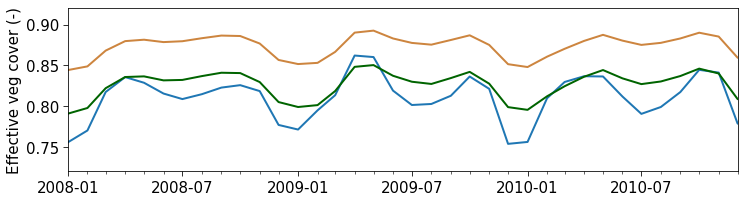

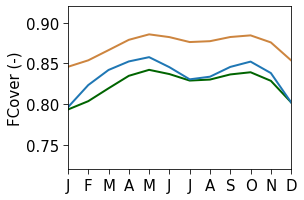

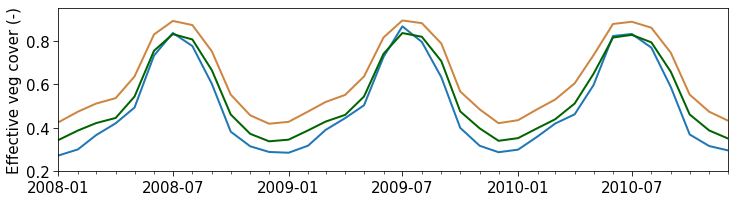

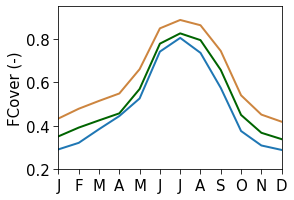

In [20]:
# # #northern finland
# lat_min, lat_max = 64,65
# lon_min, lon_max = 29,30
# ymin,ymax=0.2,0.75
# plon1,plat1 = plot_ts_rmse(exp_name1,exp_name2,rmse1_djf,rmse2_djf,rmse1_jja,rmse2_jja,fc,cv1,cv2,cvl1,cvh1,cvl2,cvh2,lat_min,lat_max,lon_min,lon_max,tvl,tvh,al,ah,ymin,ymax)
# # plot_ts_rmse_anomalies(exp_name1,exp_name2,rmse1_djf,rmse2_djf,rmse1_jja,rmse2_jja,fc_ia,cv1_ia,cv2_ia,cvl1,cvh1,cvl2,cvh2,lat_min,lat_max,lon_min,lon_max,tvl,tvh,al,ah)

# # # canada boreal
# lat_min, lat_max = 62,63
# lon_min, lon_max = 263,264
# ymin,ymax=0.05,0.41
# plon3,plat3 = plot_ts_rmse(exp_name1,exp_name2,rmse1_djf,rmse2_djf,rmse1_jja,rmse2_jja,fc,cv1,cv2,cvl1,cvh1,cvl2,cvh2,lat_min,lat_max,lon_min,lon_max,tvl,tvh,al,ah,ymin,ymax)
# # plot_ts_rmse_anomalies(exp_name1,exp_name2,rmse1_djf,rmse2_djf,rmse1_jja,rmse2_jja,fc_ia,cv1_ia,cv2_ia,cvl1,cvh1,cvl2,cvh2,lat_min,lat_max,lon_min,lon_max,tvl,tvh,al,ah)

#point in tropical Africa
lat_min, lat_max = 1,2
lon_min, lon_max = 18,19
ymin,ymax=0.72,0.92
plon2,plat2 = plot_ts_rmse(exp_name1,exp_name2,rmse1,rmse2,rmse1_djf,rmse2_djf,rmse1_jja,rmse2_jja,fc,cv1,cv2,cvl1,cvh1,cvl2,cvh2,lat_min,lat_max,lon_min,lon_max,tvl,tvh,al,ah,ymin,ymax)
# plot_ts_rmse_anomalies(exp_name1,exp_name2,rmse1_djf,rmse2_djf,rmse1_jja,rmse2_jja,fc_ia,cv1_ia,cv2_ia,cvl1,cvh1,cvl2,cvh2,lat_min,lat_max,lon_min,lon_max,tvl,tvh,al,ah)

# # # europe point
# lat_min, lat_max = 50,51
# lon_min, lon_max = 5,6
# ymin,ymax=0.15,0.82
# plon4,plat4 = plot_ts_rmse(exp_name1,exp_name2,rmse1_djf,rmse2_djf,rmse1_jja,rmse2_jja,fc,cv1,cv2,cvl1,cvh1,cvl2,cvh2,lat_min,lat_max,lon_min,lon_max,tvl,tvh,al,ah,ymin,ymax)
# # plot_ts_rmse_anomalies(exp_name1,exp_name2,rmse1_djf,rmse2_djf,rmse1_jja,rmse2_jja,fc_ia,cv1_ia,cv2_ia,cvl1,cvh1,cvl2,cvh2,lat_min,lat_max,lon_min,lon_max,tvl,tvh,al,ah)

# # mediterranean point
# lat_min, lat_max = -34,-33
# lon_min, lon_max = 117,118
# ymin,ymax=0.02,0.75
# plon5,plat5 = plot_ts_rmse(exp_name1,exp_name2,rmse1_djf,rmse2_djf,rmse1_jja,rmse2_jja,fc,cv1,cv2,cvl1,cvh1,cvl2,cvh2,lat_min,lat_max,lon_min,lon_max,tvl,tvh,al,ah,ymin,ymax)
# # plot_ts_rmse_anomalies(exp_name1,exp_name2,rmse1_djf,rmse2_djf,rmse1_jja,rmse2_jja,fc_ia,cv1_ia,cv2_ia,cvl1,cvh1,cvl2,cvh2,lat_min,lat_max,lon_min,lon_max,tvl,tvh,al,ah)

# great lakes
lat_min, lat_max = 47,48
lon_min, lon_max = 279,280
ymin,ymax=0.2,0.95
plon6,plat6 = plot_ts_rmse(exp_name1,exp_name2,rmse1,rmse2,rmse1_djf,rmse2_djf,rmse1_jja,rmse2_jja,fc,cv1,cv2,cvl1,cvh1,cvl2,cvh2,lat_min,lat_max,lon_min,lon_max,tvl,tvh,al,ah,ymin,ymax)
# plot_ts_rmse_anomalies(exp_name1,exp_name2,rmse1_djf,rmse2_djf,rmse1_jja,rmse2_jja,fc_ia,cv1_ia,cv2_ia,cvl1,cvh1,cvl2,cvh2,lat_min,lat_max,lon_min,lon_max,tvl,tvh,al,ah)

# BOREAL 2
# lat_min, lat_max = 50,51
# lon_min, lon_max = 266,267
# # lat_min, lat_max = 55,56
# # lon_min, lon_max = 266,267
# ymin,ymax=0.2,0.95
# plon6,plat6 = plot_ts_rmse(exp_name1,exp_name2,rmse1,rmse2,rmse1_djf,rmse2_djf,rmse1_jja,rmse2_jja,fc,cv1,cv2,cvl1,cvh1,cvl2,cvh2,lat_min,lat_max,lon_min,lon_max,tvl,tvh,al,ah,ymin,ymax)
# # china
# lat_min, lat_max = 28,29
# lon_min, lon_max = 119,120
# ymin,ymax=0.2,0.95
# plon7,plat7 = plot_ts_rmse(exp_name1,exp_name2,rmse1_djf,rmse2_djf,rmse1_jja,rmse2_jja,fc,cv1,cv2,cvl1,cvh1,cvl2,cvh2,lat_min,lat_max,lon_min,lon_max,tvl,tvh,al,ah,ymin,ymax)
# # plot_ts_rmse_anomalies(exp_name1,exp_name2,rmse1_djf,rmse2_djf,rmse1_jja,rmse2_jja,fc_ia,cv1_ia,cv2_ia,cvl1,cvh1,cvl2,cvh2,lat_min,lat_max,lon_min,lon_max,tvl,tvh,al,ah)

# # siberia
# lat_min, lat_max = 61,62
# lon_min, lon_max = 149,150
# ymin,ymax=0.1,0.55
# plon7,plat7 = plot_ts_rmse(exp_name1,exp_name2,rmse1_djf,rmse2_djf,rmse1_jja,rmse2_jja,fc,cv1,cv2,cvl1,cvh1,cvl2,cvh2,lat_min,lat_max,lon_min,lon_max,tvl,tvh,al,ah,ymin,ymax)
# # plot_ts_rmse_anomalies(exp_name1,exp_name2,rmse1_djf,rmse2_djf,rmse1_jja,rmse2_jja,fc_ia,cv1_ia,cv2_ia,cvl1,cvh1,cvl2,cvh2,lat_min,lat_max,lon_min,lon_max,tvl,tvh,al,ah)


rmse1,rmse2: 0.052768745 0.070739344


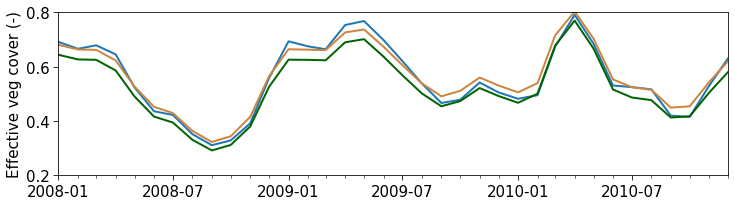

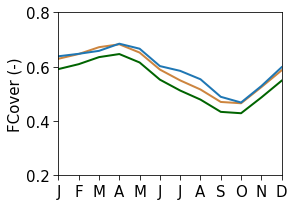

In [100]:
# great lakes
lat_min, lat_max = -16,-15
lon_min, lon_max = 319.5,320.5

# lat_min, lat_max = -14,-13
# lon_min, lon_max = 316.5,317.5
ymin,ymax=0.2,0.8
plon1,plat1 = plot_ts_rmse(exp_name1,exp_name2,rmse1,rmse2,rmse1_djf,rmse2_djf,rmse1_jja,rmse2_jja,fc,cv1,cv2,cvl1,cvh1,cvl2,cvh2,lat_min,lat_max,lon_min,lon_max,tvl,tvh,al,ah,ymin,ymax)

# lat_minb,lat_maxb = -16,-8
# lon_minb2,lon_maxb2 = 310,315

In [101]:
exp_name1='exp5'
exp_name2='exp6' # EFFECT LAI only
start_year=1999
end_year=2019
f_mod1 = f'{fol}/htessel_output/{exp_name1}'
f_mod2 = f'{fol}/htessel_output/{exp_name2}'
mod1 = xr.open_dataset(f'{f_mod1}/monthly/o_wat_{start_year}_{end_year}_monthly.nc')
mod2 = xr.open_dataset(f'{f_mod2}/monthly/o_wat_{start_year}_{end_year}_monthly.nc')
dt = 'dt_yes'
sig = 'sig_yes'

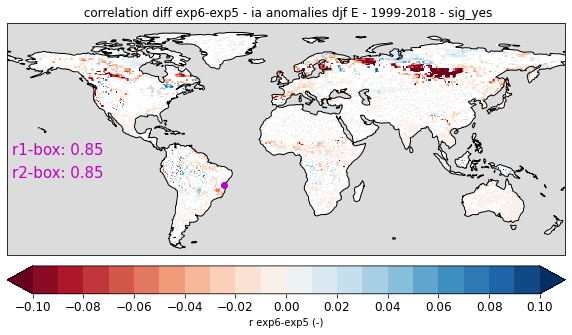

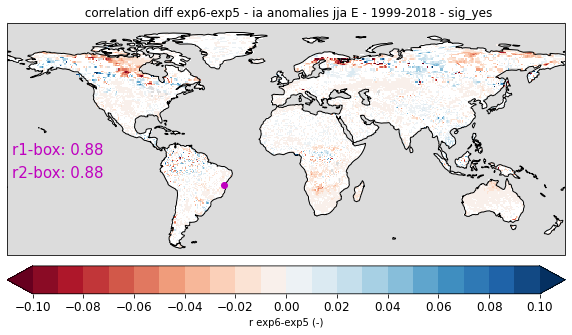

In [102]:
for season in ['djf','jja']:
    ref_data = 'DOLCE_v3'
    start_year = '1999'
    end_year = '2018'
    var = 'hfls'
    reps=1000
    tp = f'ia anomalies {season}'

    #load quantiles
    tp2 = tp.replace(" ", "_")
    q = xr.open_dataset(f'{fol}/scripts/HTESSEL/sig_files/q_levels/quantiles_reps{reps}_{exp_name1}_{exp_name2}_{tp2}_{season}_{ref_data}_{start_year}_{end_year}_corr_{dt}.nc')

    # calculate correlation
    rd=calculate_correlation_seasons(fol,ref_data,tp,start_year, end_year,var,exp_name1,exp_name2,season,dt)
    r=rd[0]
    r1=rd[1]
    r2=rd[2]

    # calculate area percentages of results
    cube = r.to_iris()
    cube.coord('latitude').guess_bounds()
    cube.coord('longitude').guess_bounds()
    grid_areas = iris.analysis.cartography.area_weights(cube)

    # without significance
    r = r.where(r.lat>-60) # exclude antarctica
    areas = xr.DataArray(grid_areas, dims=['lat','lon']) # convert iris cube to xarray
    areas = areas.where(areas.lat>-60) # exclude antarctica
    a = areas.where(r.notnull()) # all land points areas with data
    asum = a.sum().values # total land area with data

    ap = areas.where(r>0) # positive correlation diff - improvement
    an = areas.where(r<0) # negative correlation diff - deterioration
    ap_p = ap.sum().values/a.sum().values # percentage of +
    an_p = an.sum().values/a.sum().values # percentage of -

    # with significance
    rs = r.where((r<q.q_value[4]) & (r>q.q_value[1])) #non sig points
    rs2 = r.where((r>q.q_value[4]) | (r<q.q_value[1])) #5% and 95% sig points

    rs2 = rs2.where(rs2.lat>-60) # exclude antarctica
    areas = xr.DataArray(grid_areas, dims=['lat','lon']) # convert iris cube to xarray
    areas = areas.where(areas.lat>-60) # exclude antarctica
    a = areas.where(r.notnull()) # all land points areas with data
    asum = a.sum().values # total land area with data

    asig = areas.where(rs2.notnull()) # all land points areas with data
    asigsum = asig.sum().values # total land area with data
    asigp = asigsum/asum
    aps = areas.where(rs2>0) # positive correlation diff - improvement
    ans = areas.where(rs2<0) # negative correlation diff - deterioration
    aps_p = aps.sum().values/a.sum().values # percentage of +
    ans_p = ans.sum().values/a.sum().values # percentage of -

    # mean + or - delta correlation
    rp = r.where(r>0).mean().values
    rn = r.where(r<0).mean().values

    rps = rs2.where(rs2>0).mean().values
    rns = rs2.where(rs2<0).mean().values

    rnull = r.isnull()
    
    r1w = r1.where((r1.lat>lat_min)&(r1.lat<lat_max)&(r1.lon>lon_min)&(r1.lon<lon_max))
    r2w = r2.where((r2.lat>lat_min)&(r2.lat<lat_max)&(r2.lon>lon_min)&(r2.lon<lon_max))
    rm1 = r1w.mean().values
    rm2 = r2w.mean().values

    lvls = np.linspace(-0.1,0.1,21)
    lvls3 = np.linspace(-0.1,0.1,11)
    lvls2 = np.linspace(-0.1,0.1,2)
    cm = plt.cm.get_cmap('RdBu')  
    cm2 = plt.cm.get_cmap('Pastel2_r')

    fig = plt.figure(figsize=(10,10))
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.coastlines()
    cf3 = rnull.plot(ax=ax,cmap=cmap_grey,add_colorbar=False,levels=lvls2)#plot in grey all nan points
    cf = r.plot(ax=ax, cmap=cm, add_colorbar=False, vmin=0, vmax=5, levels=lvls)#plot all points
    if (sig=='sig_yes'):
        cf2 = rs.plot(ax=ax,cmap=cmap_white,add_colorbar=False,levels=lvls2)#plot in grey all non-significant points
    cbar = plt.colorbar(cf, orientation='horizontal',extend='both',label=f'r {exp_name2}-{exp_name1} (-)', pad=0.02, ticks=lvls3)
    cbar.ax.tick_params(labelsize=12)
    ax.plot(plon1,plat1,'mo')
    ax.set_title(f' correlation diff {exp_name2}-{exp_name1} - {tp} E - {start_year}-{end_year} - {sig}')
    ax.set_ylim(-60,90)
    ax.set_xlim(-180,180)

    ax.annotate(f'r1-box: {np.round(rm1,2)}',(-177,5), size=15,color='m')
    ax.annotate(f'r2-box: {np.round(rm2,2)}',(-177,-10), size=15,color='m')

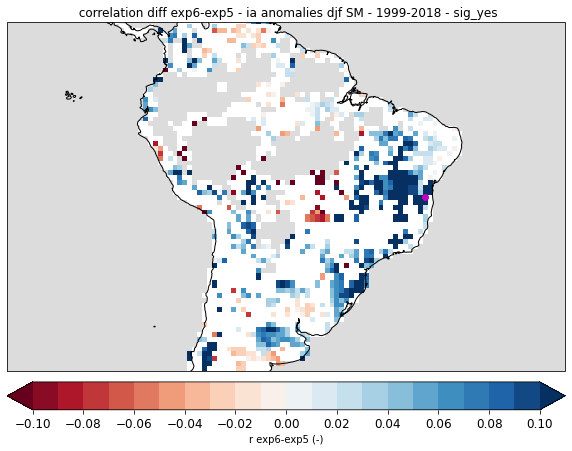

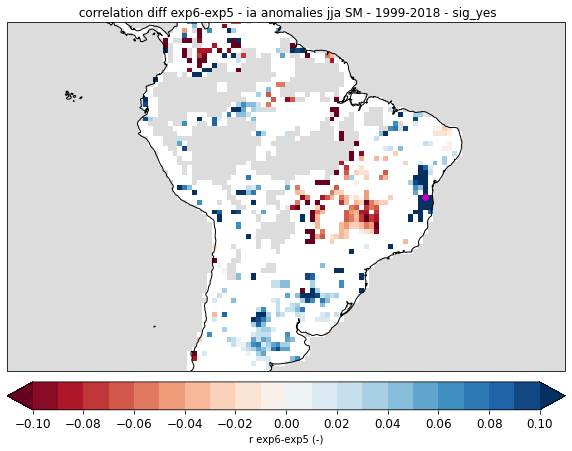

In [103]:
for season in ['djf','jja']:
    start_year = '1999'
    # end_year = '2018'
    reps=1000
    tp = f'ia anomalies {season}'
    layer='layer1'
    th='60'
    #load quantiles
    tp2 = tp.replace(" ", "_")
    q = xr.open_dataset(f'{fol}/scripts/HTESSEL/sig_files/q_levels/quantiles_reps{reps}_{exp_name1}_{exp_name2}_ia_anomalies_esacci_{season}_{start_year}_{end_year}_corr_{dt}_{th}.nc')
    # plot correlation
    rd=calculate_correlation_SM_esa_seasons(fol,tp,start_year, end_year,exp_name1,exp_name2,layer,season,dt,th)
    r=rd[0]
    r1=rd[1]
    r2=rd[2]

    # calculate area percentages of results
    cube = r.to_iris()
    cube.coord('latitude').guess_bounds()
    cube.coord('longitude').guess_bounds()
    grid_areas = iris.analysis.cartography.area_weights(cube)

    # without significance
    r = r.where(r.lat>-60) # exclude antarctica
    areas = xr.DataArray(grid_areas, dims=['lat','lon']) # convert iris cube to xarray
    areas = areas.where(areas.lat>-60) # exclude antarctica
    a = areas.where(r.notnull()) # all land points areas with data
    asum = a.sum().values # total land area with data

    ap = areas.where(r>0) # positive correlation diff - improvement
    an = areas.where(r<0) # negative correlation diff - deterioration
    ap_p = ap.sum().values/a.sum().values # percentage of +
    an_p = an.sum().values/a.sum().values # percentage of -

    # with significance
    rs = r.where((r<q.q_value[4]) & (r>q.q_value[1])) #non sig points
    rs2 = r.where((r>q.q_value[4]) | (r<q.q_value[1])) #5% and 95% sig points

    rs2 = rs2.where(rs2.lat>-60) # exclude antarctica
    areas = xr.DataArray(grid_areas, dims=['lat','lon']) # convert iris cube to xarray
    areas = areas.where(areas.lat>-60) # exclude antarctica
    a = areas.where(r.notnull()) # all land points areas with data
    asum = a.sum().values # total land area with data

    asig = areas.where(rs2.notnull()) # all land points areas with data
    asigsum = asig.sum().values # total land area with data
    asigp = asigsum/asum
    aps = areas.where(rs2>0) # positive correlation diff - improvement
    ans = areas.where(rs2<0) # negative correlation diff - deterioration
    aps_p = aps.sum().values/a.sum().values # percentage of +
    ans_p = ans.sum().values/a.sum().values # percentage of -

    # mean + or - delta correlation
    rp = r.where(r>0).mean().values
    rn = r.where(r<0).mean().values

    rps = rs2.where(rs2>0).mean().values
    rns = rs2.where(rs2<0).mean().values

    rnull = r.isnull()
    
    r1w = r1.where((r1.lat>lat_min)&(r1.lat<lat_max)&(r1.lon>lon_min)&(r1.lon<lon_max))
    r2w = r2.where((r2.lat>lat_min)&(r2.lat<lat_max)&(r2.lon>lon_min)&(r2.lon<lon_max))
    rm1 = r1w.mean().values
    rm2 = r2w.mean().values

    lvls = np.linspace(-0.1,0.1,21)
    lvls3 = np.linspace(-0.1,0.1,11)
    lvls2 = np.linspace(-0.1,0.1,2)
    cm = plt.cm.get_cmap('RdBu')  
    cm2 = plt.cm.get_cmap('Pastel2_r')

    fig = plt.figure(figsize=(10,10))
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.coastlines()
    cf3 = rnull.plot(ax=ax,cmap=cmap_grey,add_colorbar=False,levels=lvls2)#plot in grey all nan points
    cf = r.plot(ax=ax, cmap=cm, add_colorbar=False, vmin=0, vmax=5, levels=lvls)#plot all points
    if (sig=='sig_yes'):
        cf2 = rs.plot(ax=ax,cmap=cmap_white,add_colorbar=False,levels=lvls2)#plot in grey all non-significant points
    cbar = plt.colorbar(cf, orientation='horizontal',extend='both',label=f'r {exp_name2}-{exp_name1} (-)', pad=0.02, ticks=lvls3)
    cbar.ax.tick_params(labelsize=12)
    ax.plot(plon1,plat1,'mo')
    ax.set_title(f' correlation diff {exp_name2}-{exp_name1} - {tp} SM - {start_year}-{end_year} - {sig}')
    # ax.set_ylim(-60,90)
    # ax.set_xlim(-180,180)
    ax.set_ylim(-40,10)
    ax.set_xlim(-100,-20)

    ax.annotate(f'r1-box: {np.round(rm1,2)}',(-177,5), size=15,color='m')
    ax.annotate(f'r2-box: {np.round(rm2,2)}',(-177,-10), size=15,color='m')

      E-std Et-std Es-std Ei-std
IAK5  0.592  0.399  0.187  0.186
IAKV  0.592  0.378  0.205  0.179
      mam    jja    son    djf
e  -0.004 -0.001  0.002 -0.002
et -0.017  -0.01 -0.014 -0.021
es    0.0 -0.002  0.017  0.017
ei -0.005 -0.003 -0.004 -0.005


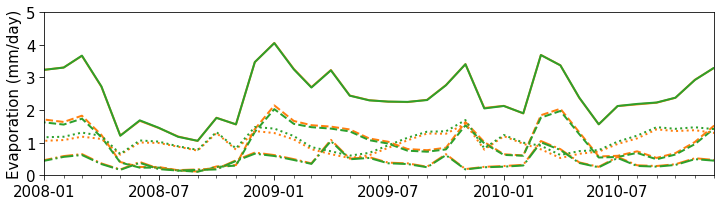

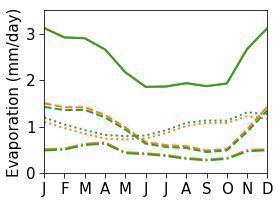

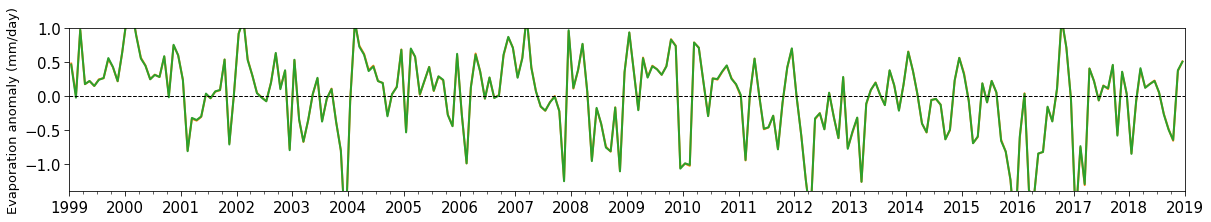

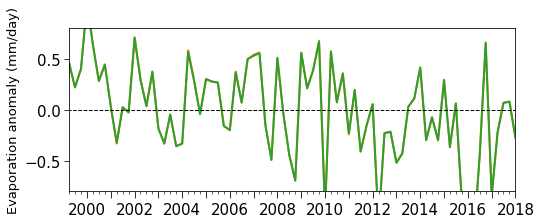

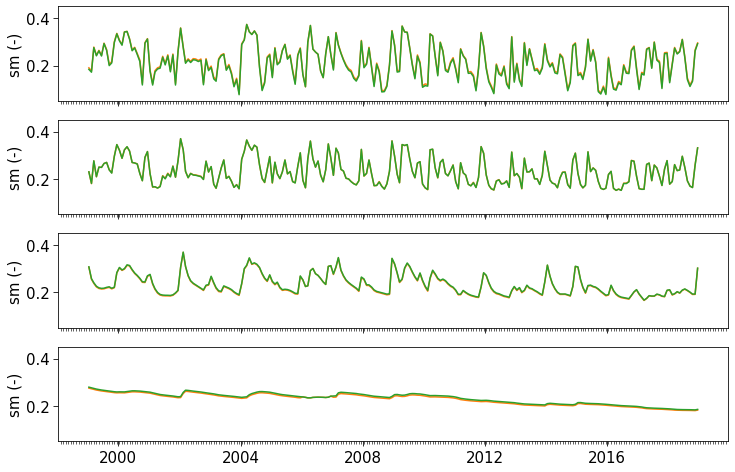

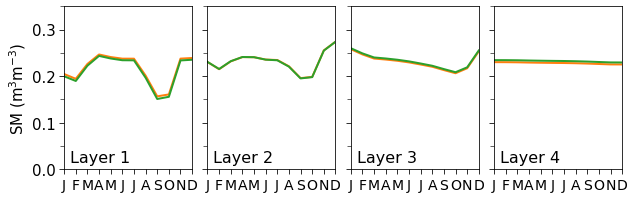

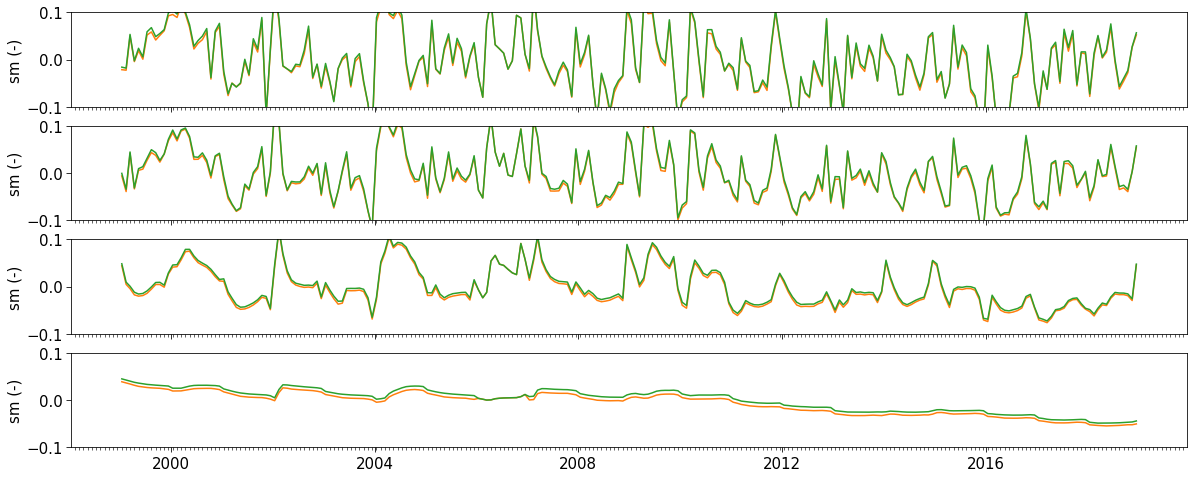

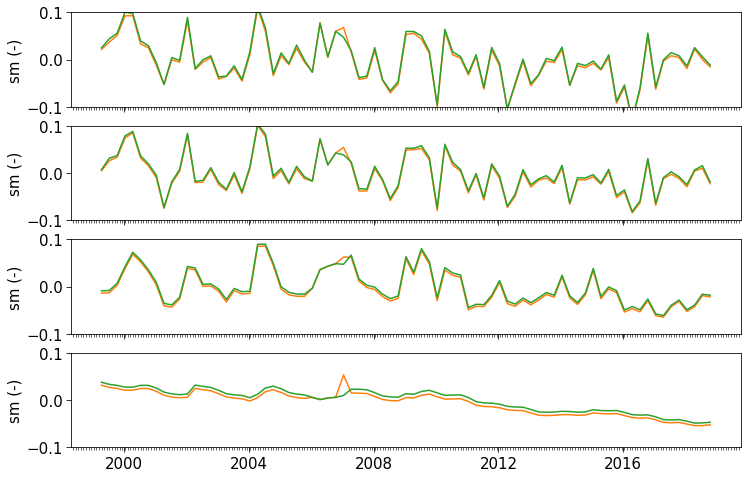

In [106]:
# point east brazil
# lat_min, lat_max = -16,-15
# lon_min, lon_max = 315,316
a=plot_ts_evapo(exp_name1,exp_name2,lat_min,lat_max,lon_min,lon_max,ymin=0,ymax=5)
b=plot_ts_evapo_climatology(exp_name1,exp_name2,lat_min,lat_max,lon_min,lon_max,ymin=0,ymax=3.5)
# plot_ts_evapo_climatology_leg(exp_name1,exp_name2,lat_min,lat_max,lon_min,lon_max,ymin=0,ymax=5)
df=plot_ec_e_anomaly_timeseries(exp_name1,exp_name2,lat_min,lat_max,lon_min,lon_max,ymin=-1.4,ymax=1)
print(df)
plot_lc_e_seasonal_anomaly_timeseries(exp_name1,exp_name2,lat_min,lat_max,lon_min,lon_max,ymin=-0.8,ymax=0.8)
dfs = std_seasons(exp_name1,exp_name2,lat_min,lat_max,lon_min,lon_max)
print(dfs)
plot_ts_sm(exp_name1,exp_name2,lat_min,lat_max,lon_min,lon_max,ymin=0.05,ymax=0.45)
plot_ts_sm_climatology(exp_name1,exp_name2,lat_min,lat_max,lon_min,lon_max,ymin=0,ymax=0.35)
# plot_ts_sm_climatology_leg(exp_name1,exp_name2,lat_min,lat_max,lon_min,lon_max,ymin=0,ymax=0.35)
plot_ts_sm_anomalies(exp_name1,exp_name2,lat_min,lat_max,lon_min,lon_max,ymin=-0.1,ymax=0.1)
plot_ts_sm_seasonal_anomalies(exp_name1,exp_name2,lat_min,lat_max,lon_min,lon_max,ymin=-0.1,ymax=0.1)
# plot_ts_sm('exp3','exp6',lat_min,lat_max,lon_min,lon_max,ymin=0,ymax=0.45)
em41,em42,es41,es42 = a[0],a[1],a[2],a[3]
e41am,e42am = a[4],a[5]

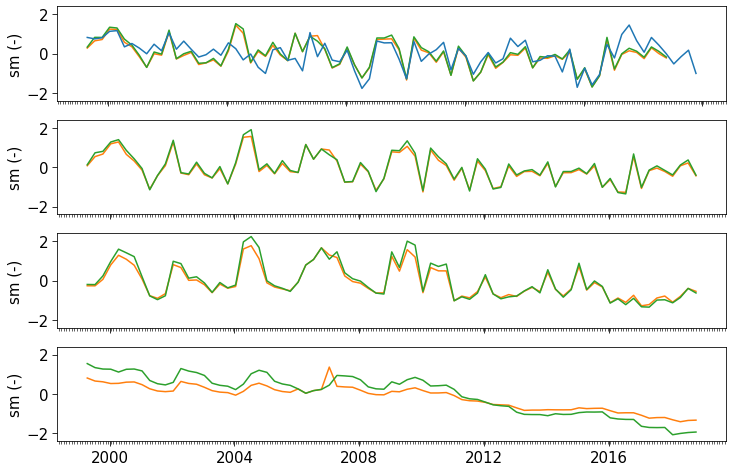

In [105]:
plot_ts_sm_seasonal_stdanomalies(exp_name1,exp_name2,lat_min,lat_max,lon_min,lon_max,ymin=-2.4,ymax=2.4)

In [ ]:
# great lakes
lat_min, lat_max = 47,48
lon_min, lon_max = 279,280
ymin,ymax=0.2,0.95
plon6,plat6 = plot_ts_rmse(exp_name1,exp_name2,rmse1,rmse2,rmse1_djf,rmse2_djf,rmse1_jja,rmse2_jja,fc,cv1,cv2,cvl1,cvh1,cvl2,cvh2,lat_min,lat_max,lon_min,lon_max,tvl,tvh,al,ah,ymin,ymax)
# plot_ts_rmse_anomalies(exp_name1,exp_name2,rmse1_djf,rmse2_djf,rmse1_jja,rmse2_jja,fc_ia,cv1_ia,cv2_ia,cvl1,cvh1,cvl2,cvh2,lat_min,lat_max,lon_min,lon_max,tvl,tvh,al,ah)


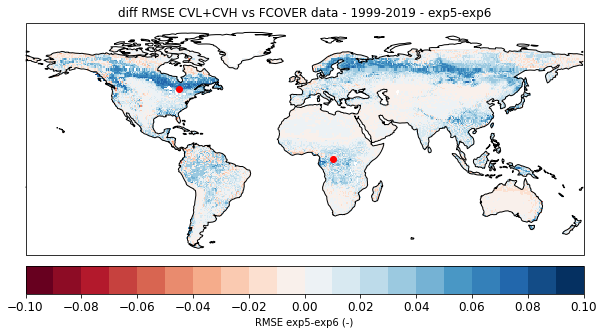

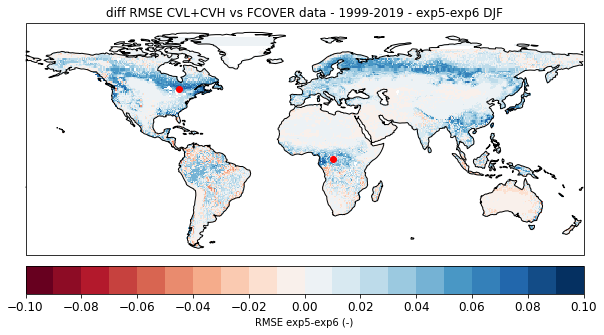

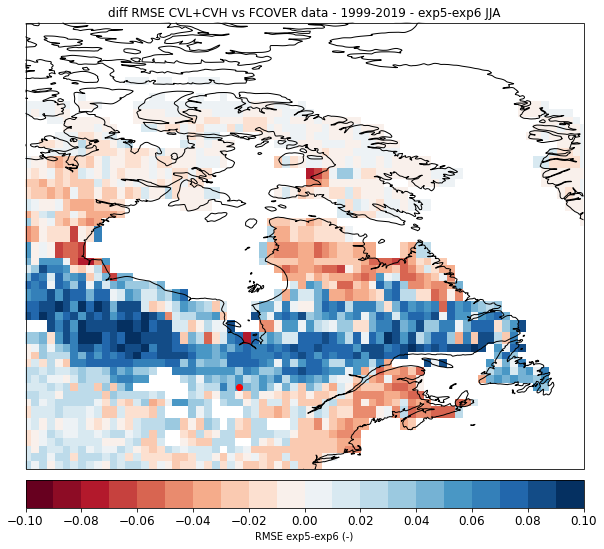

In [21]:
# make plots
exp_name1,exp_name2='exp5','exp6'
# RMSE
# all months
cm = plt.cm.get_cmap('RdBu')
lvls= np.linspace(-0.1,0.1,21)
lvls2= np.linspace(-0.1,0.1,11)
fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
cf = rmse.plot(ax=ax, cmap=cm, add_colorbar=False, vmin=0, vmax=5, levels=lvls)
cbar = plt.colorbar(cf, orientation='horizontal',label=f'RMSE {exp_name1}-{exp_name2} (-)', pad=0.02, ticks=lvls2)
cbar.ax.tick_params(labelsize=12)
# ax.plot(plon1,plat1,'ro')
ax.plot(plon2,plat2,'ro')
# ax.plot(plon3,plat3,'ro')
# ax.plot(plon4,plat4,'ro')
# ax.plot(plon5,plat5,'ro')
ax.plot(plon6,plat6,'ro')
# ax.plot(plon7,plat7,'ro')
ax.set_title(f'diff RMSE CVL+CVH vs FCOVER data - {start_year}-{end_year} - {exp_name1}-{exp_name2}')
ax.set_ylim(-60,90)
ax.set_xlim(-180,180)
fig.savefig(f'/home/vanoorschot/work/fransje/scripts/HTESSEL/figures/paper_figures/cvh_cvl/{exp_name1}_{exp_name2}/rmse_annual_cv_fcover_{start_year}-{end_year}_{exp_name1}_{exp_name2}.jpg',dpi=300,bbox_inches='tight')
# fig.savefig(f'/home/vanoorschot/work/fransje/scripts/HTESSEL/figures/paper_figures/cvh_cvl/{exp_name1}_{exp_name2}/rmse_annual_cv_fcover_{start_year}-{end_year}_{exp_name1}_{exp_name2}_withoutpoints.jpg',dpi=300,bbox_inches='tight')


# DJF
cm = plt.cm.get_cmap('RdBu')
lvls= np.linspace(-0.1,0.1,21)
lvls2= np.linspace(-0.1,0.1,11)
fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
cf = rmse_djf.plot(ax=ax, cmap=cm, add_colorbar=False, vmin=0, vmax=5, levels=lvls)
cbar = plt.colorbar(cf, orientation='horizontal',label=f'RMSE {exp_name1}-{exp_name2} (-)', pad=0.02, ticks=lvls2)
cbar.ax.tick_params(labelsize=12)
# ax.plot(plon1,plat1,'ro')
ax.plot(plon2,plat2,'ro')
# ax.plot(plon3,plat3,'ro')
# ax.plot(plon4,plat4,'ro')
# ax.plot(plon5,plat5,'ro')
ax.plot(plon6,plat6,'ro')
# ax.plot(plon7,plat7,'ro')
ax.set_title(f'diff RMSE CVL+CVH vs FCOVER data - {start_year}-{end_year} - {exp_name1}-{exp_name2} DJF')
ax.set_ylim(-60,90)
ax.set_xlim(-180,180)
fig.savefig(f'/home/vanoorschot/work/fransje/scripts/HTESSEL/figures/paper_figures/cvh_cvl/{exp_name1}_{exp_name2}/rmse_djf_cv_fcover_{start_year}-{end_year}_{exp_name1}_{exp_name2}.jpg',dpi=300,bbox_inches='tight')
# fig.savefig(f'/home/vanoorschot/work/fransje/scripts/HTESSEL/figures/paper_figures/cvh_cvl/{exp_name1}_{exp_name2}/rmse_djf_cv_fcover_{start_year}-{end_year}_{exp_name1}_{exp_name2}_withoutpoints.jpg',dpi=300,bbox_inches='tight')


# JJA
cm = plt.cm.get_cmap('RdBu')
lvls= np.linspace(-0.1,0.1,21)
lvls2= np.linspace(-0.1,0.1,11)
fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
cf = rmse_jja.plot(ax=ax, cmap=cm, add_colorbar=False, vmin=0, vmax=5, levels=lvls)
cbar = plt.colorbar(cf, orientation='horizontal',label=f'RMSE {exp_name1}-{exp_name2} (-)', pad=0.02, ticks=lvls2)
cbar.ax.tick_params(labelsize=12)
# ax.plot(plon1,plat1,'ro')
ax.plot(plon2,plat2,'ro')
# ax.plot(plon3,plat3,'ro')
# ax.plot(plon4,plat4,'ro')
# ax.plot(plon5,plat5,'ro')
ax.plot(plon6,plat6,'ro')
# ax.plot(plon7,plat7,'ro')
ax.set_title(f'diff RMSE CVL+CVH vs FCOVER data - {start_year}-{end_year} - {exp_name1}-{exp_name2} JJA')
ax.set_ylim(40,80)
ax.set_xlim(-100,-50)
# ax.set_ylim(-60,90)
# ax.set_xlim(-180,180)
fig.savefig(f'/home/vanoorschot/work/fransje/scripts/HTESSEL/figures/paper_figures/cvh_cvl/{exp_name1}_{exp_name2}/rmse_jja_cv_fcover_{start_year}-{end_year}_{exp_name1}_{exp_name2}.jpg',dpi=300,bbox_inches='tight')
# fig.savefig(f'/home/vanoorschot/work/fransje/scripts/HTESSEL/figures/paper_figures/cvh_cvl/{exp_name1}_{exp_name2}/rmse_jja_cv_fcover_{start_year}-{end_year}_{exp_name1}_{exp_name2}_withoutpoints.jpg',dpi=300,bbox_inches='tight')

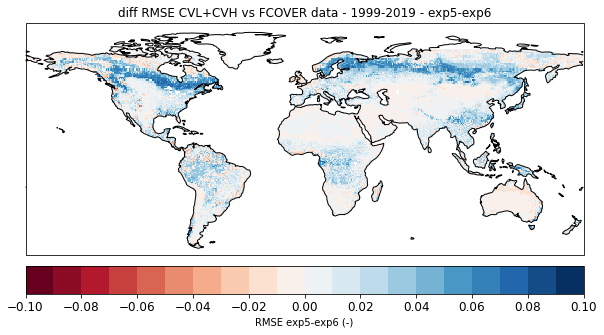

In [22]:
# make plots
# RMSE
# all months
cm = plt.cm.get_cmap('RdBu')
lvls= np.linspace(-0.1,0.1,21)
lvls2= np.linspace(-0.1,0.1,11)
fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
cf = rmse.plot(ax=ax, cmap=cm, add_colorbar=False, vmin=0, vmax=5, levels=lvls)
cbar = plt.colorbar(cf, orientation='horizontal',label=f'RMSE {exp_name1}-{exp_name2} (-)', pad=0.02, ticks=lvls2)
cbar.ax.tick_params(labelsize=12)
ax.set_title(f'diff RMSE CVL+CVH vs FCOVER data - {start_year}-{end_year} - {exp_name1}-{exp_name2}')
ax.set_ylim(-60,90)
ax.set_xlim(-180,180)
fig.savefig(f'/home/vanoorschot/work/fransje/scripts/HTESSEL/figures/paper_figures/cvh_cvl/{exp_name1}_{exp_name2}/rmse_annual_cv_fcover_{start_year}-{end_year}_{exp_name1}_{exp_name2}_nopoints.jpg',dpi=300,bbox_inches='tight')
# fig.savefig(f'/home/vanoorschot/work/fransje/scripts/HTESSEL/figures/paper_figures/cvh_cvl/{exp_name1}_{exp_name2}/rmse_annual_cv_fcover_{start_year}-{end_year}_{exp_name1}_{exp_name2}_withoutpoints.jpg',dpi=300,bbox_inches='tight')


In [23]:
# get RMSE mean values for different vegetation types

# veg type 3 with threshold 0.5
m = xr.open_dataset(f'{fol}/scripts/HTESSEL/landcover/mask_veg/mask_0.5_3.nc')
rmse_v = rmse1.where(m.cvh[0]>0.5)
rmse1_m = rmse_v.mean(dim=['lat','lon'])
print('rmse1 mean vt3 th0.5 = ',np.round(rmse1_m.values,3))
rmse_v = rmse2.where(m.cvh[0]>0.5)
rmse2_m = rmse_v.mean(dim=['lat','lon'])
print('rmse2 mean vt3 th0.5 = ',np.round(rmse2_m.values,3))

# veg type 6 with threshold 0.8
m = xr.open_dataset(f'{fol}/scripts/HTESSEL/landcover/mask_veg/mask_0.8_6.nc')
rmse_v = rmse1.where(m.cvh[0]>0.5)
rmse1_m = rmse_v.mean(dim=['lat','lon'])
print('rmse1 mean vt6 th0.8 = ',np.round(rmse1_m.values,3))
rmse_v = rmse2.where(m.cvh[0]>0.5)
rmse2_m = rmse_v.mean(dim=['lat','lon'])
print('rmse2 mean vt6 th0.8 = ',np.round(rmse2_m.values,3))

# veg type 9 with threshold 0.8
m = xr.open_dataset(f'{fol}/scripts/HTESSEL/landcover/mask_veg/mask_0.6_9.nc')
rmse_v = rmse1_jja.where(m.cvl[0]>0.5)
rmse1_m = rmse_v.mean(dim=['lat','lon'])
print('rmse1 JJA mean vt9 th0.6 = ',np.round(rmse1_m.values,3))
rmse_v = rmse2_jja.where(m.cvl[0]>0.5)
rmse2_m = rmse_v.mean(dim=['lat','lon'])
print('rmse2 JJA mean vt9 th0.6 = ',np.round(rmse2_m.values,3))

# veg type 1 with threshold 0.8
m = xr.open_dataset(f'{fol}/scripts/HTESSEL/landcover/mask_veg/mask_0.9_1.nc')
rmse_v = rmse1_jja.where(m.cvl[0]>0.85)
rmse1_m = rmse_v.mean(dim=['lat','lon'])
print('rmse1 JJA mean vt1 th0.9 = ',np.round(rmse1_m.values,3))
rmse_v = rmse2_jja.where(m.cvl[0]>0.85)
rmse2_m = rmse_v.mean(dim=['lat','lon'])
print('rmse2 JJA mean vt1 th0.9 = ',np.round(rmse2_m.values,3))

# veg type 2 with threshold 0.8
m = xr.open_dataset(f'{fol}/scripts/HTESSEL/landcover/mask_veg/mask_0.9_2.nc')
rmse_v = rmse1_jja.where(m.cvl[0]>0.5)
rmse1_m = rmse_v.mean(dim=['lat','lon'])
print('rmse1 JJA mean vt2 th0.9 = ',np.round(rmse1_m.values,3))
rmse_v = rmse2_jja.where(m.cvl[0]>0.5)
rmse2_m = rmse_v.mean(dim=['lat','lon'])
print('rmse2 JJA mean vt2 th0.9 = ',np.round(rmse2_m.values,3))

# veg type 1 with threshold 0.8
m = xr.open_dataset(f'{fol}/scripts/HTESSEL/landcover/mask_veg/mask_0.8_1.nc')
rmse_v = rmse1.where(m.cvl[0]>0.5)
rmse1_m = rmse_v.mean(dim=['lat','lon'])
print('rmse1 mean vt1 th0.8 = ',np.round(rmse1_m.values,3))
rmse_v = rmse2.where(m.cvl[0]>0.5)
rmse2_m = rmse_v.mean(dim=['lat','lon'])
print('rmse2 mean vt1 th0.8 = ',np.round(rmse2_m.values,3))

# veg type 2 with threshold 0.8
m = xr.open_dataset(f'{fol}/scripts/HTESSEL/landcover/mask_veg/mask_0.8_2.nc')
rmse_v = rmse1.where(m.cvl[0]>0.5)
rmse1_m = rmse_v.mean(dim=['lat','lon'])
print('rmse1 mean vt2 th0.8 = ',np.round(rmse1_m.values,3))
rmse_v = rmse2.where(m.cvl[0]>0.5)
rmse2_m = rmse_v.mean(dim=['lat','lon'])
print('rmse2 mean vt2 th0.8 = ',np.round(rmse2_m.values,3))

rmse1 mean vt3 th0.5 =  0.116
rmse2 mean vt3 th0.5 =  0.064
rmse1 mean vt6 th0.8 =  0.054
rmse2 mean vt6 th0.8 =  0.032
rmse1 JJA mean vt9 th0.6 =  0.026
rmse2 JJA mean vt9 th0.6 =  0.041
rmse1 JJA mean vt1 th0.9 =  0.055
rmse2 JJA mean vt1 th0.9 =  0.046
rmse1 JJA mean vt2 th0.9 =  0.039
rmse2 JJA mean vt2 th0.9 =  0.034
rmse1 mean vt1 th0.8 =  0.061
rmse2 mean vt1 th0.8 =  0.054
rmse1 mean vt2 th0.8 =  0.041
rmse2 mean vt2 th0.8 =  0.038


In [24]:
vt = [1,2,3,4,5,6,9,13,16,17]
exp_name1='exp5'
exp_name2='exp6'

df = pd.DataFrame(index=vt, columns=[f'med_rmse_{exp_name1}',f'med_rmse_{exp_name2}',f'mean_rmse_{exp_name1}',f'mean_rmse_{exp_name2}'])
d = pd.read_csv(f'/home/vanoorschot/work/fransje/scripts/HTESSEL/figures/cvh_cvl/{exp_name1}/veg_stat_tables/{exp_name1}_veg_stats_jja.csv',index_col=0)
df[f'med_rmse_{exp_name1}'] = d.median_rmse
df[f'mean_rmse_{exp_name1}'] = d.mean_rmse

d = pd.read_csv(f'/home/vanoorschot/work/fransje/scripts/HTESSEL/figures/cvh_cvl/{exp_name2}/veg_stat_tables/{exp_name2}_veg_stats_jja.csv',index_col=0)
df[f'med_rmse_{exp_name2}'] = d.median_rmse
df[f'mean_rmse_{exp_name2}'] = d.mean_rmse

df

med_rmse_exp5  med_rmse_exp6  mean_rmse_exp5  mean_rmse_exp6
1           0.047          0.039           0.056           0.049
2           0.045          0.038           0.057           0.049
3           0.058          0.043           0.068           0.054
4           0.059          0.045           0.064           0.055
5           0.036          0.032           0.044           0.042
6           0.052          0.037           0.063           0.048
9           0.019          0.027           0.026           0.037
13          0.064          0.043           0.073           0.053
16          0.055          0.020           0.064           0.030
17          0.032          0.027           0.042           0.035

In [25]:
df = pd.DataFrame(index=vt, columns=[f'med_rmse_{exp_name1}',f'med_rmse_{exp_name2}',f'mean_rmse_{exp_name1}',f'mean_rmse_{exp_name2}'])
d = pd.read_csv(f'/home/vanoorschot/work/fransje/scripts/HTESSEL/figures/cvh_cvl/{exp_name1}/veg_stat_tables/{exp_name1}_veg_stats_djf.csv',index_col=0)
df[f'med_rmse_{exp_name1}'] = d.median_rmse
df[f'mean_rmse_{exp_name1}'] = d.mean_rmse

d = pd.read_csv(f'/home/vanoorschot/work/fransje/scripts/HTESSEL/figures/cvh_cvl/{exp_name2}/veg_stat_tables/{exp_name2}_veg_stats_djf.csv',index_col=0)
df[f'med_rmse_{exp_name2}'] = d.median_rmse
df[f'mean_rmse_{exp_name2}'] = d.mean_rmse

df

med_rmse_exp5  med_rmse_exp6  mean_rmse_exp5  mean_rmse_exp6
1           0.042          0.032           0.050           0.039
2           0.036          0.026           0.048           0.034
3           0.054          0.030           0.061           0.036
4           0.036          0.024           0.043           0.029
5           0.029          0.024           0.037           0.030
6           0.051          0.037           0.062           0.048
9           0.011          0.008           0.013           0.010
13          0.081          0.038           0.085           0.047
16          0.050          0.014           0.060           0.027
17          0.031          0.027           0.038           0.033

In [26]:
df = pd.DataFrame(index=vt, columns=[f'med_rmse_{exp_name1}',f'med_rmse_{exp_name2}',f'mean_rmse_{exp_name1}',f'mean_rmse_{exp_name2}'])
d = pd.read_csv(f'/home/vanoorschot/work/fransje/scripts/HTESSEL/figures/cvh_cvl/{exp_name1}/veg_stat_tables/{exp_name1}_veg_stats.csv',index_col=0)
df[f'med_rmse_{exp_name1}'] = d.median_rmse
df[f'mean_rmse_{exp_name1}'] = d.mean_rmse

d = pd.read_csv(f'/home/vanoorschot/work/fransje/scripts/HTESSEL/figures/cvh_cvl/{exp_name2}/veg_stat_tables/{exp_name2}_veg_stats.csv',index_col=0)
df[f'med_rmse_{exp_name2}'] = d.median_rmse
df[f'mean_rmse_{exp_name2}'] = d.mean_rmse

df

med_rmse_exp5  med_rmse_exp6  mean_rmse_exp5  mean_rmse_exp6
1           0.056          0.047           0.060           0.052
2           0.052          0.042           0.059           0.046
3           0.067          0.046           0.071           0.049
4           0.057          0.043           0.062           0.047
5           0.044          0.039           0.048           0.043
6           0.057          0.045           0.067           0.052
9           0.022          0.020           0.023           0.024
13          0.089          0.048           0.093           0.057
16          0.053          0.019           0.062           0.031
17          0.038          0.033           0.045           0.039

In [38]:
def plot_ts_sm(exp_name1,exp_name2,lat_min,lat_max,lon_min,lon_max,ymin,ymax):
    f_mod1 = f'{fol}/htessel_output/{exp_name1}'
    f_mod2 = f'{fol}/htessel_output/{exp_name2}'
    mod1 = xr.open_dataset(f'{f_mod1}/monthly/o_soil_{start_year}_{end_year}_monthly.nc')
    mod2 = xr.open_dataset(f'{f_mod2}/monthly/o_soil_{start_year}_{end_year}_monthly.nc')
    # mod1 = mod1.where(fc)
    # mod2 = mod2.where(fc)

    sm11 = mod1.SWVL1 #* 0.07 * 1e3 # 7cm
    sm21 = mod1.SWVL2 #* 0.21 * 1e3 # 21cm
    sm31 = mod1.SWVL3 #* 0.72 * 1e3 # 72 cm
    sm41 = mod1.SWVL4 #* 1.89 * 1e3 # 189 cm

    sm12 = mod2.SWVL1 #* 0.07 * 1e3 # 7cm
    sm22 = mod2.SWVL2 #* 0.21 * 1e3 # 21cm
    sm32 = mod2.SWVL3 #* 0.72 * 1e3 # 72 cm
    sm42 = mod2.SWVL4 #* 1.89 * 1e3 # 189 cm
    
    lat_ix1,lon_ix1,latstr1,lonstr1 = select_point(sm11,lat_min,lat_max,lon_min,lon_max)

    sm11 = sm11[:,lat_ix1,lon_ix1]
    sm21 = sm21[:,lat_ix1,lon_ix1]
    sm31 = sm31[:,lat_ix1,lon_ix1]
    sm41 = sm41[:,lat_ix1,lon_ix1]
    sm1m = sm11+sm21+sm31
    sm1tot = sm11+sm21+sm31+sm41 

    sm12 = sm12[:,lat_ix1,lon_ix1]
    sm22 = sm22[:,lat_ix1,lon_ix1]
    sm32 = sm32[:,lat_ix1,lon_ix1]
    sm42 = sm42[:,lat_ix1,lon_ix1]
    sm2m = sm12+sm22+sm32
    sm2tot = sm12+sm22+sm32+sm42 
    
    # correct 2006
    sm11[84:96] = sm12[84:96]
    sm21[84:96] = sm22[84:96]
    sm31[84:96] = sm32[84:96]
    sm41[84:96] = sm42[84:96]
    
#     f1 = sm11[0:83].groupby('time.month').mean('time')
#     f2 = sm12[0:83].groupby('time.month').mean('time')
#     f = (f1/f2).values
#     sm11[84:96] = sm12[84:96]* f

#     f1 = sm21[0:83].groupby('time.month').mean('time')
#     f2 = sm22[0:83].groupby('time.month').mean('time')
#     f = (f1/f2).values
#     sm21[84:96] = sm22[84:96]* f

#     f1 = sm31[0:83].groupby('time.month').mean('time')
#     f2 = sm32[0:83].groupby('time.month').mean('time')
#     f = (f1/f2).values
#     sm31[84:96] = sm32[84:96]* f

#     f1 = sm41[0:83].groupby('time.month').mean('time')
#     f2 = sm42[0:83].groupby('time.month').mean('time')
#     f = (f1/f2).values
#     sm41[84:96] = sm42[84:96]* f

    fig = plt.figure(figsize=(12,8))
    ax = fig.add_subplot(411)
    ax.plot(sm11.time, sm11, label=f'sm1 {exp_name1}',color='tab:orange')
    ax.plot(sm12.time, sm12, label=f'sm1 {exp_name2}',color='tab:green')
    # ax.set_title(f'soil moisture - lat={latstr1}, lon={lonstr1}')
    # ax.set_ylabel('sm (mm)')
    ax.set_ylabel('sm (-)',size=15)
    ax.set_ylim(ymin,ymax)
    # ax.set_xlim('2008-01-15','2010-12-15')
    ax.set_xticklabels([])
    ax.xaxis.set_minor_locator(mdates.DayLocator(bymonthday=15))
    ax.tick_params(axis='x', which='major',length=5, labelsize=15)
    ax.tick_params(axis='x', which='minor',length=3, labelsize=15)
    ax.tick_params(axis='y', which='major',length=5, labelsize=15)
    # ax.legend()

    ax = fig.add_subplot(412)
    ax.plot(sm21.time, sm21, label=f'sm2 {exp_name1}',color='tab:orange')
    ax.plot(sm22.time, sm22, label=f'sm2 {exp_name2}',color='tab:green')
    # ax.set_title(f'soil moisture L2 - lat={latstr1}, lon={lonstr1} - detrend {dt} - {tp}')
    # ax.set_ylabel('sm (mm)')
    ax.set_ylabel('sm (-)',size=15)
    ax.set_ylim(ymin,ymax)
    # ax.set_xlim('2008-01-15','2010-12-15')
    ax.set_xticklabels([])
    ax.xaxis.set_minor_locator(mdates.DayLocator(bymonthday=15))
    ax.tick_params(axis='x', which='major',length=5, labelsize=15)
    ax.tick_params(axis='x', which='minor',length=3, labelsize=15)
    ax.tick_params(axis='y', which='major',length=5, labelsize=15)
    # ax.legend()

    ax = fig.add_subplot(413)
    ax.plot(sm31.time, sm31, label=f'sm3 {exp_name1}',color='tab:orange')
    ax.plot(sm32.time, sm32, label=f'sm3 {exp_name2}',color='tab:green')
    # ax.set_title(f'soil moisture L3 - lat={latstr1}, lon={lonstr1} - detrend {dt} - {tp}')
    # ax.set_ylabel('sm (mm)')
    ax.set_ylabel('sm (-)',size=15)
    ax.set_ylim(ymin,ymax)
    ax.set_xticklabels([])
    # ax.set_xlim('2008-01-15','2010-12-15')
    ax.xaxis.set_minor_locator(mdates.DayLocator(bymonthday=15))
    ax.tick_params(axis='x', which='major',length=5, labelsize=15)
    ax.tick_params(axis='x', which='minor',length=3, labelsize=15)
    ax.tick_params(axis='y', which='major',length=5, labelsize=15)
    # ax.legend()

    ax = fig.add_subplot(414)
    ax.plot(sm41.time, sm41, label=f'sm4 {exp_name1}',color='tab:orange')
    ax.plot(sm42.time, sm42, label=f'sm4 {exp_name2}',color='tab:green')
    # ax.set_title(f'soil moisture L4 - lat={latstr1}, lon={lonstr1} - detrend {dt} - {tp}')
    # ax.set_ylabel('sm (mm)')
    ax.set_ylabel('sm (-)',size=15)
    ax.set_ylim(ymin,ymax)
    # ax.set_xlim('2008-01-15','2010-12-15')
    # ax.set_xticks(['2008-01-15','2008-07-15','2009-01-15','2009-07-15','2010-01-15','2010-07-15'])
    # ax.set_xticklabels(['2008-01','2008-07','2009-01','2009-07','2010-01','2010-07'])
    ax.xaxis.set_minor_locator(mdates.DayLocator(bymonthday=15))
    ax.tick_params(axis='x', which='major',length=5, labelsize=15)
    ax.tick_params(axis='x', which='minor',length=3, labelsize=15)
    ax.tick_params(axis='y', which='major',length=5, labelsize=15)
    # ax.legend()

    fig.savefig(f'/home/vanoorschot/work/fransje/scripts/HTESSEL/figures/paper_figures/{exp_name1}_{exp_name2}/timeseries_soilmoisture_lat{latstr1}_lon{lonstr1}.jpg',dpi=300,bbox_inches='tight')

In [39]:
def plot_ts_sm_anomalies(exp_name1,exp_name2,lat_min,lat_max,lon_min,lon_max,ymin,ymax):
    f_mod1 = f'{fol}/htessel_output/{exp_name1}'
    f_mod2 = f'{fol}/htessel_output/{exp_name2}'
    mod1 = xr.open_dataset(f'{f_mod1}/ia_anomalies/o_soil_{start_year}_{end_year}_ia_anomalies.nc')
    mod2 = xr.open_dataset(f'{f_mod2}/ia_anomalies/o_soil_{start_year}_{end_year}_ia_anomalies.nc')
    # mod1 = mod1.where(fc)
    # mod2 = mod2.where(fc)

    sm11 = mod1.SWVL1 #* 0.07 * 1e3 # 7cm
    sm21 = mod1.SWVL2 #* 0.21 * 1e3 # 21cm
    sm31 = mod1.SWVL3 #* 0.72 * 1e3 # 72 cm
    sm41 = mod1.SWVL4 #* 1.89 * 1e3 # 189 cm

    sm12 = mod2.SWVL1 #* 0.07 * 1e3 # 7cm
    sm22 = mod2.SWVL2 #* 0.21 * 1e3 # 21cm
    sm32 = mod2.SWVL3 #* 0.72 * 1e3 # 72 cm
    sm42 = mod2.SWVL4 #* 1.89 * 1e3 # 189 cm
    
    lat_ix1,lon_ix1,latstr1,lonstr1 = select_point(sm11,lat_min,lat_max,lon_min,lon_max)

    sm11 = sm11[:,lat_ix1,lon_ix1]
    sm21 = sm21[:,lat_ix1,lon_ix1]
    sm31 = sm31[:,lat_ix1,lon_ix1]
    sm41 = sm41[:,lat_ix1,lon_ix1]
    sm1m = sm11+sm21+sm31
    sm1tot = sm11+sm21+sm31+sm41 

    sm12 = sm12[:,lat_ix1,lon_ix1]
    sm22 = sm22[:,lat_ix1,lon_ix1]
    sm32 = sm32[:,lat_ix1,lon_ix1]
    sm42 = sm42[:,lat_ix1,lon_ix1]
    sm2m = sm12+sm22+sm32
    sm2tot = sm12+sm22+sm32+sm42 
    
        # correct 2006
    sm11[84:96] = sm12[84:96]
    sm21[84:96] = sm22[84:96]
    sm31[84:96] = sm32[84:96]
    sm41[84:96] = sm42[84:96]
#     f1 = sm11[0:83].groupby('time.month').mean('time')
#     f2 = sm12[0:83].groupby('time.month').mean('time')
#     f = (f1/f2).values
#     sm11[84:96] = sm12[84:96]* f

#     f1 = sm21[0:83].groupby('time.month').mean('time')
#     f2 = sm22[0:83].groupby('time.month').mean('time')
#     f = (f1/f2).values
#     sm21[84:96] = sm22[84:96]* f

#     f1 = sm31[0:83].groupby('time.month').mean('time')
#     f2 = sm32[0:83].groupby('time.month').mean('time')
#     f = (f1/f2).values
#     sm31[84:96] = sm32[84:96]* f

#     f1 = sm41[0:83].groupby('time.month').mean('time')
#     f2 = sm42[0:83].groupby('time.month').mean('time')
#     f = (f1/f2).values
#     sm41[84:96] = sm42[84:96]* f

    fig = plt.figure(figsize=(20,8))
    ax = fig.add_subplot(411)
    ax.plot(sm11.time, sm11, label=f'sm1 {exp_name1}',color='tab:orange')
    ax.plot(sm12.time, sm12, label=f'sm1 {exp_name2}',color='tab:green')
    # ax.set_title(f'soil moisture - lat={latstr1}, lon={lonstr1}')
    # ax.set_ylabel('sm (mm)')
    ax.set_ylabel('sm (-)',size=15)
    ax.set_ylim(ymin,ymax)
    # ax.set_xlim('2008-01-15','2010-12-15')
    ax.set_xticklabels([])
    ax.xaxis.set_minor_locator(mdates.DayLocator(bymonthday=15))
    ax.tick_params(axis='x', which='major',length=5, labelsize=15)
    ax.tick_params(axis='x', which='minor',length=3, labelsize=15)
    ax.tick_params(axis='y', which='major',length=5, labelsize=15)
    # ax.legend()

    ax = fig.add_subplot(412)
    ax.plot(sm21.time, sm21, label=f'sm2 {exp_name1}',color='tab:orange')
    ax.plot(sm22.time, sm22, label=f'sm2 {exp_name2}',color='tab:green')
    # ax.set_title(f'soil moisture L2 - lat={latstr1}, lon={lonstr1} - detrend {dt} - {tp}')
    # ax.set_ylabel('sm (mm)')
    ax.set_ylabel('sm (-)',size=15)
    ax.set_ylim(ymin,ymax)
    # ax.set_xlim('2008-01-15','2010-12-15')
    ax.set_xticklabels([])
    ax.xaxis.set_minor_locator(mdates.DayLocator(bymonthday=15))
    ax.tick_params(axis='x', which='major',length=5, labelsize=15)
    ax.tick_params(axis='x', which='minor',length=3, labelsize=15)
    ax.tick_params(axis='y', which='major',length=5, labelsize=15)
    # ax.legend()

    ax = fig.add_subplot(413)
    ax.plot(sm31.time, sm31, label=f'sm3 {exp_name1}',color='tab:orange')
    ax.plot(sm32.time, sm32, label=f'sm3 {exp_name2}',color='tab:green')
    # ax.set_title(f'soil moisture L3 - lat={latstr1}, lon={lonstr1} - detrend {dt} - {tp}')
    # ax.set_ylabel('sm (mm)')
    ax.set_ylabel('sm (-)',size=15)
    ax.set_ylim(ymin,ymax)
    ax.set_xticklabels([])
    # ax.set_xlim('2008-01-15','2010-12-15')
    ax.xaxis.set_minor_locator(mdates.DayLocator(bymonthday=15))
    ax.tick_params(axis='x', which='major',length=5, labelsize=15)
    ax.tick_params(axis='x', which='minor',length=3, labelsize=15)
    ax.tick_params(axis='y', which='major',length=5, labelsize=15)
    # ax.legend()

    ax = fig.add_subplot(414)
    ax.plot(sm41.time, sm41, label=f'sm4 {exp_name1}',color='tab:orange')
    ax.plot(sm42.time, sm42, label=f'sm4 {exp_name2}',color='tab:green')
    # ax.set_title(f'soil moisture L4 - lat={latstr1}, lon={lonstr1} - detrend {dt} - {tp}')
    # ax.set_ylabel('sm (mm)')
    ax.set_ylabel('sm (-)',size=15)
    ax.set_ylim(ymin,ymax)
    # ax.set_xlim('2008-01-15','2010-12-15')
    # ax.set_xticks(['2008-01-15','2008-07-15','2009-01-15','2009-07-15','2010-01-15','2010-07-15'])
    # ax.set_xticklabels(['2008-01','2008-07','2009-01','2009-07','2010-01','2010-07'])
    ax.xaxis.set_minor_locator(mdates.DayLocator(bymonthday=15))
    ax.tick_params(axis='x', which='major',length=5, labelsize=15)
    ax.tick_params(axis='x', which='minor',length=3, labelsize=15)
    ax.tick_params(axis='y', which='major',length=5, labelsize=15)
    # ax.legend()

    fig.savefig(f'/home/vanoorschot/work/fransje/scripts/HTESSEL/figures/paper_figures/{exp_name1}_{exp_name2}/timeseries_soilmoisture_anomalies_lat{latstr1}_lon{lonstr1}.jpg',dpi=300,bbox_inches='tight')

In [40]:
def plot_ts_sm_climatology(exp_name1,exp_name2,lat_min,lat_max,lon_min,lon_max,ymin,ymax):
    f_mod1 = f'{fol}/htessel_output/{exp_name1}'
    f_mod2 = f'{fol}/htessel_output/{exp_name2}'
    mod1 = xr.open_dataset(f'{f_mod1}/monthly/o_soil_{start_year}_{end_year}_monthly.nc')
    mod2 = xr.open_dataset(f'{f_mod2}/monthly/o_soil_{start_year}_{end_year}_monthly.nc')
    # mod1 = mod1.where(fc)
    # mod2 = mod2.where(fc)

#     sm11 = mod1.SWVL1[96:] #* 0.07 * 1e3 # 7cm #something seems wrong with the year 2006
#     sm21 = mod1.SWVL2[96:] #* 0.21 * 1e3 # 21cm
#     sm31 = mod1.SWVL3[96:] #* 0.72 * 1e3 # 72 cm
#     sm41 = mod1.SWVL4[96:] #* 1.89 * 1e3 # 189 cm

#     sm12 = mod2.SWVL1[96:] #* 0.07 * 1e3 # 7cm
#     sm22 = mod2.SWVL2[96:] #* 0.21 * 1e3 # 21cm
#     sm32 = mod2.SWVL3[96:] #* 0.72 * 1e3 # 72 cm
#     sm42 = mod2.SWVL4[96:] #* 1.89 * 1e3 # 189 cm
    
    sm11 = mod1.SWVL1 #* 0.07 * 1e3 # 7cm
    sm21 = mod1.SWVL2 #* 0.21 * 1e3 # 21cm
    sm31 = mod1.SWVL3 #* 0.72 * 1e3 # 72 cm
    sm41 = mod1.SWVL4 #* 1.89 * 1e3 # 189 cm

    sm12 = mod2.SWVL1 #* 0.07 * 1e3 # 7cm
    sm22 = mod2.SWVL2 #* 0.21 * 1e3 # 21cm
    sm32 = mod2.SWVL3 #* 0.72 * 1e3 # 72 cm
    sm42 = mod2.SWVL4 #* 1.89 * 1e3 # 189 cm
    
    lat_ix1,lon_ix1,latstr1,lonstr1 = select_point(sm11,lat_min,lat_max,lon_min,lon_max)

    sm11 = sm11[:,lat_ix1,lon_ix1]
    sm21 = sm21[:,lat_ix1,lon_ix1]
    sm31 = sm31[:,lat_ix1,lon_ix1]
    sm41 = sm41[:,lat_ix1,lon_ix1]
    sm1m = sm11+sm21+sm31
    sm1tot = sm11+sm21+sm31+sm41 

    sm12 = sm12[:,lat_ix1,lon_ix1]
    sm22 = sm22[:,lat_ix1,lon_ix1]
    sm32 = sm32[:,lat_ix1,lon_ix1]
    sm42 = sm42[:,lat_ix1,lon_ix1]
    # correct 2006
    sm11[84:96] = sm12[84:96]
    sm21[84:96] = sm22[84:96]
    sm31[84:96] = sm32[84:96]
    sm41[84:96] = sm42[84:96]
    
    sm11m = sm11.groupby('time.month').mean('time')
    sm21m = sm21.groupby('time.month').mean('time')
    sm31m = sm31.groupby('time.month').mean('time')
    sm41m = sm41.groupby('time.month').mean('time')
    
    sm12m = sm12.groupby('time.month').mean('time')
    sm22m = sm22.groupby('time.month').mean('time')
    sm32m = sm32.groupby('time.month').mean('time')
    sm42m = sm42.groupby('time.month').mean('time')
    sm2m = sm12+sm22+sm32
    sm2tot = sm12+sm22+sm32+sm42 
    


#     f1 = sm11[0:83].groupby('time.month').mean('time')
#     f2 = sm12[0:83].groupby('time.month').mean('time')
#     f = (f1/f2).values
#     sm11[84:96] = sm12[84:96]* f

#     f1 = sm21[0:83].groupby('time.month').mean('time')
#     f2 = sm22[0:83].groupby('time.month').mean('time')
#     f = (f1/f2).values
#     sm21[84:96] = sm22[84:96]* f

#     f1 = sm31[0:83].groupby('time.month').mean('time')
#     f2 = sm32[0:83].groupby('time.month').mean('time')
#     f = (f1/f2).values
#     sm31[84:96] = sm32[84:96]* f

#     f1 = sm41[0:83].groupby('time.month').mean('time')
#     f2 = sm42[0:83].groupby('time.month').mean('time')
#     f = (f1/f2).values
#     sm41[84:96] = sm42[84:96]* f

    fig = plt.figure(figsize=(10,3))
    fig.tight_layout(pad=0.3)
    fig.subplots_adjust(wspace=0.12)
    ax = fig.add_subplot(141)
    ax.plot(sm11m.month, sm11m, label=f'sm1 {exp_name1}',color='tab:orange',linewidth=2)
    ax.plot(sm12m.month, sm12m, label=f'sm1 {exp_name2}',color='tab:green',linewidth=2)
    # ax.set_title(f'soil moisture - lat={latstr1}, lon={lonstr1}')
    # ax.set_ylabel('sm (mm)')
    ax.set_ylabel('SM ($\mathrm{m^3} \mathrm{m^{-3}}$)',size=15)
    ax.set_ylim(ymin,ymax)
    ax.set_xlim(1,12)
    # ax.set_xlim('2008-01-15','2010-12-15')
    ax.set_xticks([1,2,3,4,5,6,7,8,9,10,11,12])
    ax.set_xticklabels([])
    ax.set_yticks(np.arange(ymin,ymax+0.01,0.1))
    ax.set_xticklabels(['J','F','M','A','M','J','J','A','S','O','N','D'])
    ax.xaxis.set_minor_locator(mdates.DayLocator(bymonthday=15))
    ax.yaxis.set_minor_locator(MultipleLocator(0.05))
    ax.annotate('Layer 1',(1.5,ymin+0.015),size=16)
    ax.tick_params(axis='x', which='major',length=5, labelsize=14)
    ax.tick_params(axis='x', which='minor',length=3, labelsize=15)
    ax.tick_params(axis='y', which='major',length=5, labelsize=15)
    ax.tick_params(axis='y', which='minor',length=4, labelsize=15)
    # ax.legend()

    ax = fig.add_subplot(142)
    ax.plot(sm21m.month, sm21m, label=f'sm2 {exp_name1}',color='tab:orange',linewidth=2)
    ax.plot(sm22m.month, sm22m, label=f'sm2 {exp_name2}',color='tab:green',linewidth=2)
    # ax.set_title(f'soil moisture L2 - lat={latstr1}, lon={lonstr1} - detrend {dt} - {tp}')
    # ax.set_ylabel('sm (mm)')
    # ax.set_ylabel('sm (-)',size=15)
    ax.set_ylim(ymin,ymax)
    ax.set_yticks(np.arange(ymin,ymax+0.01,0.1))
    # ax.set_xlim('2008-01-15','2010-12-15')
    ax.set_xticklabels([])
    ax.set_xlim(1,12)
    ax.set_xticks([1,2,3,4,5,6,7,8,9,10,11,12])
    ax.set_yticklabels([])
    # ax.set_yticks([1,2,3,4,5,6,7,8,9,10,11,12])
    ax.set_xticklabels(['J','F','M','A','M','J','J','A','S','O','N','D'])
    ax.yaxis.set_minor_locator(MultipleLocator(0.05))
    ax.annotate('Layer 2',(1.5,ymin+0.015),size=16)
    ax.tick_params(axis='x', which='major',length=5, labelsize=14)
    ax.tick_params(axis='x', which='minor',length=3, labelsize=15)
    ax.tick_params(axis='y', which='major',length=5, labelsize=15)
    ax.tick_params(axis='y', which='minor',length=4, labelsize=15)
    # ax.legend()

    ax = fig.add_subplot(143)
    ax.plot(sm31m.month, sm31m, label=f'sm3 {exp_name1}',color='tab:orange',linewidth=2)
    ax.plot(sm32m.month, sm32m, label=f'sm3 {exp_name2}',color='tab:green',linewidth=2)
    # ax.set_title(f'soil moisture L3 - lat={latstr1}, lon={lonstr1} - detrend {dt} - {tp}')
    # ax.set_ylabel('SM ($m^3 m^{-3}$)',size=15)
    ax.set_ylim(ymin,ymax)
    ax.set_xlim(1,12)
    ax.set_yticks(np.arange(ymin,ymax+0.01,0.1))
    # ax.set_xlim('2008-01-15','2010-12-15')
    ax.set_xticks([1,2,3,4,5,6,7,8,9,10,11,12])
    ax.set_yticklabels([])
    ax.set_xticklabels(['J','F','M','A','M','J','J','A','S','O','N','D'])
    ax.yaxis.set_minor_locator(MultipleLocator(0.05))
    ax.annotate('Layer 3',(1.5,ymin+0.015),size=16)
    ax.tick_params(axis='x', which='major',length=5, labelsize=14)
    ax.tick_params(axis='x', which='minor',length=3, labelsize=15)
    ax.tick_params(axis='y', which='major',length=5, labelsize=15)
    ax.tick_params(axis='y', which='minor',length=4, labelsize=15)
    # ax.legend()

    ax = fig.add_subplot(144)
    ax.plot(sm41m.month, sm41m, label=f'sm4 {exp_name1}',color='tab:orange',linewidth=2)
    ax.plot(sm42m.month, sm42m, label=f'sm4 {exp_name2}',color='tab:green',linewidth=2)
    # ax.set_title(f'soil moisture L4 - lat={latstr1}, lon={lonstr1} - detrend {dt} - {tp}')
    # ax.set_ylabel('sm (mm)')
    # ax.set_ylabel('sm (-)',size=15)
    ax.set_ylim(ymin,ymax)
    ax.set_xlim(1,12)
    ax.set_yticks(np.arange(ymin,ymax+0.01,0.1))
    ax.set_xticks([1,2,3,4,5,6,7,8,9,10,11,12])
    ax.set_xticklabels(['J','F','M','A','M','J','J','A','S','O','N','D'])
    ax.set_yticklabels([])
    ax.xaxis.set_minor_locator(mdates.DayLocator(bymonthday=15))
    ax.yaxis.set_minor_locator(MultipleLocator(0.05))
    ax.annotate('Layer 4',(1.5,ymin+0.015),size=16)
    ax.tick_params(axis='x', which='major',length=5, labelsize=14)
    ax.tick_params(axis='x', which='minor',length=3, labelsize=15)
    ax.tick_params(axis='y', which='major',length=5, labelsize=15)
    ax.tick_params(axis='y', which='minor',length=4, labelsize=15)
    fig.savefig(f'/home/vanoorschot/work/fransje/scripts/HTESSEL/figures/paper_figures/{exp_name1}_{exp_name2}/timeseries_soilmoisture_climatology_lat{latstr1}_lon{lonstr1}.jpg',dpi=300,bbox_inches='tight')

In [41]:
def plot_ts_sm_climatology_leg(exp_name1,exp_name2,lat_min,lat_max,lon_min,lon_max,ymin,ymax):
    f_mod1 = f'{fol}/htessel_output/{exp_name1}'
    f_mod2 = f'{fol}/htessel_output/{exp_name2}'
    mod1 = xr.open_dataset(f'{f_mod1}/monthly/o_soil_{start_year}_{end_year}_monthly.nc')
    mod2 = xr.open_dataset(f'{f_mod2}/monthly/o_soil_{start_year}_{end_year}_monthly.nc')
    
    sm11 = mod1.SWVL1 #* 0.07 * 1e3 # 7cm
    sm21 = mod1.SWVL2 #* 0.21 * 1e3 # 21cm
    sm31 = mod1.SWVL3 #* 0.72 * 1e3 # 72 cm
    sm41 = mod1.SWVL4 #* 1.89 * 1e3 # 189 cm

    sm12 = mod2.SWVL1 #* 0.07 * 1e3 # 7cm
    sm22 = mod2.SWVL2 #* 0.21 * 1e3 # 21cm
    sm32 = mod2.SWVL3 #* 0.72 * 1e3 # 72 cm
    sm42 = mod2.SWVL4 #* 1.89 * 1e3 # 189 cm
    
    lat_ix1,lon_ix1,latstr1,lonstr1 = select_point(sm11,lat_min,lat_max,lon_min,lon_max)

    sm11 = sm11[:,lat_ix1,lon_ix1]
    sm21 = sm21[:,lat_ix1,lon_ix1]
    sm31 = sm31[:,lat_ix1,lon_ix1]
    sm41 = sm41[:,lat_ix1,lon_ix1]
    sm1m = sm11+sm21+sm31
    sm1tot = sm11+sm21+sm31+sm41 

    sm12 = sm12[:,lat_ix1,lon_ix1]
    sm22 = sm22[:,lat_ix1,lon_ix1]
    sm32 = sm32[:,lat_ix1,lon_ix1]
    sm42 = sm42[:,lat_ix1,lon_ix1]
    # correct 2006
    sm11[84:96] = sm12[84:96]
    sm21[84:96] = sm22[84:96]
    sm31[84:96] = sm32[84:96]
    sm41[84:96] = sm42[84:96]
    
    sm11m = sm11.groupby('time.month').mean('time')
    sm21m = sm21.groupby('time.month').mean('time')
    sm31m = sm31.groupby('time.month').mean('time')
    sm41m = sm41.groupby('time.month').mean('time')
    
    sm12m = sm12.groupby('time.month').mean('time')
    sm22m = sm22.groupby('time.month').mean('time')
    sm32m = sm32.groupby('time.month').mean('time')
    sm42m = sm42.groupby('time.month').mean('time')
    sm2m = sm12+sm22+sm32
    sm2tot = sm12+sm22+sm32+sm42 

    fig = plt.figure(figsize=(10,8))
    ax = fig.add_subplot(111)
    ax.plot(sm41m.month, sm41m, label=f'sm4 {exp_name1}',color='tab:orange',linewidth=2)
    ax.plot(sm42m.month, sm42m, label=f'sm4 {exp_name2}',color='tab:green',linewidth=2)
    # ax.set_title(f'soil moisture L4 - lat={latstr1}, lon={lonstr1} - detrend {dt} - {tp}')
    # ax.set_ylabel('sm (mm)')
    # ax.set_ylabel('sm (-)',size=15)
    ax.set_ylim(ymin,ymax+1)
    ax.set_xlim(1,12)
    ax.set_yticks(np.arange(ymin,ymax+0.01,0.1))
    ax.set_xticks([1,2,3,4,5,6,7,8,9,10,11,12])
    ax.set_xticklabels(['J','F','M','A','M','J','J','A','S','O','N','D'])
    ax.set_yticklabels([])
    ax.xaxis.set_minor_locator(mdates.DayLocator(bymonthday=15))
    ax.yaxis.set_minor_locator(MultipleLocator(0.05))
    ax.annotate('Layer 4',(1.5,ymin+0.015),size=16)
    ax.tick_params(axis='x', which='major',length=5, labelsize=14)
    ax.tick_params(axis='x', which='minor',length=3, labelsize=15)
    ax.tick_params(axis='y', which='major',length=5, labelsize=15)
    ax.tick_params(axis='y', which='minor',length=4, labelsize=15)
    ax.legend(['SM IAK5','SM IAKV'],ncol=2,fontsize=17)
    fig.savefig(f'/home/vanoorschot/work/fransje/scripts/HTESSEL/figures/paper_figures/{exp_name1}_{exp_name2}/timeseries_soilmoisture_climatology_lat{latstr1}_lon{lonstr1}_leg.jpg',dpi=300,bbox_inches='tight')

In [42]:
def plot_ts_sm_seasonal_anomalies(exp_name1,exp_name2,lat_min,lat_max,lon_min,lon_max,ymin,ymax):   
    name1,name2='IAK5','IAKV'
    f_mod1 = f'{fol}/htessel_output/{exp_name1}'
    f_mod2 = f'{fol}/htessel_output/{exp_name2}'
    mam1 = xr.open_dataset(f'{f_mod1}/seasonal/o_soil_{start_year}_{end_year}_mam_anomalies.nc')
    jja1 = xr.open_dataset(f'{f_mod1}/seasonal/o_soil_{start_year}_{end_year}_jja_anomalies.nc')
    son1 = xr.open_dataset(f'{f_mod1}/seasonal/o_soil_{start_year}_{end_year}_son_anomalies.nc')
    djf1 = xr.open_dataset(f'{f_mod1}/seasonal/o_soil_{start_year}_{end_year}_djf_anomalies.nc')
    s1 = xr.concat([mam1,jja1,son1,djf1],dim='time')
    mod1 = s1.sortby('time')
    
    mam2 = xr.open_dataset(f'{f_mod2}/seasonal/o_soil_{start_year}_{end_year}_mam_anomalies.nc')
    jja2 = xr.open_dataset(f'{f_mod2}/seasonal/o_soil_{start_year}_{end_year}_jja_anomalies.nc')
    son2 = xr.open_dataset(f'{f_mod2}/seasonal/o_soil_{start_year}_{end_year}_son_anomalies.nc')
    djf2 = xr.open_dataset(f'{f_mod2}/seasonal/o_soil_{start_year}_{end_year}_djf_anomalies.nc')
    s2 = xr.concat([mam2,jja2,son2,djf2],dim='time')
    mod2 = s2.sortby('time')

    sm11 = mod1.SWVL1 #* 0.07 * 1e3 # 7cm
    sm21 = mod1.SWVL2 #* 0.21 * 1e3 # 21cm
    sm31 = mod1.SWVL3 #* 0.72 * 1e3 # 72 cm
    sm41 = mod1.SWVL4 #* 1.89 * 1e3 # 189 cm

    sm12 = mod2.SWVL1 #* 0.07 * 1e3 # 7cm
    sm22 = mod2.SWVL2 #* 0.21 * 1e3 # 21cm
    sm32 = mod2.SWVL3 #* 0.72 * 1e3 # 72 cm
    sm42 = mod2.SWVL4 #* 1.89 * 1e3 # 189 cm
    
    lat_ix1,lon_ix1,latstr1,lonstr1 = select_point(sm11,lat_min,lat_max,lon_min,lon_max)

    sm11 = sm11[:,lat_ix1,lon_ix1]
    sm21 = sm21[:,lat_ix1,lon_ix1]
    sm31 = sm31[:,lat_ix1,lon_ix1]
    sm41 = sm41[:,lat_ix1,lon_ix1]
    sm1m = sm11+sm21+sm31
    sm1tot = sm11+sm21+sm31+sm41 

    sm12 = sm12[:,lat_ix1,lon_ix1]
    sm22 = sm22[:,lat_ix1,lon_ix1]
    sm32 = sm32[:,lat_ix1,lon_ix1]
    sm42 = sm42[:,lat_ix1,lon_ix1]
    sm2m = sm12+sm22+sm32
    sm2tot = sm12+sm22+sm32+sm42 
    
    #correct 2006
    sm11[27:31] = sm12[27:31]
    sm21[27:31] = sm22[27:31]
    sm31[27:31] = sm32[27:31]
    sm41[27:31] = sm42[27:31]

    fig = plt.figure(figsize=(12,8))
    ax = fig.add_subplot(411)
    ax.plot(sm11.time, sm11, label=f'sm1 {exp_name1}',color='tab:orange')
    ax.plot(sm12.time, sm12, label=f'sm1 {exp_name2}',color='tab:green')
    # ax.set_title(f'soil moisture - lat={latstr1}, lon={lonstr1}')
    # ax.set_ylabel('sm (mm)')
    ax.set_ylabel('sm (-)',size=15)
    ax.set_ylim(ymin,ymax)
    # ax.set_xlim('2008-01-15','2010-12-15')
    ax.set_xticklabels([])
    ax.xaxis.set_minor_locator(mdates.DayLocator(bymonthday=15))
    ax.tick_params(axis='x', which='major',length=5, labelsize=15)
    ax.tick_params(axis='x', which='minor',length=3, labelsize=15)
    ax.tick_params(axis='y', which='major',length=5, labelsize=15)
    # ax.legend()

    ax = fig.add_subplot(412)
    ax.plot(sm21.time, sm21, label=f'sm2 {exp_name1}',color='tab:orange')
    ax.plot(sm22.time, sm22, label=f'sm2 {exp_name2}',color='tab:green')
    # ax.set_title(f'soil moisture L2 - lat={latstr1}, lon={lonstr1} - detrend {dt} - {tp}')
    # ax.set_ylabel('sm (mm)')
    ax.set_ylabel('sm (-)',size=15)
    ax.set_ylim(ymin,ymax)
    # ax.set_xlim('2008-01-15','2010-12-15')
    ax.set_xticklabels([])
    ax.xaxis.set_minor_locator(mdates.DayLocator(bymonthday=15))
    ax.tick_params(axis='x', which='major',length=5, labelsize=15)
    ax.tick_params(axis='x', which='minor',length=3, labelsize=15)
    ax.tick_params(axis='y', which='major',length=5, labelsize=15)
    # ax.legend()

    ax = fig.add_subplot(413)
    ax.plot(sm31.time, sm31, label=f'sm3 {exp_name1}',color='tab:orange')
    ax.plot(sm32.time, sm32, label=f'sm3 {exp_name2}',color='tab:green')
    # ax.set_title(f'soil moisture L3 - lat={latstr1}, lon={lonstr1} - detrend {dt} - {tp}')
    # ax.set_ylabel('sm (mm)')
    ax.set_ylabel('sm (-)',size=15)
    ax.set_ylim(ymin,ymax)
    ax.set_xticklabels([])
    # ax.set_xlim('2008-01-15','2010-12-15')
    ax.xaxis.set_minor_locator(mdates.DayLocator(bymonthday=15))
    ax.tick_params(axis='x', which='major',length=5, labelsize=15)
    ax.tick_params(axis='x', which='minor',length=3, labelsize=15)
    ax.tick_params(axis='y', which='major',length=5, labelsize=15)
    # ax.legend()

    ax = fig.add_subplot(414)
    ax.plot(sm41.time, sm41, label=f'sm4 {exp_name1}',color='tab:orange')
    ax.plot(sm42.time, sm42, label=f'sm4 {exp_name2}',color='tab:green')
    # ax.set_title(f'soil moisture L4 - lat={latstr1}, lon={lonstr1} - detrend {dt} - {tp}')
    # ax.set_ylabel('sm (mm)')
    ax.set_ylabel('sm (-)',size=15)
    ax.set_ylim(ymin,ymax)
    # ax.set_xlim('2008-01-15','2010-12-15')
    # ax.set_xticks(['2008-01-15','2008-07-15','2009-01-15','2009-07-15','2010-01-15','2010-07-15'])
    # ax.set_xticklabels(['2008-01','2008-07','2009-01','2009-07','2010-01','2010-07'])
    ax.xaxis.set_minor_locator(mdates.DayLocator(bymonthday=15))
    ax.tick_params(axis='x', which='major',length=5, labelsize=15)
    ax.tick_params(axis='x', which='minor',length=3, labelsize=15)
    ax.tick_params(axis='y', which='major',length=5, labelsize=15)
    # ax.legend()

    fig.savefig(f'/home/vanoorschot/work/fransje/scripts/HTESSEL/figures/paper_figures/{exp_name1}_{exp_name2}/timeseries_soilmoisture_seasonal_anomalies_lat{latstr1}_lon{lonstr1}.jpg',dpi=300,bbox_inches='tight')


In [85]:
def plot_ts_sm_seasonal_stdanomalies(exp_name1,exp_name2,lat_min,lat_max,lon_min,lon_max,ymin,ymax):   
    name1,name2='IAK5','IAKV'
    f_mod1 = f'{fol}/htessel_output/{exp_name1}'
    f_mod2 = f'{fol}/htessel_output/{exp_name2}'
    mam1 = xr.open_dataset(f'{f_mod1}/seasonal/o_soil_{start_year}_{end_year}_mam_stdanomalies.nc')
    jja1 = xr.open_dataset(f'{f_mod1}/seasonal/o_soil_{start_year}_{end_year}_jja_stdanomalies.nc')
    son1 = xr.open_dataset(f'{f_mod1}/seasonal/o_soil_{start_year}_{end_year}_son_stdanomalies.nc')
    djf1 = xr.open_dataset(f'{f_mod1}/seasonal/o_soil_{start_year}_{end_year}_djf_stdanomalies.nc')
    s1 = xr.concat([mam1,jja1,son1,djf1],dim='time')
    mod1 = s1.sortby('time')
    
    mam2 = xr.open_dataset(f'{f_mod2}/seasonal/o_soil_{start_year}_{end_year}_mam_stdanomalies.nc')
    jja2 = xr.open_dataset(f'{f_mod2}/seasonal/o_soil_{start_year}_{end_year}_jja_stdanomalies.nc')
    son2 = xr.open_dataset(f'{f_mod2}/seasonal/o_soil_{start_year}_{end_year}_son_stdanomalies.nc')
    djf2 = xr.open_dataset(f'{f_mod2}/seasonal/o_soil_{start_year}_{end_year}_djf_stdanomalies.nc')
    s2 = xr.concat([mam2,jja2,son2,djf2],dim='time')
    mod2 = s2.sortby('time')

    sm11 = mod1.SWVL1 #* 0.07 * 1e3 # 7cm
    sm21 = mod1.SWVL2 #* 0.21 * 1e3 # 21cm
    sm31 = mod1.SWVL3 #* 0.72 * 1e3 # 72 cm
    sm41 = mod1.SWVL4 #* 1.89 * 1e3 # 189 cm

    sm12 = mod2.SWVL1 #* 0.07 * 1e3 # 7cm
    sm22 = mod2.SWVL2 #* 0.21 * 1e3 # 21cm
    sm32 = mod2.SWVL3 #* 0.72 * 1e3 # 72 cm
    sm42 = mod2.SWVL4 #* 1.89 * 1e3 # 189 cm
    
    lat_ix1,lon_ix1,latstr1,lonstr1 = select_point(sm11,lat_min,lat_max,lon_min,lon_max)

    sm11 = sm11[:,lat_ix1,lon_ix1]
    sm21 = sm21[:,lat_ix1,lon_ix1]
    sm31 = sm31[:,lat_ix1,lon_ix1]
    sm41 = sm41[:,lat_ix1,lon_ix1]
    sm1m = sm11+sm21+sm31
    sm1tot = sm11+sm21+sm31+sm41 

    sm12 = sm12[:,lat_ix1,lon_ix1]
    sm22 = sm22[:,lat_ix1,lon_ix1]
    sm32 = sm32[:,lat_ix1,lon_ix1]
    sm42 = sm42[:,lat_ix1,lon_ix1]
    sm2m = sm12+sm22+sm32
    sm2tot = sm12+sm22+sm32+sm42 
    
    #correct 2006
    sm11[27:31] = sm12[27:31]
    sm21[27:31] = sm22[27:31]
    sm31[27:31] = sm32[27:31]
    sm41[27:31] = sm42[27:31]
    
    sm_esa1=xr.open_dataset(f'{fol}/DATA/esacci_soilmoisture/processed/ESACCI-SOILMOISTURE-1999-2019_mam_stdanomalies.nc')
    sm_esa2=xr.open_dataset(f'{fol}/DATA/esacci_soilmoisture/processed/ESACCI-SOILMOISTURE-1999-2019_jja_stdanomalies.nc')
    sm_esa3=xr.open_dataset(f'{fol}/DATA/esacci_soilmoisture/processed/ESACCI-SOILMOISTURE-1999-2019_son_stdanomalies.nc')
    sm_esa4=xr.open_dataset(f'{fol}/DATA/esacci_soilmoisture/processed/ESACCI-SOILMOISTURE-1999-2019_djf_stdanomalies.nc')
    sm_esa = xr.concat([sm_esa1,sm_esa2,sm_esa3,sm_esa4],dim='time')
    sm_esa = sm_esa.sortby('time')
    sm_esa=sm_esa.sm[:,lat_ix1,lon_ix1]

    fig = plt.figure(figsize=(12,8))
    ax = fig.add_subplot(411)
    ax.plot(sm11.time, sm11, label=f'sm1 {exp_name1}',color='tab:orange')
    ax.plot(sm12.time, sm12, label=f'sm1 {exp_name2}',color='tab:green')
    ax.plot(sm_esa.time,sm_esa, color='tab:blue')
    # ax.set_title(f'soil moisture - lat={latstr1}, lon={lonstr1}')
    # ax.set_ylabel('sm (mm)')
    ax.set_ylabel('sm (-)',size=15)
    ax.set_ylim(ymin,ymax)
    # ax.set_xlim('2008-01-15','2010-12-15')
    ax.set_xticklabels([])
    ax.xaxis.set_minor_locator(mdates.DayLocator(bymonthday=15))
    ax.tick_params(axis='x', which='major',length=5, labelsize=15)
    ax.tick_params(axis='x', which='minor',length=3, labelsize=15)
    ax.tick_params(axis='y', which='major',length=5, labelsize=15)
    # ax.legend()

    ax = fig.add_subplot(412)
    ax.plot(sm21.time, sm21, label=f'sm2 {exp_name1}',color='tab:orange')
    ax.plot(sm22.time, sm22, label=f'sm2 {exp_name2}',color='tab:green')
    # ax.set_title(f'soil moisture L2 - lat={latstr1}, lon={lonstr1} - detrend {dt} - {tp}')
    # ax.set_ylabel('sm (mm)')
    ax.set_ylabel('sm (-)',size=15)
    ax.set_ylim(ymin,ymax)
    # ax.set_xlim('2008-01-15','2010-12-15')
    ax.set_xticklabels([])
    ax.xaxis.set_minor_locator(mdates.DayLocator(bymonthday=15))
    ax.tick_params(axis='x', which='major',length=5, labelsize=15)
    ax.tick_params(axis='x', which='minor',length=3, labelsize=15)
    ax.tick_params(axis='y', which='major',length=5, labelsize=15)
    # ax.legend()

    ax = fig.add_subplot(413)
    ax.plot(sm31.time, sm31, label=f'sm3 {exp_name1}',color='tab:orange')
    ax.plot(sm32.time, sm32, label=f'sm3 {exp_name2}',color='tab:green')
    # ax.set_title(f'soil moisture L3 - lat={latstr1}, lon={lonstr1} - detrend {dt} - {tp}')
    # ax.set_ylabel('sm (mm)')
    ax.set_ylabel('sm (-)',size=15)
    ax.set_ylim(ymin,ymax)
    ax.set_xticklabels([])
    # ax.set_xlim('2008-01-15','2010-12-15')
    ax.xaxis.set_minor_locator(mdates.DayLocator(bymonthday=15))
    ax.tick_params(axis='x', which='major',length=5, labelsize=15)
    ax.tick_params(axis='x', which='minor',length=3, labelsize=15)
    ax.tick_params(axis='y', which='major',length=5, labelsize=15)
    # ax.legend()

    ax = fig.add_subplot(414)
    ax.plot(sm41.time, sm41, label=f'sm4 {exp_name1}',color='tab:orange')
    ax.plot(sm42.time, sm42, label=f'sm4 {exp_name2}',color='tab:green')
    # ax.set_title(f'soil moisture L4 - lat={latstr1}, lon={lonstr1} - detrend {dt} - {tp}')
    # ax.set_ylabel('sm (mm)')
    ax.set_ylabel('sm (-)',size=15)
    ax.set_ylim(ymin,ymax)
    # ax.set_xlim('2008-01-15','2010-12-15')
    # ax.set_xticks(['2008-01-15','2008-07-15','2009-01-15','2009-07-15','2010-01-15','2010-07-15'])
    # ax.set_xticklabels(['2008-01','2008-07','2009-01','2009-07','2010-01','2010-07'])
    ax.xaxis.set_minor_locator(mdates.DayLocator(bymonthday=15))
    ax.tick_params(axis='x', which='major',length=5, labelsize=15)
    ax.tick_params(axis='x', which='minor',length=3, labelsize=15)
    ax.tick_params(axis='y', which='major',length=5, labelsize=15)
    # ax.legend()

    fig.savefig(f'/home/vanoorschot/work/fransje/scripts/HTESSEL/figures/paper_figures/{exp_name1}_{exp_name2}/timeseries_soilmoisture_seasonal_stdanomalies_lat{latstr1}_lon{lonstr1}.jpg',dpi=300,bbox_inches='tight')


In [43]:
def plot_ts_evapo(exp_name1,exp_name2,lat_min,lat_max,lon_min,lon_max,ymin,ymax):
    f_mod1 = f'{fol}/htessel_output/{exp_name1}'
    f_mod2 = f'{fol}/htessel_output/{exp_name2}'
    mod1 = xr.open_dataset(f'{f_mod1}/monthly/o_wat_{start_year}_{end_year}_monthly.nc')
    mod2 = xr.open_dataset(f'{f_mod2}/monthly/o_wat_{start_year}_{end_year}_monthly.nc')
    name1='IAK5'
    name2='IAKV'
    
    et1 = mod1.TVEG * -1000
    es1 = mod1.ESOIL * -1000
    e1 = mod1.E * -1000
    ei1 = mod1.evatc * -1000
    
    et2 = mod2.TVEG * -1000
    es2 = mod2.ESOIL * -1000
    e2 = mod2.E * -1000
    ei2 = mod2.evatc * -1000
    
    lat_ix1,lon_ix1,latstr1,lonstr1 = select_point(et1,lat_min,lat_max,lon_min,lon_max)

    et1f = et1[:,lat_ix1,lon_ix1]
    es1f = es1[:,lat_ix1,lon_ix1]
    e1f = e1[:,lat_ix1,lon_ix1]
    ei1f = ei1[:,lat_ix1,lon_ix1]
    et1fm = et1f.mean()
    es1fm = es1f.mean()
    e1fm = e1f.mean()
    ei1fm = ei1f.mean()
    et1fs = et1f.std()
    es1fs = es1f.std()
    e1fs = e1f.std()
    ei1fs = ei1f.std()
    em1 = [e1fm,et1fm,es1fm,ei1fm]
    es1 = [e1fs,et1fs,es1fs,ei1fs]
    e1f_am = (e1f.groupby("time.year").sum(dim='time', skipna=False)).mean().values
    es1f_am = (es1f.groupby("time.year").sum(dim='time', skipna=False)).mean().values
    et1f_am = (et1f.groupby("time.year").sum(dim='time', skipna=False)).mean().values
    ei1f_am = (ei1f.groupby("time.year").sum(dim='time', skipna=False)).mean().values
    e1am = [e1f_am,et1f_am,es1f_am,ei1f_am]

    et2f = et2[:,lat_ix1,lon_ix1]
    es2f = es2[:,lat_ix1,lon_ix1]
    e2f = e2[:,lat_ix1,lon_ix1]
    ei2f = ei2[:,lat_ix1,lon_ix1]
    et2fm = et2f.mean()
    es2fm = es2f.mean()
    e2fm = e2f.mean()
    ei2fm = ei2f.mean()
    et2fs = et2f.std()
    es2fs = es2f.std()
    e2fs = e2f.std()
    ei2fs = ei2f.std()
    em2 = [e2fm,et2fm,es2fm,ei2fm]
    es2 = [e2fs,et2fs,es2fs,ei2fs]
    e2f_am = (e2f.groupby("time.year").sum(dim='time', skipna=False)).mean().values
    es2f_am = (es2f.groupby("time.year").sum(dim='time', skipna=False)).mean().values
    et2f_am = (et2f.groupby("time.year").sum(dim='time', skipna=False)).mean().values
    ei2f_am = (ei2f.groupby("time.year").sum(dim='time', skipna=False)).mean().values
    e2am = [e2f_am,et2f_am,es2f_am,ei2f_am]
    
    # plot timeseries
    fig = plt.figure(figsize=(12,3))
    ax = fig.add_subplot(111)
    ax.plot(e1f.time,e1f, label=f'E {name1}',color='tab:orange',linestyle='-',linewidth=2)
    ax.plot(e2f.time,e2f, label=f'E {name2}',color='tab:green',linestyle='-',linewidth=2) 
    ax.plot(et1f.time,et1f, label=f'Et {name1}',color='tab:orange',linestyle='--',linewidth=2)
    ax.plot(et2f.time,et2f, label=f'Et {name2}',color='tab:green',linestyle='--',linewidth=2)
    ax.plot(es1f.time,es1f, label=f'Es {name1}',color='tab:orange',linestyle=':',linewidth=2)
    ax.plot(es2f.time,es2f, label=f'Es {name2}',color='tab:green',linestyle=':',linewidth=2)
    ax.plot(ei1f.time,ei1f, label=f'Ei {name1}',color='tab:orange',linestyle='-.',linewidth=2)
    ax.plot(ei2f.time,ei2f, label=f'Ei {name2}',color='tab:green',linestyle='-.',linewidth=2) 
    # ax.set_title(f'Evaporation, LAT = {latstr1}, LON = {lonstr1}')
    # ax.set_xlim('2011-01-01','2013-12-31')
    ax.set_xlim('2008-01-15','2010-12-15')
    ax.set_ylim(ymin,ymax)
    ax.set_xticks(['2008-01-15','2008-07-15','2009-01-15','2009-07-15','2010-01-15','2010-07-15'])
    ax.set_xticklabels(['2008-01','2008-07','2009-01','2009-07','2010-01','2010-07'])
    # ax.set_xticks(['2005-01-15','2005-07-15','2006-01-15','2006-07-15','2007-01-15','2007-07-15'])
    # ax.set_xticklabels(['2005-01','2005-07','2006-01','2006-07','2007-01','2007-07'])
        # ax.set_xticks(['2005-01-15','2005-04-15','2005-07-15','2005-10-15','2006-01-15','2006-04-15','2006-07-15','2006-10-15','2007-01-15','2007-04-15','2007-07-15','2007-10-15'])
    # ax.set_xticklabels(['2005-01','2005-04','2005-07','2005-10','2006-01','2006-04','2006-07','2006-10','2007-01','2007-04','2007-07','2007-10'])
    ax.xaxis.set_minor_locator(mdates.DayLocator(bymonthday=15))
    ax.tick_params(axis='x', which='major',length=5, labelsize=15)
    ax.tick_params(axis='x', which='minor',length=3, labelsize=15)
    ax.tick_params(axis='y', which='major',length=5, labelsize=15)
    ax.set_ylim(ymin,ymax)
    ax.set_ylabel('Evaporation (mm/day)',size=15)
    # ax.legend(ncol=4,fontsize=15)
    fig.savefig(f'/home/vanoorschot/work/fransje/scripts/HTESSEL/figures/paper_figures/{exp_name1}_{exp_name2}/timeseries_E_lat{latstr1}_lon{lonstr1}_fullfield.jpg',dpi=300,bbox_inches='tight')
    
    return em1,em2,es1,es2,e1am,e2am

In [44]:
def plot_ec_e_anomaly_timeseries(exp_name1,exp_name2,lat_min,lat_max,lon_min,lon_max,ymin,ymax):
    f_mod1 = f'{fol}/htessel_output/{exp_name1}'
    f_mod2 = f'{fol}/htessel_output/{exp_name2}'
    mod1 = xr.open_dataset(f'{f_mod1}/ia_anomalies/o_wat_{start_year}_{end_year}_ia_anomalies.nc')
    mod2 = xr.open_dataset(f'{f_mod2}/ia_anomalies/o_wat_{start_year}_{end_year}_ia_anomalies.nc')
    name1='IAK5'
    name2='IAKV'
    
    et1 = mod1.TVEG * -1000
    es1 = mod1.ESOIL * -1000
    e1 = mod1.E * -1000
    ei1 = mod1.evatc * -1000
    
    et2 = mod2.TVEG * -1000
    es2 = mod2.ESOIL * -1000
    e2 = mod2.E * -1000
    ei2 = mod2.evatc * -1000
    
    lat_ix1,lon_ix1,latstr1,lonstr1 = select_point(et1,lat_min,lat_max,lon_min,lon_max)
    
    et1f = et1[:,lat_ix1,lon_ix1]
    es1f = es1[:,lat_ix1,lon_ix1]
    e1f = e1[:,lat_ix1,lon_ix1]
    ei1f = ei1[:,lat_ix1,lon_ix1]
    et11fm = et1f.mean()
    es11fm = es1f.mean()
    e11fm = e1f.mean()
    ei11fm = ei1f.mean()
    et11fs = np.round(et1f.std().values,3)
    es11fs = np.round(es1f.std().values,3)
    e11fs = np.round(e1f.std().values,3)
    ei11fs = np.round(ei1f.std().values,3)

    et2f = et2[:,lat_ix1,lon_ix1]
    es2f = es2[:,lat_ix1,lon_ix1]
    e2f = e2[:,lat_ix1,lon_ix1]
    ei2f = ei2[:,lat_ix1,lon_ix1]
    et21fm = et2f.mean()
    es21fm = es2f.mean()
    e21fm = e2f.mean()
    ei21fm = ei2f.mean()
    et21fs = np.round(et2f.std().values,3)
    es21fs = np.round(es2f.std().values,3)
    e21fs = np.round(e2f.std().values,3)
    ei21fs = np.round(ei2f.std().values,3)

    # plot timeseries E - met DOLCE
    fig = plt.figure(figsize=(20,3))
    ax = fig.add_subplot(111)
    ax.plot(e1f.time,e1f, label=f'Etotal {name1}',color='tab:orange',linestyle='-',linewidth=2)
    ax.plot(e2f.time,e2f, label=f'Etotal {name2}',color='tab:green',linestyle='-',linewidth=2)
    ax.hlines(0,'1999-01-01','2020-01-01',color='k',linestyle='--',linewidth=1)
    # ax.plot(et1f.time,et1f, label=f'Et {name1}',color='tab:orange',linestyle='--',linewidth=2)
    # ax.plot(et2f.time,et2f, label=f'Et {name2}',color='tab:green',linestyle='--',linewidth=2) 
    # ax.plot(es1f.time,es1f, label=f'Es {name1}',color='tab:orange',linestyle=':',linewidth=2)
    # ax.plot(es2f.time,es2f, label=f'Es {name2}',color='tab:green',linestyle=':',linewidth=2) 
    # ax.plot(ei1f.time,ei1f, label=f'Ei {name1}',color='tab:orange',linestyle='-.',linewidth=2)
    # ax.plot(ei2f.time,ei2f, label=f'Ei {name2}',color='tab:green',linestyle='-.',linewidth=2) 
    ax.set_xlim('1999-01-01','2019-01-01')
    # ax.set_title(f'Evaporation, lat={lat_str1},lon={lon_str1}')
    ax.xaxis.set_major_locator(mdates.YearLocator())
    ax.xaxis.set_minor_locator(mdates.MonthLocator(bymonth=[4,7,10]))
    ax.tick_params(axis='x', which='major',length=5, labelsize=15)
    ax.tick_params(axis='x', which='minor',length=3, labelsize=15)
    ax.tick_params(axis='y', which='major',length=5, labelsize=15)
    ax.set_ylim(ymin,ymax)
    ax.set_ylabel('Evaporation anomaly (mm/day)',size=13)
    # ax.legend(ncol=4,fontsize=12)
    fig.savefig(f'/home/vanoorschot/work/fransje/scripts/HTESSEL/figures/paper_figures/{exp_name1}_{exp_name2}/timeseries_E_lat{latstr1}_lon{lonstr1}_fullfield_anomalies.jpg',dpi=300,bbox_inches='tight')
    
    df = pd.DataFrame(index=[name1,name2],columns=['E-std','Et-std','Es-std','Ei-std'])
    df.loc[name1]=[e11fs,et11fs,es11fs,ei11fs]
    df.loc[name2]=[e21fs,et21fs,es21fs,ei21fs]
    return df

In [45]:
def plot_lc_e_seasonal_anomaly_timeseries(exp_name1,exp_name2,lat_min,lat_max,lon_min,lon_max,ymin,ymax):
    name1,name2='IAK5','IAKV'
    f_mod1 = f'{fol}/htessel_output/{exp_name1}'
    f_mod2 = f'{fol}/htessel_output/{exp_name2}'
    mam1 = xr.open_dataset(f'{f_mod1}/seasonal/o_wat_{start_year}_{end_year}_mam_anomalies.nc')
    jja1 = xr.open_dataset(f'{f_mod1}/seasonal/o_wat_{start_year}_{end_year}_jja_anomalies.nc')
    son1 = xr.open_dataset(f'{f_mod1}/seasonal/o_wat_{start_year}_{end_year}_son_anomalies.nc')
    djf1 = xr.open_dataset(f'{f_mod1}/seasonal/o_wat_{start_year}_{end_year}_djf_anomalies.nc')
    s1 = xr.concat([mam1,jja1,son1,djf1],dim='time')
    mod1 = s1.sortby('time')
    
    mam2 = xr.open_dataset(f'{f_mod2}/seasonal/o_wat_{start_year}_{end_year}_mam_anomalies.nc')
    jja2 = xr.open_dataset(f'{f_mod2}/seasonal/o_wat_{start_year}_{end_year}_jja_anomalies.nc')
    son2 = xr.open_dataset(f'{f_mod2}/seasonal/o_wat_{start_year}_{end_year}_son_anomalies.nc')
    djf2 = xr.open_dataset(f'{f_mod2}/seasonal/o_wat_{start_year}_{end_year}_djf_anomalies.nc')
    s2 = xr.concat([mam2,jja2,son2,djf2],dim='time')
    mod2 = s2.sortby('time')

    et1 = mod1.TVEG * -1000
    es1 = mod1.ESOIL * -1000
    e1 = mod1.E * -1000
    ei1 = mod1.evatc * -1000
    p = mod1.TP *1000

    et2 = mod2.TVEG * -1000
    es2 = mod2.ESOIL * -1000
    e2 = mod2.E * -1000
    ei2 = mod2.evatc * -1000
    
    lat_ix1,lon_ix1,latstr1,lonstr1 = select_point(et1,lat_min,lat_max,lon_min,lon_max)

    et1f = et1[:,lat_ix1,lon_ix1]
    es1f = es1[:,lat_ix1,lon_ix1]
    e1f = e1[:,lat_ix1,lon_ix1]
    ei1f = ei1[:,lat_ix1,lon_ix1]
    pf = p[:,lat_ix1,lon_ix1]
    et11fm = et1f.mean()
    es11fm = es1f.mean()
    e11fm = e1f.mean()
    ei11fm = ei1f.mean()
    et11fs = np.round(et1f.std().values,3)
    es11fs = np.round(es1f.std().values,3)
    e11fs = np.round(e1f.std().values,3)
    ei11fs = np.round(ei1f.std().values,3)

    et2f = et2[:,lat_ix1,lon_ix1]
    es2f = es2[:,lat_ix1,lon_ix1]
    e2f = e2[:,lat_ix1,lon_ix1]
    ei2f = ei2[:,lat_ix1,lon_ix1]
    et21fm = et2f.mean()
    es21fm = es2f.mean()
    e21fm = e2f.mean()
    ei21fm = ei2f.mean()
    et21fs = np.round(et2f.std().values,3)
    es21fs = np.round(es2f.std().values,3)
    e21fs = np.round(e2f.std().values,3)
    ei21fs = np.round(ei2f.std().values,3)

    # plot timeseries E - met DOLCE
    fig = plt.figure(figsize=(8,3))
    ax = fig.add_subplot(111)
    ax.plot(e1f.time,e1f, label=f'Etotal {name1}',color='tab:orange',linestyle='-',linewidth=2)
    ax.plot(e2f.time,e2f, label=f'Etotal {name2}',color='tab:green',linestyle='-',linewidth=2)
    ax.hlines(0,'1999-01-01','2020-01-01',color='k',linestyle='--',linewidth=1)
    # ax.plot(et1f.time,et1f, label=f'Et {name1}',color='tab:orange',linestyle='--',linewidth=2)
    # ax.plot(et2f.time,et2f, label=f'Et {name2}',color='tab:green',linestyle='--',linewidth=2) 
    # ax.plot(es1f.time,es1f, label=f'Es {name1}',color='tab:orange',linestyle=':',linewidth=2)
    # ax.plot(es2f.time,es2f, label=f'Es {name2}',color='tab:green',linestyle=':',linewidth=2) 
    # ax.plot(ei1f.time,ei1f, label=f'Ei {name1}',color='tab:orange',linestyle='-.',linewidth=2)
    # ax.plot(ei2f.time,ei2f, label=f'Ei {name2}',color='tab:green',linestyle='-.',linewidth=2) 
    ax.set_xlim('1999-04-15','2018-01-15')
    # ax.set_xticks(['1999-07-15','2000-07-15','2001-07-15','2002-07-15','2003-07-15','2004-07-15','2005-07-15','2006-07-15','2007-07-15'
    #                ,'2008-07-15','2009-07-15','2010-07-15','2011-07-15','2012-07-15','2013-07-15','2014-07-15','2015-07-15','2016-07-15','2017-07-15','2018-07-15'])
    # ax.set_xticklabels(['1999-07','','','2002-07','','','2005-07','','','2008-07','','','2011-07','','','2014-07','','','2017-07',''])
    ax.set_xticks(['2000-01-15','2001-01-15','2002-01-15','2003-01-15','2004-01-15','2005-01-15','2006-01-15','2007-01-15'
                   ,'2008-01-15','2009-01-15','2010-01-15','2011-01-15','2012-01-15','2013-01-15','2014-01-15','2015-01-15','2016-01-15','2017-01-15','2018-01-15'])
    ax.set_xticklabels(['2000','','2002','','2004','','2006','','2008','','2010','','2012','','2014','','2016','','2018'])
    # ax.set_title(f'Evaporation, lat={lat_str1},lon={lon_str1}')
    ax.xaxis.set_minor_locator(mdates.MonthLocator(bymonth=[4,7,10],bymonthday=15))
    ax.tick_params(axis='x', which='major',length=7, labelsize=15)
    ax.tick_params(axis='x', which='minor',length=3, labelsize=15)
    ax.tick_params(axis='y', which='major',length=5, labelsize=15)
    ax.set_ylim(ymin,ymax)
    ax.set_ylabel('Evaporation anomaly (mm/day)',size=13)
    # ax.legend(ncol=4,fontsize=12)
    fig.savefig(f'/home/vanoorschot/work/fransje/scripts/HTESSEL/figures/paper_figures/{exp_name1}_{exp_name2}/timeseries_E_seasonal_anomaly_lat{latstr1}_lon{lonstr1}.jpg',dpi=300,bbox_inches='tight')
    df = pd.DataFrame(index=[name1,name2],columns=['E-std','Et-std','Es-std','Ei-std'])
    df.loc[name1]=[e11fs,et11fs,es11fs,ei11fs]
    df.loc[name2]=[e21fs,et21fs,es21fs,ei21fs]
    return df

In [46]:
def std_seasons(exp_name1,exp_name2,lat_min,lat_max,lon_min,lon_max):
    f_mod1 = f'{fol}/htessel_output/{exp_name1}'
    f_mod2 = f'{fol}/htessel_output/{exp_name2}'
    mam1 = xr.open_dataset(f'{f_mod1}/seasonal/o_wat_{start_year}_{end_year}_mam_anomalies.nc')
    jja1 = xr.open_dataset(f'{f_mod1}/seasonal/o_wat_{start_year}_{end_year}_jja_anomalies.nc')
    son1 = xr.open_dataset(f'{f_mod1}/seasonal/o_wat_{start_year}_{end_year}_son_anomalies.nc')
    djf1 = xr.open_dataset(f'{f_mod1}/seasonal/o_wat_{start_year}_{end_year}_djf_anomalies.nc')
    m_et1 = mam1.TVEG * -1000
    m_es1 = mam1.ESOIL * -1000
    m_e1 = mam1.E * -1000
    m_ei1 = mam1.evatc * -1000
    
    j_et1 = jja1.TVEG * -1000
    j_es1 = jja1.ESOIL * -1000
    j_e1 = jja1.E * -1000
    j_ei1 = jja1.evatc * -1000
    
    s_et1 = son1.TVEG * -1000
    s_es1 = son1.ESOIL * -1000
    s_e1 = son1.E * -1000
    s_ei1 = son1.evatc * -1000
    
    d_et1 = djf1.TVEG * -1000
    d_es1 = djf1.ESOIL * -1000
    d_e1 = djf1.E * -1000
    d_ei1 = djf1.evatc * -1000
    
    lat_ix1,lon_ix1,latstr1,lonstr1 = select_point(d_et1,lat_min,lat_max,lon_min,lon_max)
    
    m_et1f = np.round(m_et1[:,lat_ix1,lon_ix1].std().values,3)
    m_es1f = np.round(m_es1[:,lat_ix1,lon_ix1].std().values,3)
    m_e1f = np.round(m_e1[:,lat_ix1,lon_ix1].std().values,3)
    m_ei1f = np.round(m_ei1[:,lat_ix1,lon_ix1].std().values,3)
    
    j_et1f = np.round(j_et1[:,lat_ix1,lon_ix1].std().values,3)
    j_es1f = np.round(j_es1[:,lat_ix1,lon_ix1].std().values,3)
    j_e1f = np.round(j_e1[:,lat_ix1,lon_ix1].std().values,3)
    j_ei1f = np.round(j_ei1[:,lat_ix1,lon_ix1].std().values,3)
    
    s_et1f = np.round(s_et1[:,lat_ix1,lon_ix1].std().values,3)
    s_es1f = np.round(s_es1[:,lat_ix1,lon_ix1].std().values,3)
    s_e1f = np.round(s_e1[:,lat_ix1,lon_ix1].std().values,3)
    s_ei1f = np.round(s_ei1[:,lat_ix1,lon_ix1].std().values,3)
    
    d_et1f = np.round(d_et1[:,lat_ix1,lon_ix1].std().values,3)
    d_es1f = np.round(d_es1[:,lat_ix1,lon_ix1].std().values,3)
    d_e1f = np.round(d_e1[:,lat_ix1,lon_ix1].std().values,3)
    d_ei1f = np.round(d_ei1[:,lat_ix1,lon_ix1].std().values,3)
    
    df = pd.DataFrame(index=['e-ctr','e-ialc','et-ctr','et-ialc','es-ctr','es-ialc','ei-ctr','ei-ialc'],columns=['mam','jja','son','djf'])
    df.loc['e-ctr']=m_e1f,j_e1f,s_e1f,d_e1f
    df.loc['et-ctr']=m_et1f,j_et1f,s_et1f,d_et1f
    df.loc['es-ctr']=m_es1f,j_es1f,s_es1f,d_es1f
    df.loc['ei-ctr']=m_ei1f,j_ei1f,s_ei1f,d_ei1f
    
    mam2 = xr.open_dataset(f'{f_mod2}/seasonal/o_wat_{start_year}_{end_year}_mam_anomalies.nc')
    jja2 = xr.open_dataset(f'{f_mod2}/seasonal/o_wat_{start_year}_{end_year}_jja_anomalies.nc')
    son2 = xr.open_dataset(f'{f_mod2}/seasonal/o_wat_{start_year}_{end_year}_son_anomalies.nc')
    djf2 = xr.open_dataset(f'{f_mod2}/seasonal/o_wat_{start_year}_{end_year}_djf_anomalies.nc')
    m_et2 = mam2.TVEG * -1000
    m_es2 = mam2.ESOIL * -1000
    m_e2 = mam2.E * -1000
    m_ei2 = mam2.evatc * -1000
    
    j_et2 = jja2.TVEG * -1000
    j_es2 = jja2.ESOIL * -1000
    j_e2 = jja2.E * -1000
    j_ei2 = jja2.evatc * -1000
    
    s_et2 = son2.TVEG * -1000
    s_es2 = son2.ESOIL * -1000
    s_e2 = son2.E * -1000
    s_ei2 = son2.evatc * -1000
    
    d_et2 = djf2.TVEG * -1000
    d_es2 = djf2.ESOIL * -1000
    d_e2 = djf2.E * -1000
    d_ei2 = djf2.evatc * -1000
    
    lat_ix2,lon_ix2=lat_ix1,lon_ix1
    m_et2f = np.round(m_et2[:,lat_ix2,lon_ix2].std().values,3)
    m_es2f = np.round(m_es2[:,lat_ix2,lon_ix2].std().values,3)
    m_e2f = np.round(m_e2[:,lat_ix2,lon_ix2].std().values,3)
    m_ei2f = np.round(m_ei2[:,lat_ix2,lon_ix2].std().values,3)
    
    j_et2f = np.round(j_et2[:,lat_ix2,lon_ix2].std().values,3)
    j_es2f = np.round(j_es2[:,lat_ix2,lon_ix2].std().values,3)
    j_e2f = np.round(j_e2[:,lat_ix2,lon_ix2].std().values,3)
    j_ei2f = np.round(j_ei2[:,lat_ix2,lon_ix2].std().values,3)
    
    s_et2f = np.round(s_et2[:,lat_ix2,lon_ix2].std().values,3)
    s_es2f = np.round(s_es2[:,lat_ix2,lon_ix2].std().values,3)
    s_e2f = np.round(s_e2[:,lat_ix2,lon_ix2].std().values,3)
    s_ei2f = np.round(s_ei2[:,lat_ix2,lon_ix2].std().values,3)
    
    d_et2f = np.round(d_et2[:,lat_ix2,lon_ix2].std().values,3)
    d_es2f = np.round(d_es2[:,lat_ix2,lon_ix2].std().values,3)
    d_e2f = np.round(d_e2[:,lat_ix2,lon_ix2].std().values,3)
    d_ei2f = np.round(d_ei2[:,lat_ix2,lon_ix2].std().values,3)
    
    df.loc['e-ialc']=m_e2f,j_e2f,s_e2f,d_e2f
    df.loc['et-ialc']=m_et2f,j_et2f,s_et2f,d_et2f
    df.loc['es-ialc']=m_es2f,j_es2f,s_es2f,d_es2f
    df.loc['ei-ialc']=m_ei2f,j_ei2f,s_ei2f,d_ei2f
    
    dfd = pd.DataFrame(index=['e','et','es','ei'],columns=['mam','jja','son','djf'])
    dfd.loc['e'] = [(m_e2f-m_e1f),(j_e2f-j_e1f),(s_e2f-s_e1f),(d_e2f-d_e1f)]
    dfd.loc['et'] = [(m_et2f-m_et1f),(j_et2f-j_et1f),(s_et2f-s_et1f),(d_et2f-d_et1f)]
    dfd.loc['es'] = [(m_es2f-m_es1f),(j_es2f-j_es1f),(s_es2f-s_es1f),(d_es2f-d_es1f)]
    dfd.loc['ei'] = [(m_ei2f-m_ei1f),(j_ei2f-j_ei1f),(s_ei2f-s_ei1f),(d_ei2f-d_ei1f)]
    
    return dfd

In [47]:
def plot_ts_evapo_climatology(exp_name1,exp_name2,lat_min,lat_max,lon_min,lon_max,ymin,ymax):
    f_mod1 = f'{fol}/htessel_output/{exp_name1}'
    f_mod2 = f'{fol}/htessel_output/{exp_name2}'
    mod1 = xr.open_dataset(f'{f_mod1}/monthly/o_wat_{start_year}_{end_year}_monthly.nc')
    mod2 = xr.open_dataset(f'{f_mod2}/monthly/o_wat_{start_year}_{end_year}_monthly.nc')
    name1='IAK5'
    name2='IAKV'
    
    et1 = mod1.TVEG * -1000
    es1 = mod1.ESOIL * -1000
    e1 = mod1.E * -1000
    ei1 = mod1.evatc * -1000
    
    et2 = mod2.TVEG * -1000
    es2 = mod2.ESOIL * -1000
    e2 = mod2.E * -1000
    ei2 = mod2.evatc * -1000
    
    lat_ix1,lon_ix1,latstr1,lonstr1 = select_point(et1,lat_min,lat_max,lon_min,lon_max)

    et1f = et1[:,lat_ix1,lon_ix1]
    es1f = es1[:,lat_ix1,lon_ix1]
    e1f = e1[:,lat_ix1,lon_ix1]
    ei1f = ei1[:,lat_ix1,lon_ix1]
    et1fm = et1f.groupby('time.month').mean('time')
    es1fm = es1f.groupby('time.month').mean('time')
    e1fm = e1f.groupby('time.month').mean('time')
    ei1fm = ei1f.groupby('time.month').mean('time')

    et2f = et2[:,lat_ix1,lon_ix1]
    es2f = es2[:,lat_ix1,lon_ix1]
    e2f = e2[:,lat_ix1,lon_ix1]
    ei2f = ei2[:,lat_ix1,lon_ix1]
    et2fm = et2f.groupby('time.month').mean('time')
    es2fm = es2f.groupby('time.month').mean('time')
    e2fm = e2f.groupby('time.month').mean('time')
    ei2fm = ei2f.groupby('time.month').mean('time')

    # plot timeseries
    fig = plt.figure(figsize=(4,3))
    ax = fig.add_subplot(111)
    ax.plot(e1fm.month,e1fm, label=f'E {name1}',color='tab:orange',linestyle='-',linewidth=2)
    ax.plot(e2fm.month,e2fm, label=f'E {name2}',color='tab:green',linestyle='-',linewidth=2) 
    ax.plot(et1fm.month,et1fm, label=f'Et {name1}',color='tab:orange',linestyle='--',linewidth=2)
    ax.plot(et2fm.month,et2fm, label=f'Et {name2}',color='tab:green',linestyle='--',linewidth=2)
    ax.plot(es1fm.month,es1fm, label=f'Es {name1}',color='tab:orange',linestyle=':',linewidth=2)
    ax.plot(es2fm.month,es2fm, label=f'Es {name2}',color='tab:green',linestyle=':',linewidth=2)
    ax.plot(ei1fm.month,ei1fm, label=f'Ei {name1}',color='tab:orange',linestyle='-.',linewidth=2)
    ax.plot(ei2fm.month,ei2fm, label=f'Ei {name2}',color='tab:green',linestyle='-.',linewidth=2) 
    ax.set_xlim(1,12)
    ax.set_ylim(ymin,ymax)
    ax.set_xticks([1,2,3,4,5,6,7,8,9,10,11,12])
    # ax.set_xticklabels(['1','2','3','4','5','6','7','8','9','10','11','12'])
    ax.set_xticklabels(['J','F','M','A','M','J','J','A','S','O','N','D'])
    ax.xaxis.set_minor_locator(mdates.DayLocator(bymonthday=15))
    ax.tick_params(axis='x', which='major',length=5, labelsize=15)
    ax.tick_params(axis='y', which='major',length=5, labelsize=15)
    ax.set_ylabel('Evaporation (mm/day)',size=15)
    # ax.legend(ncol=4,fontsize=15)
    fig.savefig(f'/home/vanoorschot/work/fransje/scripts/HTESSEL/figures/paper_figures/{exp_name1}_{exp_name2}/timeseries_E_lat{latstr1}_lon{lonstr1}_fullfield_climatology.jpg',dpi=300,bbox_inches='tight')

In [48]:
def plot_ts_evapo_climatology_leg(exp_name1,exp_name2,lat_min,lat_max,lon_min,lon_max,ymin,ymax):
    f_mod1 = f'{fol}/htessel_output/{exp_name1}'
    f_mod2 = f'{fol}/htessel_output/{exp_name2}'
    mod1 = xr.open_dataset(f'{f_mod1}/monthly/o_wat_{start_year}_{end_year}_monthly.nc')
    mod2 = xr.open_dataset(f'{f_mod2}/monthly/o_wat_{start_year}_{end_year}_monthly.nc')
    name1='IAK5'
    name2='IAKV'
    
    et1 = mod1.TVEG * -1000
    es1 = mod1.ESOIL * -1000
    e1 = mod1.E * -1000
    ei1 = mod1.evatc * -1000
    
    et2 = mod2.TVEG * -1000
    es2 = mod2.ESOIL * -1000
    e2 = mod2.E * -1000
    ei2 = mod2.evatc * -1000
    
    lat_ix1,lon_ix1,latstr1,lonstr1 = select_point(et1,lat_min,lat_max,lon_min,lon_max)

    et1f = et1[:,lat_ix1,lon_ix1]
    es1f = es1[:,lat_ix1,lon_ix1]
    e1f = e1[:,lat_ix1,lon_ix1]
    ei1f = ei1[:,lat_ix1,lon_ix1]
    et1fm = et1f.groupby('time.month').mean('time')
    es1fm = es1f.groupby('time.month').mean('time')
    e1fm = e1f.groupby('time.month').mean('time')
    ei1fm = ei1f.groupby('time.month').mean('time')

    et2f = et2[:,lat_ix1,lon_ix1]
    es2f = es2[:,lat_ix1,lon_ix1]
    e2f = e2[:,lat_ix1,lon_ix1]
    ei2f = ei2[:,lat_ix1,lon_ix1]
    et2fm = et2f.groupby('time.month').mean('time')
    es2fm = es2f.groupby('time.month').mean('time')
    e2fm = e2f.groupby('time.month').mean('time')
    ei2fm = ei2f.groupby('time.month').mean('time')

    # plot timeseries
    fig = plt.figure(figsize=(7,7))
    ax = fig.add_subplot(111)
    ax.plot(e1fm.month,e1fm, label=f'E {name1}',color='tab:orange',linestyle='-',linewidth=2)
    ax.plot(et1fm.month,et1fm, label=f'Et {name1}',color='tab:orange',linestyle='--',linewidth=2)
    ax.plot(es1fm.month,es1fm, label=f'Es {name1}',color='tab:orange',linestyle=':',linewidth=2)
    ax.plot(ei1fm.month,ei1fm, label=f'Ei {name1}',color='tab:orange',linestyle='-.',linewidth=2)
    ax.plot(e2fm.month,e2fm, label=f'E {name2}',color='tab:green',linestyle='-',linewidth=2) 
    ax.plot(et2fm.month,et2fm, label=f'Et {name2}',color='tab:green',linestyle='--',linewidth=2)
    ax.plot(es2fm.month,es2fm, label=f'Es {name2}',color='tab:green',linestyle=':',linewidth=2)
    ax.plot(ei2fm.month,ei2fm, label=f'Ei {name2}',color='tab:green',linestyle='-.',linewidth=2) 
    ax.set_xlim(1,12)
    ax.set_ylim(ymin,ymax+5)
    ax.set_xticks([1,2,3,4,5,6,7,8,9,10,11,12])
    # ax.set_xticklabels(['1','2','3','4','5','6','7','8','9','10','11','12'])
    ax.set_xticklabels(['J','F','M','A','M','J','J','A','S','O','N','D'])
    ax.xaxis.set_minor_locator(mdates.DayLocator(bymonthday=15))
    ax.tick_params(axis='x', which='major',length=5, labelsize=15)
    ax.tick_params(axis='y', which='major',length=5, labelsize=15)
    ax.set_ylabel('Evaporation (mm/day)',size=15)
    ax.legend(ncol=2,fontsize=15)
    fig.savefig(f'/home/vanoorschot/work/fransje/scripts/HTESSEL/figures/paper_figures/{exp_name1}_{exp_name2}/timeseries_E_lat{latstr1}_lon{lonstr1}_fullfield_climatology_leg.jpg',dpi=300,bbox_inches='tight')

      E-std Et-std Es-std Ei-std
IAK5  0.278  0.235   0.05  0.204
IAKV  0.279  0.223   0.07  0.196
      mam    jja    son    djf
e  -0.007  -0.01  0.001  0.004
et -0.004 -0.006 -0.008 -0.011
es  0.009  0.006  0.008  0.023
ei -0.008 -0.007 -0.003 -0.008


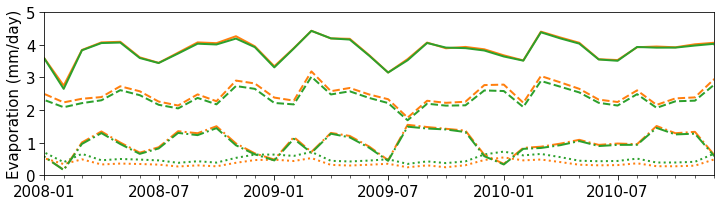

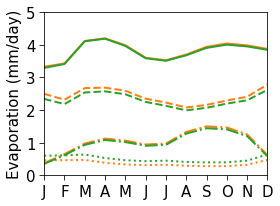

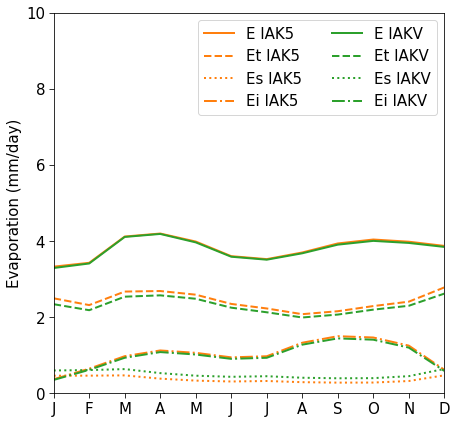

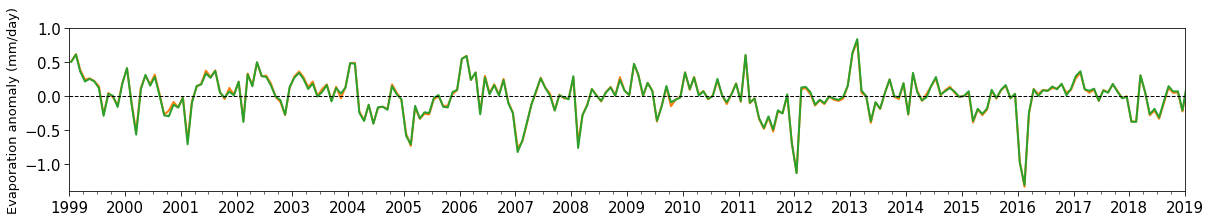

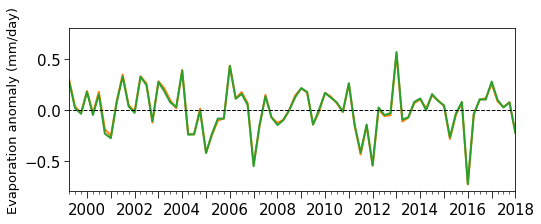

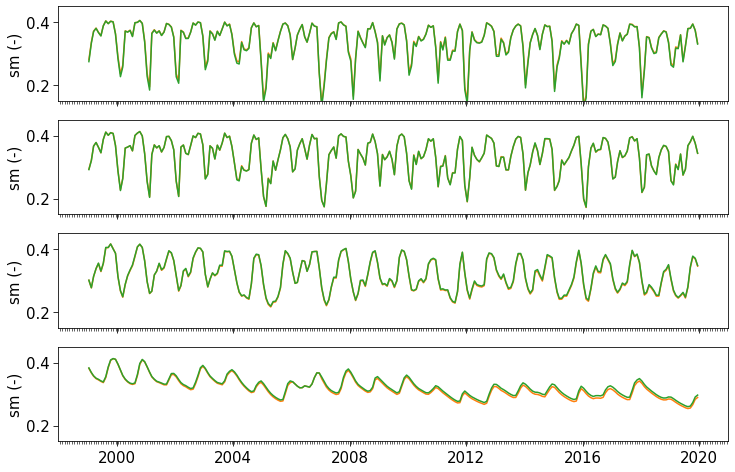

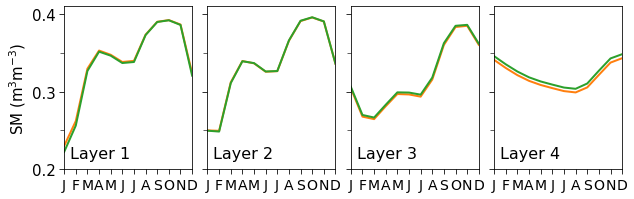

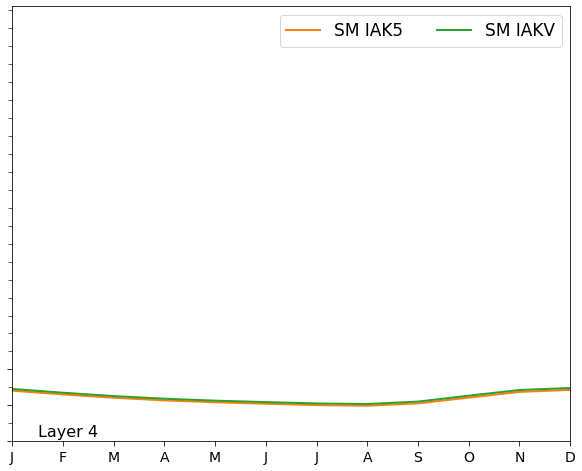

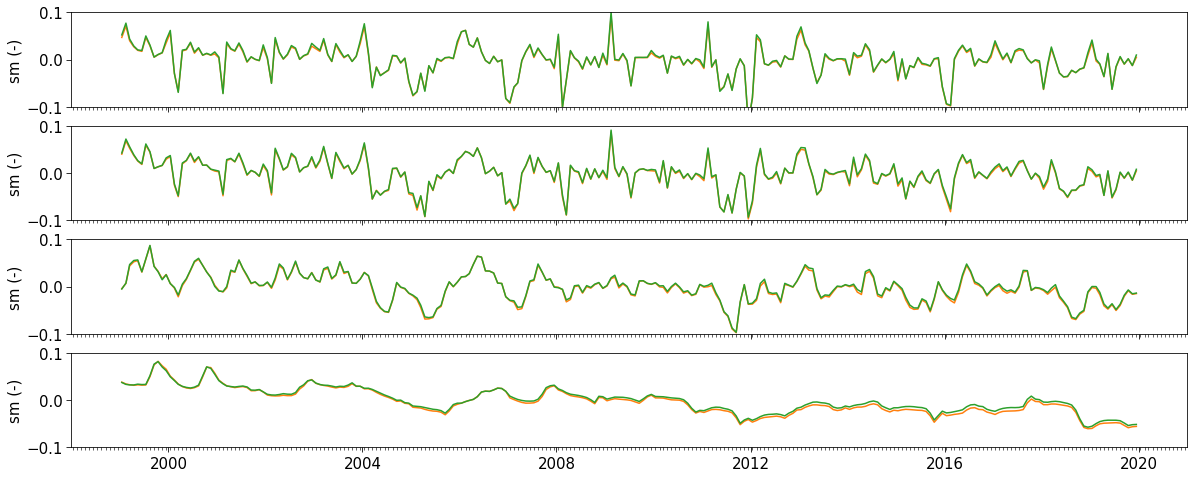

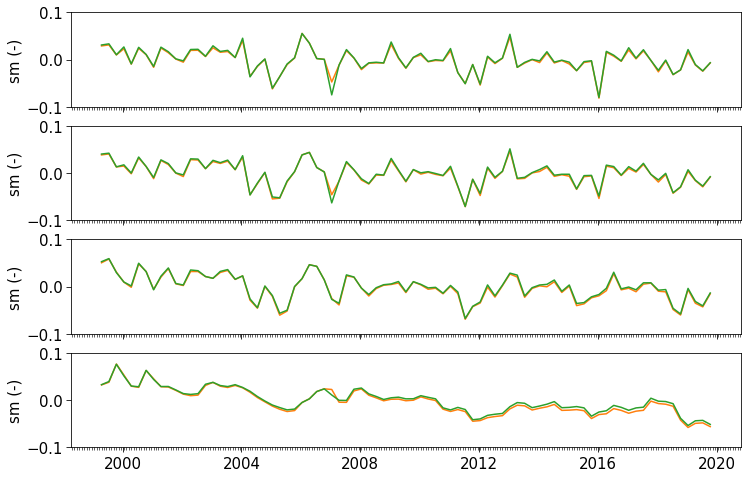

In [38]:
# point in tropical Africa
lat_min, lat_max = 1,2
lon_min, lon_max = 18,19
a=plot_ts_evapo(exp_name1,exp_name2,lat_min,lat_max,lon_min,lon_max,ymin=0,ymax=5)
b=plot_ts_evapo_climatology(exp_name1,exp_name2,lat_min,lat_max,lon_min,lon_max,ymin=0,ymax=5)
plot_ts_evapo_climatology_leg(exp_name1,exp_name2,lat_min,lat_max,lon_min,lon_max,ymin=0,ymax=5)
df=plot_ec_e_anomaly_timeseries(exp_name1,exp_name2,lat_min,lat_max,lon_min,lon_max,ymin=-1.4,ymax=1)
print(df)
plot_lc_e_seasonal_anomaly_timeseries(exp_name1,exp_name2,lat_min,lat_max,lon_min,lon_max,ymin=-0.8,ymax=0.8)
dfs = std_seasons(exp_name1,exp_name2,lat_min,lat_max,lon_min,lon_max)
print(dfs)
plot_ts_sm(exp_name1,exp_name2,lat_min,lat_max,lon_min,lon_max,ymin=0.15,ymax=0.45)
plot_ts_sm_climatology(exp_name1,exp_name2,lat_min,lat_max,lon_min,lon_max,ymin=0.2,ymax=0.41)
plot_ts_sm_climatology_leg(exp_name1,exp_name2,lat_min,lat_max,lon_min,lon_max,ymin=0.2,ymax=0.41)
plot_ts_sm_anomalies(exp_name1,exp_name2,lat_min,lat_max,lon_min,lon_max,ymin=-0.1,ymax=0.1)
plot_ts_sm_seasonal_anomalies(exp_name1,exp_name2,lat_min,lat_max,lon_min,lon_max,ymin=-0.1,ymax=0.1)
# plot_ts_sm('exp3','exp6',lat_min,lat_max,lon_min,lon_max,ymin=0,ymax=0.45)
em41,em42,es41,es42 = a[0],a[1],a[2],a[3]
e41am,e42am = a[4],a[5]

      E-std Et-std Es-std Ei-std
IAK5  0.202  0.164  0.109  0.095
IAKV   0.21  0.151  0.132  0.088
      mam    jja    son    djf
e   0.008  0.004  0.004 -0.001
et -0.017 -0.005 -0.007 -0.001
es  0.024   0.01  0.009    0.0
ei -0.004 -0.005 -0.005    0.0


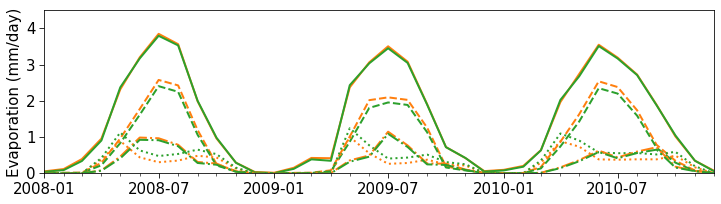

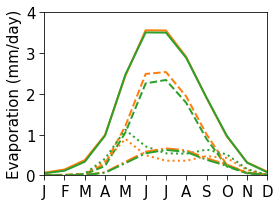

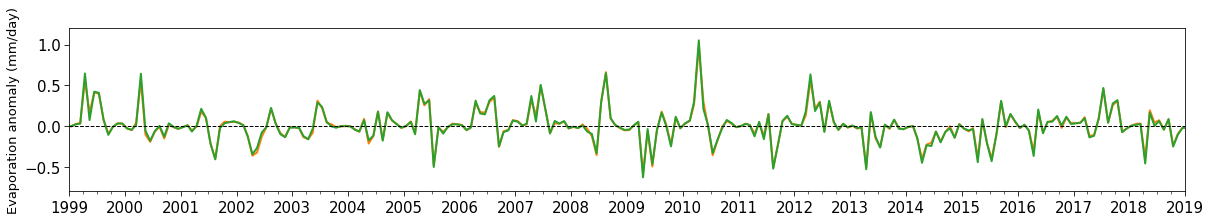

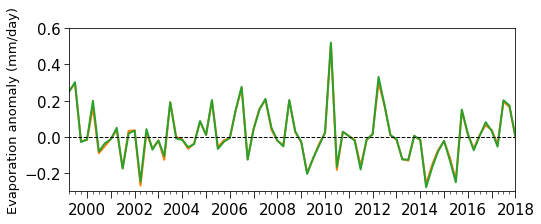

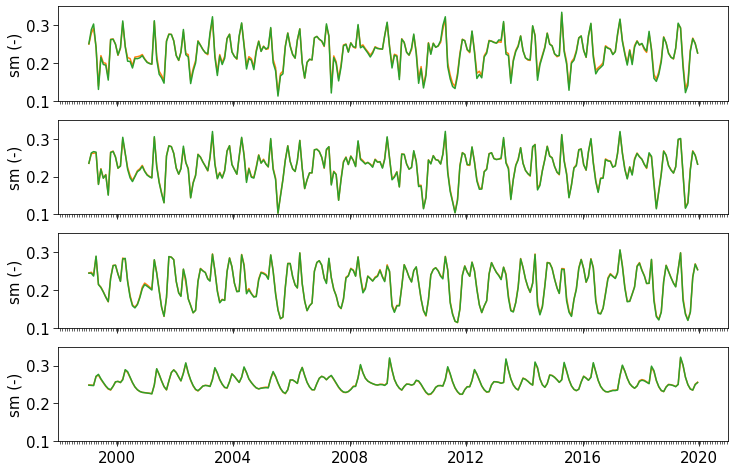

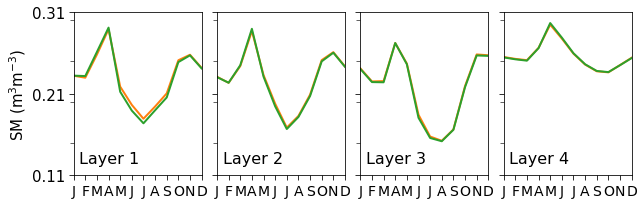

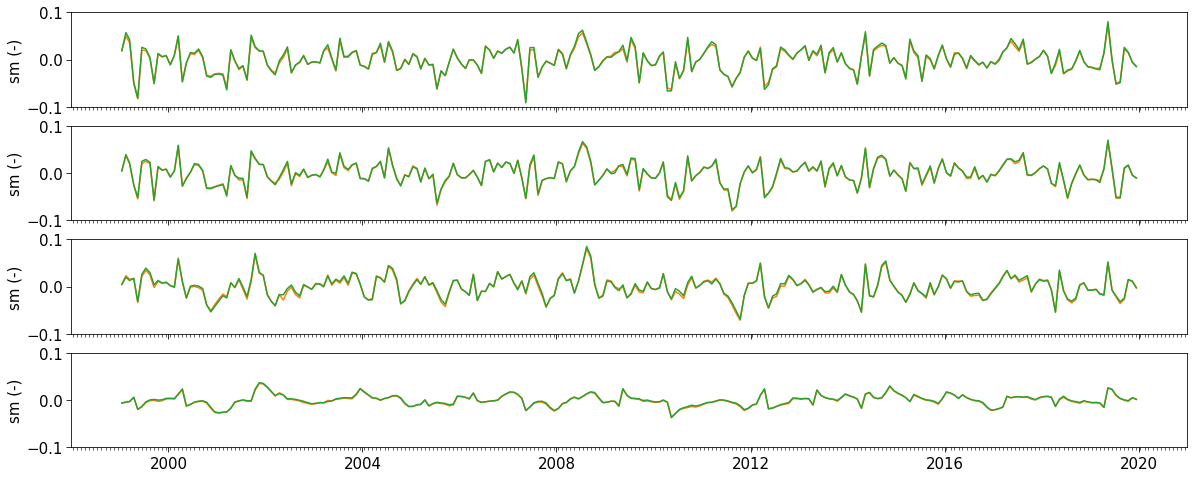

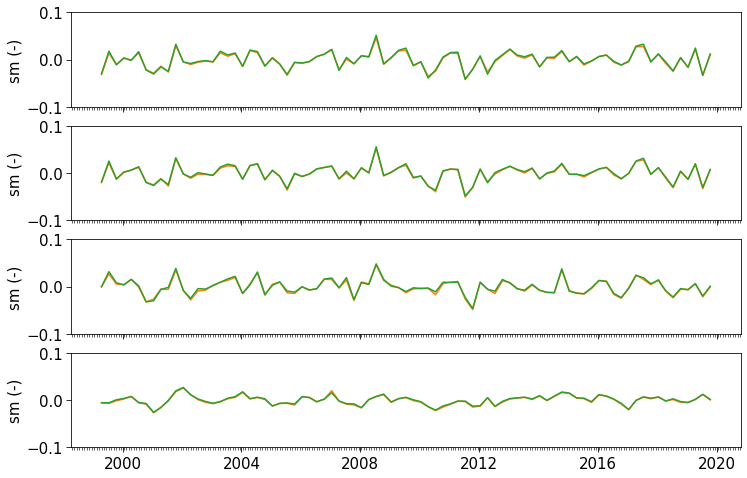

In [39]:
# great lakes
lat_min, lat_max = 47,48
lon_min, lon_max = 279,280
a=plot_ts_evapo(exp_name1,exp_name2,lat_min,lat_max,lon_min,lon_max,ymin=0,ymax=4.5)
b=plot_ts_evapo_climatology(exp_name1,exp_name2,lat_min,lat_max,lon_min,lon_max,ymin=0,ymax=4)
df=plot_ec_e_anomaly_timeseries(exp_name1,exp_name2,lat_min,lat_max,lon_min,lon_max,ymin=-0.8,ymax=1.2)
print(df)
plot_lc_e_seasonal_anomaly_timeseries(exp_name1,exp_name2,lat_min,lat_max,lon_min,lon_max,ymin=-0.3,ymax=0.6)
dfs = std_seasons(exp_name1,exp_name2,lat_min,lat_max,lon_min,lon_max)
plot_ts_sm(exp_name1,exp_name2,lat_min,lat_max,lon_min,lon_max,ymin=0.1,ymax=0.35)
plot_ts_sm_climatology(exp_name1,exp_name2,lat_min,lat_max,lon_min,lon_max,ymin=0.11,ymax=0.31)
plot_ts_sm_anomalies(exp_name1,exp_name2,lat_min,lat_max,lon_min,lon_max,ymin=-0.1,ymax=0.1)
plot_ts_sm_seasonal_anomalies(exp_name1,exp_name2,lat_min,lat_max,lon_min,lon_max,ymin=-0.1,ymax=0.1)
print(dfs)
# plot_ts_sm(exp_name1,exp_name2,lat_min,lat_max,lon_min,lon_max,ymin=0.1,ymax=0.35)
em61,em62,es61,es62 = a[0],a[1],a[2],a[3]
e61am,e62am = a[4],a[5]

In [40]:
# # BOREAL 2
# lat_min, lat_max = 50,51
# lon_min, lon_max = 266,267
# a=plot_ts_evapo(exp_name1,exp_name2,lat_min,lat_max,lon_min,lon_max,ymin=0,ymax=4)
# b=plot_ts_evapo_climatology(exp_name1,exp_name2,lat_min,lat_max,lon_min,lon_max,ymin=0,ymax=4)
# df=plot_ec_e_anomaly_timeseries(exp_name1,exp_name2,lat_min,lat_max,lon_min,lon_max,ymin=-0.8,ymax=0.8)
# print(df)
# plot_lc_e_seasonal_anomaly_timeseries(exp_name1,exp_name2,lat_min,lat_max,lon_min,lon_max,ymin=-0.5,ymax=0.55)
# dfs = std_seasons(exp_name1,exp_name2,lat_min,lat_max,lon_min,lon_max)
# print(dfs)
# # plot_ts_sm(exp_name1,exp_name2,lat_min,lat_max,lon_min,lon_max,ymin=0.1,ymax=0.35)
# # em61,em62,es61,es62 = a[0],a[1],a[2],a[3]
# # e61am,e62am = a[4],a[5]
# # # china
# # lat_min, lat_max = 28,29
# # lon_min, lon_max = 119,120
# # a=plot_ts_evapo(exp_name1,exp_name2,lat_min,lat_max,lon_min,lon_max,ymin=0,ymax=4.8)
# # plot_ts_sm(exp_name1,exp_name2,lat_min,lat_max,lon_min,lon_max,ymin=0.0,ymax=0.7)
# # em71,em72,es71,es72 = a[0],a[1],a[2],a[3]

In [41]:
# # #northern finland
# lat_min, lat_max = 64,65
# lon_min, lon_max = 29,30
# a=plot_ts_evapo(exp_name1,exp_name2,lat_min,lat_max,lon_min,lon_max,ymin=0,ymax=3.5)
# em21,em22,es21,es22 = a[0],a[1],a[2],a[3]
# plot_ts_sm(exp_name1,exp_name2,lat_min,lat_max,lon_min,lon_max,ymin=0.5,ymax=0.75)
# # plon1,plat1 = plot_ts_rmse(exp_name1,exp_name2,rmse1_djf,rmse2_djf,rmse1_jja,rmse2_jja,fc,cv1,cv2,lat_min,lat_max,lon_min,lon_max,tvl,tvh)

# # # canada boreal
# lat_min, lat_max = 62,63
# lon_min, lon_max = 263,264
# a=plot_ts_evapo(exp_name1,exp_name2,lat_min,lat_max,lon_min,lon_max,ymin=0,ymax=3)
# plot_ts_sm(exp_name1,exp_name2,lat_min,lat_max,lon_min,lon_max,ymin=0.08,ymax=0.3)
# em11,em12,es11,es12 = a[0],a[1],a[2],a[3]

# # europe point
# lat_min, lat_max = 50,51
# lon_min, lon_max = 5,6
# a=plot_ts_evapo(exp_name1,exp_name2,lat_min,lat_max,lon_min,lon_max,ymin=0,ymax=4)
# # plot_ts_sm(exp_name1,exp_name2,lat_min,lat_max,lon_min,lon_max,ymin=0.1,ymax=0.45)
# em31,em32,es31,es32 = a[0],a[1],a[2],a[3]

# # mediterranean point
# lat_min, lat_max = -34,-33
# lon_min, lon_max = 117,118
# a=plot_ts_evapo(exp_name1,exp_name2,lat_min,lat_max,lon_min,lon_max,ymin=0,ymax=2.5)
# plot_ts_sm(exp_name1,exp_name2,lat_min,lat_max,lon_min,lon_max,ymin=0.0,ymax=0.35)
# em51,em52,es51,es52 = a[0],a[1],a[2],a[3]

# # siberia
# lat_min, lat_max = 61,62
# lon_min, lon_max = 149,150
# a=plot_ts_evapo(exp_name1,exp_name2,lat_min,lat_max,lon_min,lon_max,ymin=0,ymax=2.5)
# plot_ts_sm(exp_name1,exp_name2,lat_min,lat_max,lon_min,lon_max,ymin=0.0,ymax=0.7)
# em71,em72,es71,es72 = a[0],a[1],a[2],a[3]

In [42]:
df1 = pd.DataFrame(index=['K5-4','KV-4','K5-6','KV-6'],columns=['E-m','Et-m','Es-m','Ei-m','E-s','Et-s','Es-s','Ei-s'])
# df1.iloc[0,0:4]=[np.round(em11[0].values,3),np.round(em11[1].values,3),np.round(em11[2].values,3),np.round(em11[3].values,3)]
# df1.iloc[0,4:8]=[np.round(es11[0].values,3),np.round(es11[1].values,3),np.round(es11[2].values,3),np.round(es11[3].values,3)]
# df1.iloc[1,0:4]=[np.round(em12[0].values,3),np.round(em12[1].values,3),np.round(em12[2].values,3),np.round(em12[3].values,3)]
# df1.iloc[1,4:8]=[np.round(es12[0].values,3),np.round(es12[1].values,3),np.round(es12[2].values,3),np.round(es12[3].values,3)]

# df1.iloc[2,0:4]=[np.round(em21[0].values,3),np.round(em21[1].values,3),np.round(em21[2].values,3),np.round(em21[3].values,3)]
# df1.iloc[2,4:8]=[np.round(es21[0].values,3),np.round(es21[1].values,3),np.round(es21[2].values,3),np.round(es21[3].values,3)]
# df1.iloc[3,0:4]=[np.round(em22[0].values,3),np.round(em22[1].values,3),np.round(em22[2].values,3),np.round(em22[3].values,3)]
# df1.iloc[3,4:8]=[np.round(es22[0].values,3),np.round(es22[1].values,3),np.round(es22[2].values,3),np.round(es22[3].values,3)]

# df1.iloc[4,0:4]=[np.round(em31[0].values,3),np.round(em31[1].values,3),np.round(em31[2].values,3),np.round(em31[3].values,3)]
# df1.iloc[4,4:8]=[np.round(es31[0].values,3),np.round(es31[1].values,3),np.round(es31[2].values,3),np.round(es31[3].values,3)]
# df1.iloc[5,0:4]=[np.round(em32[0].values,3),np.round(em32[1].values,3),np.round(em32[2].values,3),np.round(em32[3].values,3)]
# df1.iloc[5,4:8]=[np.round(es32[0].values,3),np.round(es32[1].values,3),np.round(es32[2].values,3),np.round(es32[3].values,3)]

df1.iloc[0,0:4]=[np.round(em41[0].values,3),np.round(em41[1].values,3),np.round(em41[2].values,3),np.round(em41[3].values,3)]
df1.iloc[0,4:8]=[np.round(es41[0].values,3),np.round(es41[1].values,3),np.round(es41[2].values,3),np.round(es41[3].values,3)]
df1.iloc[1,0:4]=[np.round(em42[0].values,3),np.round(em42[1].values,3),np.round(em42[2].values,3),np.round(em42[3].values,3)]
df1.iloc[1,4:8]=[np.round(es42[0].values,3),np.round(es42[1].values,3),np.round(es42[2].values,3),np.round(es42[3].values,3)]

df1.iloc[2,0:4]=[np.round(em61[0].values,3),np.round(em61[1].values,3),np.round(em61[2].values,3),np.round(em61[3].values,3)]
df1.iloc[2,4:8]=[np.round(es61[0].values,3),np.round(es61[1].values,3),np.round(es61[2].values,3),np.round(es61[3].values,3)]
df1.iloc[3,0:4]=[np.round(em62[0].values,3),np.round(em62[1].values,3),np.round(em62[2].values,3),np.round(em62[3].values,3)]
df1.iloc[3,4:8]=[np.round(es62[0].values,3),np.round(es62[1].values,3),np.round(es62[2].values,3),np.round(es62[3].values,3)]

# df1.iloc[8,0:4]=[np.round(em51[0].values,3),np.round(em51[1].values,3),np.round(em51[2].values,3),np.round(em51[3].values,3)]
# df1.iloc[8,4:8]=[np.round(es51[0].values,3),np.round(es51[1].values,3),np.round(es51[2].values,3),np.round(es51[3].values,3)]
# df1.iloc[9,0:4]=[np.round(em52[0].values,3),np.round(em52[1].values,3),np.round(em52[2].values,3),np.round(em52[3].values,3)]
# df1.iloc[9,4:8]=[np.round(es52[0].values,3),np.round(es52[1].values,3),np.round(es52[2].values,3),np.round(es52[3].values,3)]

# df1.iloc[8,0:4]=[np.round(em51[0].values,3),np.round(em51[1].values,3),np.round(em51[2].values,3),np.round(em51[3].values,3)]
# df1.iloc[8,4:8]=[np.round(es51[0].values,3),np.round(es51[1].values,3),np.round(es51[2].values,3),np.round(es51[3].values,3)]
# df1.iloc[9,0:4]=[np.round(em52[0].values,3),np.round(em52[1].values,3),np.round(em52[2].values,3),np.round(em52[3].values,3)]
# df1.iloc[9,4:8]=[np.round(es52[0].values,3),np.round(es52[1].values,3),np.round(es52[2].values,3),np.round(es52[3].values,3)]

df1

E-m   Et-m   Es-m   Ei-m    E-s   Et-s   Es-s   Ei-s
K5-4  3.811  2.422  0.367  1.022   0.39  0.319  0.091   0.39
KV-4  3.788  2.307  0.501   0.98  0.391  0.298  0.116  0.376
K5-6   1.44   0.82  0.293  0.251  1.323  0.967  0.281  0.268
KV-6  1.423  0.738  0.387  0.232   1.32  0.887  0.364  0.251

In [43]:
df1*365

E-m        Et-m        Es-m        Ei-m      E-s     Et-s  \
K5-4   1391.01504  884.029975  133.955005  373.029984   142.35  116.435   
KV-4  1382.620039  842.054971  182.864995  357.700007  142.715   108.77   
K5-6   525.600021  299.299997  106.945005   91.614995  482.895  352.955   
KV-6   519.394992  269.369991  141.254998   84.679998    481.8  323.755   

         Es-s    Ei-s  
K5-4   33.215  142.35  
KV-4    42.34  137.24  
K5-6  102.565   97.82  
KV-6   132.86  91.615

In [44]:
f_mod1 = f'{fol}/htessel_output/{exp_name1}'
f_mod2 = f'{fol}/htessel_output/{exp_name2}'

In [45]:
# load anomalies of evaporation fluxes
# EXP8
mod = xr.open_dataset(f'{f_mod1}/seasonal/o_wat_{start_year}_{end_year}_jja_anomalies.nc')
et = mod.TVEG * -1000
es = mod.ESOIL * -1000
p = mod.TP * 1000
q = mod.RO * 1000
e = mod.E * -1000
ei = mod.evatc * -1000

# time mean
etm1 = et.mean(dim='time')
esm1 = es.mean(dim='time')
eim1 = ei.mean(dim='time')
em1 = e.mean(dim='time')
pm1 = p.mean(dim='time')
qm1 = q.mean(dim='time')

# time std
ets1 = et.std(dim='time')
ess1 = es.std(dim='time')
eis1 = ei.std(dim='time')
es1 = e.std(dim='time')
ps1 = p.std(dim='time')
qs1 = q.std(dim='time')

# EXP6
mod = xr.open_dataset(f'{f_mod2}/seasonal/o_wat_{start_year}_{end_year}_jja_anomalies.nc')
et = mod.TVEG * -1000
es = mod.ESOIL * -1000
p = mod.TP * 1000
q = mod.RO * 1000
e = mod.E * -1000
ei = mod.evatc * -1000

# time mean
etm2 = et.mean(dim='time')
esm2 = es.mean(dim='time')
eim2 = ei.mean(dim='time')
em2 = e.mean(dim='time')
pm2 = p.mean(dim='time')
qm2 = q.mean(dim='time')

# time std
ets2 = et.std(dim='time')
ess2 = es.std(dim='time')
eis2 = ei.std(dim='time')
es2 = e.std(dim='time')
ps2 = p.std(dim='time')
qs2 = q.std(dim='time')

# diff
etsd = ets2-ets1
essd = ess2-ess1
eisd = eis2-eis1
esd = es2-es1

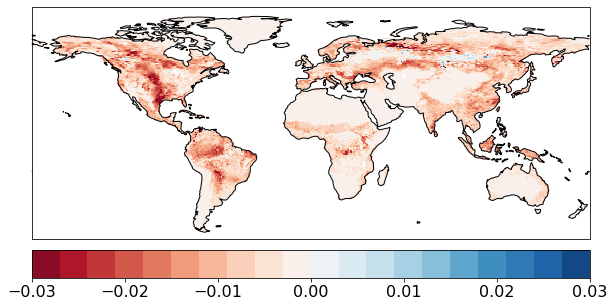

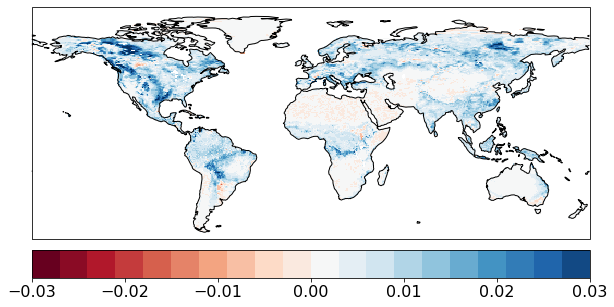

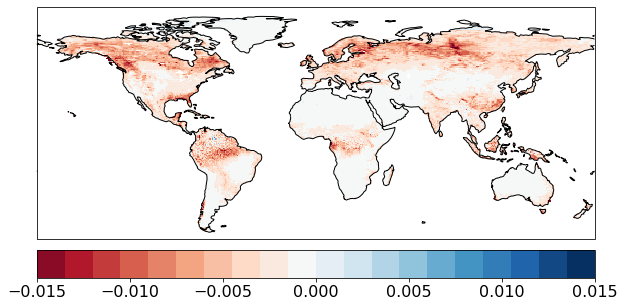

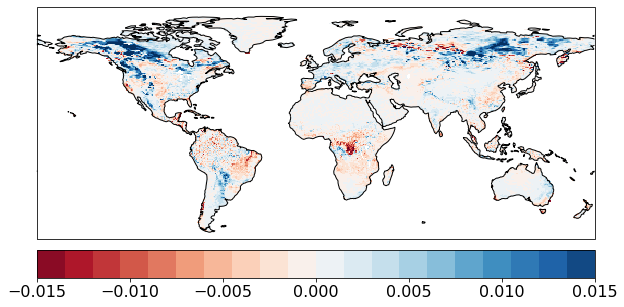

In [46]:
# plot STD diff evaporation anomalies
cm = plt.cm.get_cmap('RdBu') 
lvls = np.linspace(-0.03,0.03,21)
lvls2 = np.linspace(-0.03,0.03,7)

fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
cf = etsd.plot(ax=ax, cmap=cm, add_colorbar=False, vmin=0, vmax=5, levels=lvls)
cbar = plt.colorbar(cf, orientation='horizontal',extend='neither',label='', pad=0.02, ticks=lvls2)
# ax.set_title(f'std diff of anomaly Et {exp_name1}-{exp_name2} {start_year}-{end_year}')
# ax.set_ylim(-40,0)
# ax.set_xlim(-90,-30)
ax.set_ylim(-60,90)
ax.set_xlim(-180,180)
cbar.ax.tick_params(labelsize=16)
# ax.plot(plon1,plat1,'bo')
# ax.plot(plon2,plat2,'bo')
# ax.plot(plon3,plat3,'bo')
# ax.plot(plon4,plat4,'bo')
# ax.plot(plon5,plat5,'bo')
fig.savefig(f'/home/vanoorschot/work/fransje/scripts/HTESSEL/figures/paper_figures/{exp_name1}_{exp_name2}/std_diff_jja_anomaly_Et_{exp_name1}_{exp_name2}_{start_year}_{end_year}.jpg',dpi=300,bbox_inches='tight')

# lvls = np.linspace(-0.1,0.1,21)
# lvls2 = np.linspace(-0.1,0.1,5)
fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
cf = essd.plot(ax=ax, cmap=cm, add_colorbar=False, vmin=0, vmax=5, levels=lvls)
cbar = plt.colorbar(cf, orientation='horizontal',extend='neither',label='', pad=0.02, ticks=lvls2)
# ax.set_title(f'std diff of anomaly Es {exp_name1}-{exp_name2} {start_year}-{end_year}')
# ax.set_ylim(-40,0)
# ax.set_xlim(-90,-30)
ax.set_ylim(-60,90)
ax.set_xlim(-180,180)
cbar.ax.tick_params(labelsize=16)
# ax.plot(plon1,plat1,'bo')
# ax.plot(plon2,plat2,'bo')
# ax.plot(plon3,plat3,'bo')
# ax.plot(plon4,plat4,'bo')
# ax.plot(plon5,plat5,'bo')
fig.savefig(f'/home/vanoorschot/work/fransje/scripts/HTESSEL/figures/paper_figures/{exp_name1}_{exp_name2}/std_diff_jja_anomaly_Es_{exp_name1}_{exp_name2}_{start_year}_{end_year}.jpg',dpi=300,bbox_inches='tight')

lvls = np.linspace(-0.015,0.015,21)
lvls2 = np.linspace(-0.015,0.015,7)
fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
cf = eisd.plot(ax=ax, cmap=cm, add_colorbar=False, vmin=0, vmax=5, levels=lvls)
cbar = plt.colorbar(cf, orientation='horizontal',extend='neither',label='', pad=0.02, ticks=lvls2)
# ax.set_title(f'std diff of anomaly Ei {exp_name1}-{exp_name2} {start_year}-{end_year}')
# ax.set_ylim(-40,0)
# ax.set_xlim(-90,-30)
ax.set_ylim(-60,90)
ax.set_xlim(-180,180)
cbar.ax.tick_params(labelsize=16)
# ax.plot(plon1,plat1,'bo')
# ax.plot(plon2,plat2,'bo')
# ax.plot(plon3,plat3,'bo')
# ax.plot(plon4,plat4,'bo')
# ax.plot(plon5,plat5,'bo')
fig.savefig(f'/home/vanoorschot/work/fransje/scripts/HTESSEL/figures/paper_figures/{exp_name1}_{exp_name2}/std_diff_jja_anomaly_Ei_{exp_name1}_{exp_name2}_{start_year}_{end_year}.jpg',dpi=300,bbox_inches='tight')

lvls = np.linspace(-0.015,0.015,21)
lvls2 = np.linspace(-0.015,0.015,7)
fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
cf = esd.plot(ax=ax, cmap=cm, add_colorbar=False, vmin=0, vmax=5, levels=lvls)
cbar = plt.colorbar(cf, orientation='horizontal',extend='neither',label='', pad=0.02, ticks=lvls2)
# ax.set_title(f'std diff of anomaly Etotal {exp_name1}-{exp_name2} {start_year}-{end_year}')
# ax.set_ylim(-40,0)
# ax.set_xlim(-90,-30)
ax.set_ylim(-60,90)
ax.set_xlim(-180,180)
cbar.ax.tick_params(labelsize=16)
# ax.plot(plon1,plat1,'bo')
# ax.plot(plon2,plat2,'bo')
# ax.plot(plon3,plat3,'bo')
# ax.plot(plon4,plat4,'bo')
# ax.plot(plon5,plat5,'bo')
fig.savefig(f'/home/vanoorschot/work/fransje/scripts/HTESSEL/figures/paper_figures/{exp_name1}_{exp_name2}/std_diff_jja_anomaly_E_{exp_name1}_{exp_name2}_{start_year}_{end_year}.jpg',dpi=300,bbox_inches='tight')

In [47]:
# load anomalies of evaporation fluxes
# EXP8
mod = xr.open_dataset(f'{f_mod1}/seasonal/o_wat_{start_year}_{end_year}_djf_anomalies.nc')
et = mod.TVEG * -1000
es = mod.ESOIL * -1000
p = mod.TP * 1000
q = mod.RO * 1000
e = mod.E * -1000
ei = mod.evatc * -1000

# time mean
etm1 = et.mean(dim='time')
esm1 = es.mean(dim='time')
eim1 = ei.mean(dim='time')
em1 = e.mean(dim='time')
pm1 = p.mean(dim='time')
qm1 = q.mean(dim='time')

# time std
ets1 = et.std(dim='time')
ess1 = es.std(dim='time')
eis1 = ei.std(dim='time')
es1 = e.std(dim='time')
ps1 = p.std(dim='time')
qs1 = q.std(dim='time')

# EXP6
mod = xr.open_dataset(f'{f_mod2}/seasonal/o_wat_{start_year}_{end_year}_djf_anomalies.nc')
et = mod.TVEG * -1000
es = mod.ESOIL * -1000
p = mod.TP * 1000
q = mod.RO * 1000
e = mod.E * -1000
ei = mod.evatc * -1000

# time mean
etm2 = et.mean(dim='time')
esm2 = es.mean(dim='time')
eim2 = ei.mean(dim='time')
em2 = e.mean(dim='time')
pm2 = p.mean(dim='time')
qm2 = q.mean(dim='time')

# time std
ets2 = et.std(dim='time')
ess2 = es.std(dim='time')
eis2 = ei.std(dim='time')
es2 = e.std(dim='time')
ps2 = p.std(dim='time')
qs2 = q.std(dim='time')

# diff
etsd = ets2-ets1
essd = ess2-ess1
eisd = eis2-eis1
esd = es2-es1

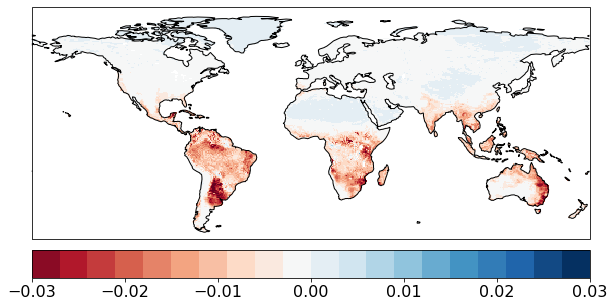

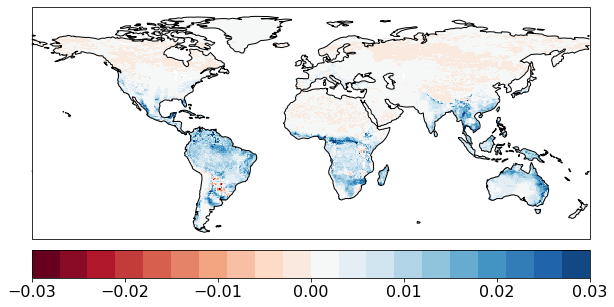

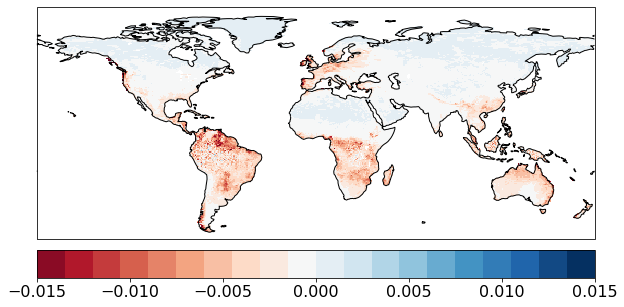

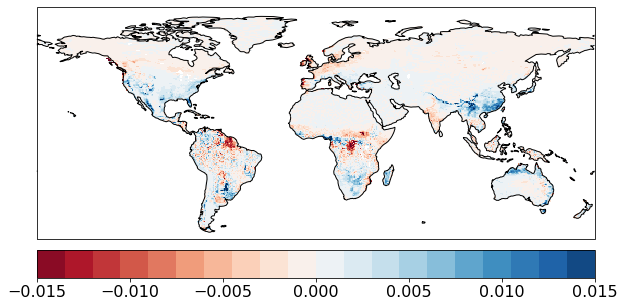

In [48]:
# plot STD diff evaporation anomalies
cm = plt.cm.get_cmap('RdBu') 
lvls = np.linspace(-0.03,0.03,21)
lvls2 = np.linspace(-0.03,0.03,7)

fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
cf = etsd.plot(ax=ax, cmap=cm, add_colorbar=False, vmin=0, vmax=5, levels=lvls)
cbar = plt.colorbar(cf, orientation='horizontal',extend='neither',label='', pad=0.02, ticks=lvls2)
# ax.set_title(f'std diff of anomaly Et {exp_name1}-{exp_name2} {start_year}-{end_year}')
# ax.set_ylim(-40,0)
# ax.set_xlim(-90,-30)
ax.set_ylim(-60,90)
ax.set_xlim(-180,180)
cbar.ax.tick_params(labelsize=16)
# ax.plot(plon1,plat1,'bo')
# ax.plot(plon2,plat2,'bo')
# ax.plot(plon3,plat3,'bo')
# ax.plot(plon4,plat4,'bo')
# ax.plot(plon5,plat5,'bo')
fig.savefig(f'/home/vanoorschot/work/fransje/scripts/HTESSEL/figures/paper_figures/{exp_name1}_{exp_name2}/std_diff_djf_anomaly_Et_{exp_name1}_{exp_name2}_{start_year}_{end_year}.jpg',dpi=300,bbox_inches='tight')

# lvls = np.linspace(-0.1,0.1,21)
# lvls2 = np.linspace(-0.1,0.1,5)
fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
cf = essd.plot(ax=ax, cmap=cm, add_colorbar=False, vmin=0, vmax=5, levels=lvls)
cbar = plt.colorbar(cf, orientation='horizontal',extend='neither',label='', pad=0.02, ticks=lvls2)
# ax.set_title(f'std diff of anomaly Es {exp_name1}-{exp_name2} {start_year}-{end_year}')
# ax.set_ylim(-40,0)
# ax.set_xlim(-90,-30)
ax.set_ylim(-60,90)
ax.set_xlim(-180,180)
cbar.ax.tick_params(labelsize=16)
# ax.plot(plon1,plat1,'bo')
# ax.plot(plon2,plat2,'bo')
# ax.plot(plon3,plat3,'bo')
# ax.plot(plon4,plat4,'bo')
# ax.plot(plon5,plat5,'bo')
fig.savefig(f'/home/vanoorschot/work/fransje/scripts/HTESSEL/figures/paper_figures/{exp_name1}_{exp_name2}/std_diff_djf_anomaly_Es_{exp_name1}_{exp_name2}_{start_year}_{end_year}.jpg',dpi=300,bbox_inches='tight')

lvls = np.linspace(-0.015,0.015,21)
lvls2 = np.linspace(-0.015,0.015,7)
fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
cf = eisd.plot(ax=ax, cmap=cm, add_colorbar=False, vmin=0, vmax=5, levels=lvls)
cbar = plt.colorbar(cf, orientation='horizontal',extend='neither',label='', pad=0.02, ticks=lvls2)
# ax.set_title(f'std diff of anomaly Ei {exp_name1}-{exp_name2} {start_year}-{end_year}')
# ax.set_ylim(-40,0)
# ax.set_xlim(-90,-30)
ax.set_ylim(-60,90)
ax.set_xlim(-180,180)
cbar.ax.tick_params(labelsize=16)
# ax.plot(plon1,plat1,'bo')
# ax.plot(plon2,plat2,'bo')
# ax.plot(plon3,plat3,'bo')
# ax.plot(plon4,plat4,'bo')
# ax.plot(plon5,plat5,'bo')
fig.savefig(f'/home/vanoorschot/work/fransje/scripts/HTESSEL/figures/paper_figures/{exp_name1}_{exp_name2}/std_diff_djf_anomaly_Ei_{exp_name1}_{exp_name2}_{start_year}_{end_year}.jpg',dpi=300,bbox_inches='tight')

lvls = np.linspace(-0.015,0.015,21)
lvls2 = np.linspace(-0.015,0.015,7)
fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
cf = esd.plot(ax=ax, cmap=cm, add_colorbar=False, vmin=0, vmax=5, levels=lvls)
cbar = plt.colorbar(cf, orientation='horizontal',extend='neither',label='', pad=0.02, ticks=lvls2)
# ax.set_title(f'std diff of anomaly Etotal {exp_name1}-{exp_name2} {start_year}-{end_year}')
# ax.set_ylim(-40,0)
# ax.set_xlim(-90,-30)
ax.set_ylim(-60,90)
ax.set_xlim(-180,180)
cbar.ax.tick_params(labelsize=16)
# ax.plot(plon1,plat1,'bo')
# ax.plot(plon2,plat2,'bo')
# ax.plot(plon3,plat3,'bo')
# ax.plot(plon4,plat4,'bo')
# ax.plot(plon5,plat5,'bo')
fig.savefig(f'/home/vanoorschot/work/fransje/scripts/HTESSEL/figures/paper_figures/{exp_name1}_{exp_name2}/std_diff_djf_anomaly_E_{exp_name1}_{exp_name2}_{start_year}_{end_year}.jpg',dpi=300,bbox_inches='tight')

In [49]:
# load anomalies of soil moisture
# EXP8
mod = xr.open_dataset(f'{f_mod1}/seasonal/o_soil_{start_year}_{end_year}_djf_anomalies.nc')
sm1 = mod.SWVL1
sm2 = mod.SWVL2
sm3 = mod.SWVL3
sm4  = mod.SWVL4

# time mean
smm11 = sm1.mean(dim='time')
smm21 = sm2.mean(dim='time')
smm31 = sm3.mean(dim='time')
smm41 = sm4.mean(dim='time')

# time std
sms11 = sm1.std(dim='time')
sms21 = sm2.std(dim='time')
sms31 = sm3.std(dim='time')
sms41 = sm4.std(dim='time')

# EXP6
mod = xr.open_dataset(f'{f_mod2}/seasonal/o_soil_{start_year}_{end_year}_djf_anomalies.nc')
sm1 = mod.SWVL1
sm2 = mod.SWVL2
sm3 = mod.SWVL3
sm4  = mod.SWVL4

# time mean
smm12 = sm1.mean(dim='time')
smm22 = sm2.mean(dim='time')
smm32 = sm3.mean(dim='time')
smm42 = sm4.mean(dim='time')

# time std
sms12 = sm1.std(dim='time')
sms22 = sm2.std(dim='time')
sms32 = sm3.std(dim='time')
sms42 = sm4.std(dim='time')

# diff
sms1d = sms12 -sms11
sms2d = sms22 -sms21
sms3d = sms32 -sms31
sms4d = sms42 -sms41

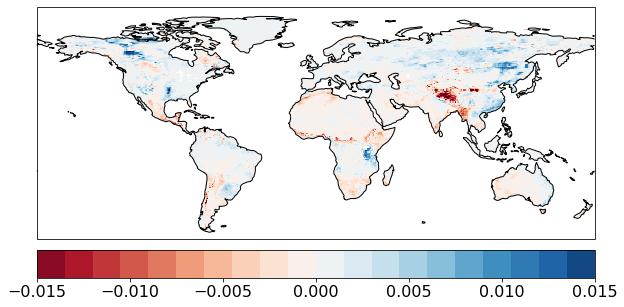

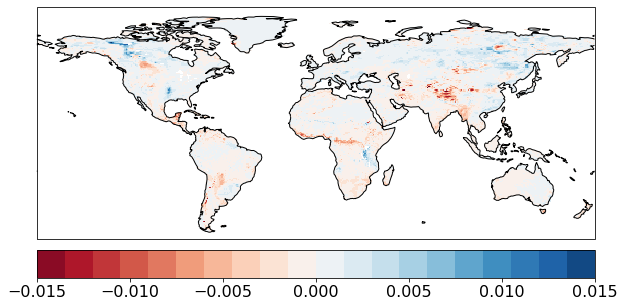

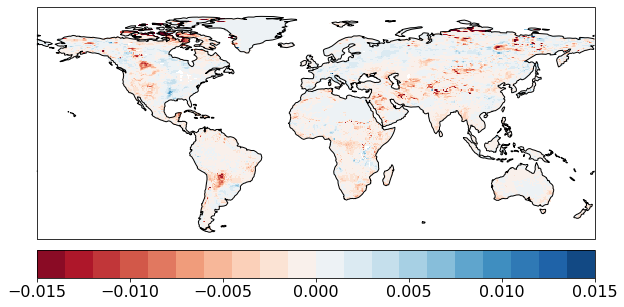

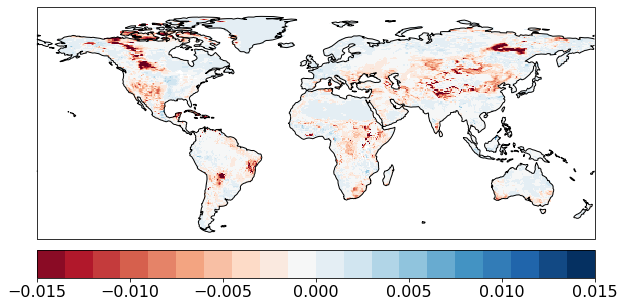

In [50]:
# plot STD diff sm anomalies
cm = plt.cm.get_cmap('RdBu') 
lvls = np.linspace(-0.015,0.015,21)
lvls2 = np.linspace(-0.015,0.015,7)

fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
cf = sms1d.plot(ax=ax, cmap=cm, add_colorbar=False, vmin=0, vmax=5, levels=lvls)
cbar = plt.colorbar(cf, orientation='horizontal',extend='neither',label='', pad=0.02, ticks=lvls2)
ax.set_ylim(-60,90)
ax.set_xlim(-180,180)
cbar.ax.tick_params(labelsize=16)
fig.savefig(f'/home/vanoorschot/work/fransje/scripts/HTESSEL/figures/paper_figures/{exp_name1}_{exp_name2}/std_diff_djf_anomaly_sm1_{exp_name1}_{exp_name2}_{start_year}_{end_year}.jpg',dpi=300,bbox_inches='tight')

# lvls = np.linspace(-0.1,0.1,21)
# lvls2 = np.linspace(-0.1,0.1,5)
fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
cf = sms2d.plot(ax=ax, cmap=cm, add_colorbar=False, vmin=0, vmax=5, levels=lvls)
cbar = plt.colorbar(cf, orientation='horizontal',extend='neither',label='', pad=0.02, ticks=lvls2)
ax.set_ylim(-60,90)
ax.set_xlim(-180,180)
cbar.ax.tick_params(labelsize=16)
fig.savefig(f'/home/vanoorschot/work/fransje/scripts/HTESSEL/figures/paper_figures/{exp_name1}_{exp_name2}/std_diff_djf_anomaly_sm2_{exp_name1}_{exp_name2}_{start_year}_{end_year}.jpg',dpi=300,bbox_inches='tight')

# lvls = np.linspace(-0.04,0.04,21)
# lvls2 = np.linspace(-0.04,0.04,5)
fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
cf = sms3d.plot(ax=ax, cmap=cm, add_colorbar=False, vmin=0, vmax=5, levels=lvls)
cbar = plt.colorbar(cf, orientation='horizontal',extend='neither',label='', pad=0.02, ticks=lvls2)
ax.set_ylim(-60,90)
ax.set_xlim(-180,180)
cbar.ax.tick_params(labelsize=16)
fig.savefig(f'/home/vanoorschot/work/fransje/scripts/HTESSEL/figures/paper_figures/{exp_name1}_{exp_name2}/std_diff_djf_anomaly_sm3_{exp_name1}_{exp_name2}_{start_year}_{end_year}.jpg',dpi=300,bbox_inches='tight')

# lvls = np.linspace(-0.1,0.1,21)
# lvls2 = np.linspace(-0.1,0.1,5)
fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
cf = sms4d.plot(ax=ax, cmap=cm, add_colorbar=False, vmin=0, vmax=5, levels=lvls)
cbar = plt.colorbar(cf, orientation='horizontal',extend='neither',label='', pad=0.02, ticks=lvls2)
ax.set_ylim(-60,90)
ax.set_xlim(-180,180)
cbar.ax.tick_params(labelsize=16)
fig.savefig(f'/home/vanoorschot/work/fransje/scripts/HTESSEL/figures/paper_figures/{exp_name1}_{exp_name2}/std_diff_djf_anomaly_sm4_{exp_name1}_{exp_name2}_{start_year}_{end_year}.jpg',dpi=300,bbox_inches='tight')


In [51]:
# load anomalies of soil moisture
# EXP8
mod = xr.open_dataset(f'{f_mod1}/seasonal/o_soil_{start_year}_{end_year}_jja_anomalies.nc')
sm1 = mod.SWVL1
sm2 = mod.SWVL2
sm3 = mod.SWVL3
sm4  = mod.SWVL4

# time mean
smm11 = sm1.mean(dim='time')
smm21 = sm2.mean(dim='time')
smm31 = sm3.mean(dim='time')
smm41 = sm4.mean(dim='time')

# time std
sms11 = sm1.std(dim='time')
sms21 = sm2.std(dim='time')
sms31 = sm3.std(dim='time')
sms41 = sm4.std(dim='time')

# EXP6
mod = xr.open_dataset(f'{f_mod2}/seasonal/o_soil_{start_year}_{end_year}_jja_anomalies.nc')
sm1 = mod.SWVL1
sm2 = mod.SWVL2
sm3 = mod.SWVL3
sm4  = mod.SWVL4

# time mean
smm12 = sm1.mean(dim='time')
smm22 = sm2.mean(dim='time')
smm32 = sm3.mean(dim='time')
smm42 = sm4.mean(dim='time')

# time std
sms12 = sm1.std(dim='time')
sms22 = sm2.std(dim='time')
sms32 = sm3.std(dim='time')
sms42 = sm4.std(dim='time')

# diff
sms1d = sms12 -sms11
sms2d = sms22 -sms21
sms3d = sms32 -sms31
sms4d = sms42 -sms41

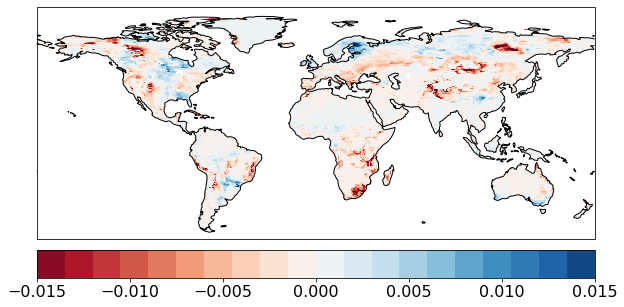

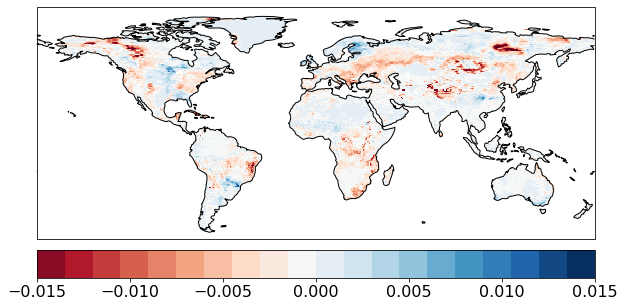

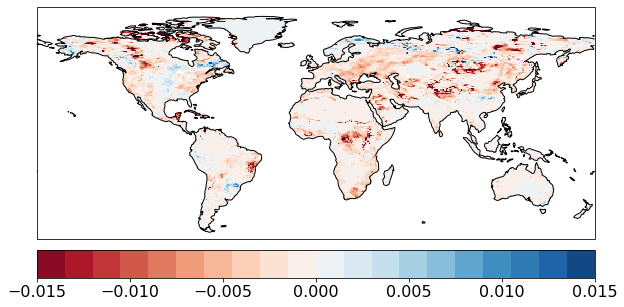

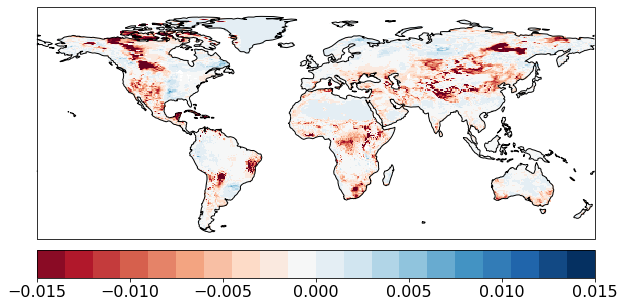

In [52]:
# plot STD diff sm anomalies
cm = plt.cm.get_cmap('RdBu') 
lvls = np.linspace(-0.015,0.015,21)
lvls2 = np.linspace(-0.015,0.015,7)

# lvls = np.linspace(-0.02,0.02,21)
# lvls2 = np.linspace(-0.02,0.02,7)
fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
cf = sms1d.plot(ax=ax, cmap=cm, add_colorbar=False, vmin=0, vmax=5, levels=lvls)
cbar = plt.colorbar(cf, orientation='horizontal',extend='neither',label='', pad=0.02, ticks=lvls2)
ax.set_ylim(-60,90)
ax.set_xlim(-180,180)
cbar.ax.tick_params(labelsize=16)
fig.savefig(f'/home/vanoorschot/work/fransje/scripts/HTESSEL/figures/paper_figures/{exp_name1}_{exp_name2}/std_diff_jja_anomaly_sm1_{exp_name1}_{exp_name2}_{start_year}_{end_year}.jpg',dpi=300,bbox_inches='tight')

# lvls = np.linspace(-0.1,0.1,21)
# lvls2 = np.linspace(-0.1,0.1,5)
fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
cf = sms2d.plot(ax=ax, cmap=cm, add_colorbar=False, vmin=0, vmax=5, levels=lvls)
cbar = plt.colorbar(cf, orientation='horizontal',extend='neither',label='', pad=0.02, ticks=lvls2)
ax.set_ylim(-60,90)
ax.set_xlim(-180,180)
cbar.ax.tick_params(labelsize=16)
fig.savefig(f'/home/vanoorschot/work/fransje/scripts/HTESSEL/figures/paper_figures/{exp_name1}_{exp_name2}/std_diff_jja_anomaly_sm2_{exp_name1}_{exp_name2}_{start_year}_{end_year}.jpg',dpi=300,bbox_inches='tight')

# lvls = np.linspace(-0.04,0.04,21)
# lvls2 = np.linspace(-0.04,0.04,5)
fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
cf = sms3d.plot(ax=ax, cmap=cm, add_colorbar=False, vmin=0, vmax=5, levels=lvls)
cbar = plt.colorbar(cf, orientation='horizontal',extend='neither',label='', pad=0.02, ticks=lvls2)
ax.set_ylim(-60,90)
ax.set_xlim(-180,180)
cbar.ax.tick_params(labelsize=16)
fig.savefig(f'/home/vanoorschot/work/fransje/scripts/HTESSEL/figures/paper_figures/{exp_name1}_{exp_name2}/std_diff_jja_anomaly_sm3_{exp_name1}_{exp_name2}_{start_year}_{end_year}.jpg',dpi=300,bbox_inches='tight')

# lvls = np.linspace(-0.1,0.1,21)
# lvls2 = np.linspace(-0.1,0.1,5)
fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
cf = sms4d.plot(ax=ax, cmap=cm, add_colorbar=False, vmin=0, vmax=5, levels=lvls)
cbar = plt.colorbar(cf, orientation='horizontal',extend='neither',label='', pad=0.02, ticks=lvls2)
ax.set_ylim(-60,90)
ax.set_xlim(-180,180)
cbar.ax.tick_params(labelsize=16)
fig.savefig(f'/home/vanoorschot/work/fransje/scripts/HTESSEL/figures/paper_figures/{exp_name1}_{exp_name2}/std_diff_jja_anomaly_sm4_{exp_name1}_{exp_name2}_{start_year}_{end_year}.jpg',dpi=300,bbox_inches='tight')
